In [ ]:
!apt-get install -y p7zip-full

!7z x /content/img.7z -o/content/SegMunich/img
!7z x /content/label.7z -o/content/SegMunich/label

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 471969479 bytes (451 MiB)

Extracting archive: /content/img.7z
--
Path = /content/img.7z
Type = 7z
Physical Size = 471969479
Headers Size = 131007
Method = LZMA:23
Solid = +
Blocks = 1

  0%      0% 39 - img/1033.tif                        0% 90 - img/108.tif                       1% 140 - img/1124.tif                       

In [ ]:
# ✅ SegMunich Auto-Pairing Script for Semantic Change Detection
# 📍 Designed for Colab, input = 10-band images + labels, output = .npz with T1/T2/labels/change_map

import os
import numpy as np
from tifffile import imread
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import shutil

# === CONFIG ===
IMG_DIR = '/content/SegMunich/img/img'
LABEL_DIR = '/content/SegMunich/label/label'
OUTPUT_DIR = '/content/paired_data'
N_PAIRS = 2000
REQUIRED_BANDS = 10
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === STEP 1: Load and extract spatial-aware spectral vectors ===
print("[1/5] Reading spatial features...")
file_list = sorted([f for f in os.listdir(IMG_DIR) if f.endswith('.tif')])
features = []
valid_files = []

for fname in tqdm(file_list):
    try:
        img = imread(os.path.join(IMG_DIR, fname))
        print(f"{fname} shape: {img.shape}")

        # Convert to [C, H, W]
        if img.ndim == 3:
            if img.shape[0] == REQUIRED_BANDS:
                pass
            elif img.shape[2] == REQUIRED_BANDS:
                img = img.transpose(2, 0, 1)
            else:
                print(f"Skipped {fname}: unexpected shape {img.shape}")
                continue
        else:
            print(f"Skipped {fname}: not a 3D image")
            continue

        # Apply PCA to full image pixels [C, H, W] -> [H*W, C]
        flat_img = img.transpose(1, 2, 0).reshape(-1, REQUIRED_BANDS)
        spatial_feat = PCA(n_components=3).fit_transform(flat_img).reshape(128, 128, 3)
        feature_vector = spatial_feat.flatten()  # [128*128*3]

        features.append(feature_vector)
        valid_files.append(fname)
    except Exception as e:
        print(f"Error reading {fname}: {e}")
        continue

if len(features) == 0:
    raise ValueError("❌ No valid image files with required band count were found.")

features = np.stack(features)

# === STEP 2: PCA for final reduction (optional) ===
print("[2/5] Applying PCA...")
pca = PCA(n_components=64)  # Reduce high-dimensional flattened vectors
reduced = pca.fit_transform(features)

# === STEP 3: Global top-N pairing based on cosine similarity ===
print("[3/5] Finding top-N similar image pairs...")
sim_matrix = cosine_similarity(reduced)
np.fill_diagonal(sim_matrix, -1.0)

# Extract upper triangle indices (i < j)
i_idx, j_idx = np.triu_indices(sim_matrix.shape[0], k=1)
sim_scores = sim_matrix[i_idx, j_idx]

# Sort and select top-N
sorted_indices = np.argsort(sim_scores)[::-1]
top_pairs = []
used = set()

for idx in sorted_indices:
    i, j = i_idx[idx], j_idx[idx]
    if valid_files[i] in used or valid_files[j] in used:
        continue
    top_pairs.append((valid_files[i], valid_files[j]))
    used.add(valid_files[i])
    used.add(valid_files[j])
    if len(top_pairs) >= N_PAIRS:
        break

# === STEP 4: Load paired data and generate change maps ===
print("[4/5] Generating .npz files with change maps...")
for idx, (f1, f2) in enumerate(tqdm(top_pairs)):
    img1 = imread(os.path.join(IMG_DIR, f1))
    img2 = imread(os.path.join(IMG_DIR, f2))

    if img1.ndim == 3 and img1.shape[2] == REQUIRED_BANDS:
        img1 = img1.transpose(2, 0, 1)
    if img2.ndim == 3 and img2.shape[2] == REQUIRED_BANDS:
        img2 = img2.transpose(2, 0, 1)

    lab1 = imread(os.path.join(LABEL_DIR, f1))
    lab2 = imread(os.path.join(LABEL_DIR, f2))

    change_map = (lab1 != lab2).astype(np.uint8)

    outpath = os.path.join(OUTPUT_DIR, f'pair_{idx:04d}.npz')
    np.savez_compressed(outpath,
                        T1=img1, T2=img2,
                        T1_label=lab1, T2_label=lab2,
                        change_map=change_map)

# === DONE ===
print(f"[5/5] ✅ Finished. Saved {len(top_pairs)} paired .npz files to {OUTPUT_DIR}")


[1/5] Reading spatial features...


  0%|          | 0/9846 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
  0%|          | 27/9846 [00:00<00:37, 264.09it/s]

1.tif shape: (128, 128, 10)
10.tif shape: (128, 128, 10)
100.tif shape: (128, 128, 10)
1000.tif shape: (128, 128, 10)
1001.tif shape: (128, 128, 10)
1002.tif shape: (128, 128, 10)
1003.tif shape: (128, 128, 10)
1004.tif shape: (128, 128, 10)
1005.tif shape: (128, 128, 10)
1006.tif shape: (128, 128, 10)
1007.tif shape: (128, 128, 10)
1008.tif shape: (128, 128, 10)
1009.tif shape: (128, 128, 10)
101.tif shape: (128, 128, 10)
1010.tif shape: (128, 128, 10)
1011.tif shape: (128, 128, 10)
1012.tif shape: (128, 128, 10)
1013.tif shape: (128, 128, 10)
1014.tif shape: (128, 128, 10)
1015.tif shape: (128, 128, 10)
1016.tif shape: (128, 128, 10)
1017.tif shape: (128, 128, 10)
1018.tif shape: (128, 128, 10)
1019.tif shape: (128, 128, 10)
102.tif shape: (128, 128, 10)
1020.tif shape: (128, 128, 10)
1021.tif shape: (128, 128, 10)
1022.tif shape: (128, 128, 10)
1023.tif shape: (128, 128, 10)
1024.tif shape: (128, 128, 10)
1025.tif shape: (128, 128, 10)
1026.tif shape: (128, 128, 10)
1027.tif shape: 

  1%|          | 100/9846 [00:00<00:28, 340.48it/s]

1055.tif shape: (128, 128, 10)
1056.tif shape: (128, 128, 10)
1057.tif shape: (128, 128, 10)
1058.tif shape: (128, 128, 10)
1059.tif shape: (128, 128, 10)
106.tif shape: (128, 128, 10)
1060.tif shape: (128, 128, 10)
1061.tif shape: (128, 128, 10)
1062.tif shape: (128, 128, 10)
1063.tif shape: (128, 128, 10)
1064.tif shape: (128, 128, 10)
1065.tif shape: (128, 128, 10)
1066.tif shape: (128, 128, 10)
1067.tif shape: (128, 128, 10)
1068.tif shape: (128, 128, 10)
1069.tif shape: (128, 128, 10)
107.tif shape: (128, 128, 10)
1070.tif shape: (128, 128, 10)
1071.tif shape: (128, 128, 10)
1072.tif shape: (128, 128, 10)
1073.tif shape: (128, 128, 10)
1074.tif shape: (128, 128, 10)
1075.tif shape: (128, 128, 10)
1076.tif shape: (128, 128, 10)
1077.tif shape: (128, 128, 10)
1078.tif shape: (128, 128, 10)
1079.tif shape: (128, 128, 10)
108.tif shape: (128, 128, 10)
1080.tif shape: (128, 128, 10)
1081.tif shape: (128, 128, 10)
1082.tif shape: (128, 128, 10)
1083.tif shape: (128, 128, 10)
1084.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


1118.tif shape: (128, 128, 10)
1119.tif shape: (128, 128, 10)
112.tif shape: (128, 128, 10)
1120.tif shape: (128, 128, 10)


  2%|▏         | 174/9846 [00:00<00:27, 354.79it/s]

1121.tif shape: (128, 128, 10)
1122.tif shape: (128, 128, 10)
1123.tif shape: (128, 128, 10)
1124.tif shape: (128, 128, 10)
1125.tif shape: (128, 128, 10)
1126.tif shape: (128, 128, 10)
1127.tif shape: (128, 128, 10)
1128.tif shape: (128, 128, 10)
1129.tif shape: (128, 128, 10)
113.tif shape: (128, 128, 10)
1130.tif shape: (128, 128, 10)
1131.tif shape: (128, 128, 10)
1132.tif shape: (128, 128, 10)
1133.tif shape: (128, 128, 10)
1134.tif shape: (128, 128, 10)
1135.tif shape: (128, 128, 10)
1136.tif shape: (128, 128, 10)
1137.tif shape: (128, 128, 10)
1138.tif shape: (128, 128, 10)
1139.tif shape: (128, 128, 10)
114.tif shape: (128, 128, 10)
1140.tif shape: (128, 128, 10)
1141.tif shape: (128, 128, 10)
1142.tif shape: (128, 128, 10)
1143.tif shape: (128, 128, 10)
1144.tif shape: (128, 128, 10)
1145.tif shape: (128, 128, 10)
1146.tif shape: (128, 128, 10)
1147.tif shape: (128, 128, 10)
1148.tif shape: (128, 128, 10)
1149.tif shape: (128, 128, 10)
115.tif shape: (128, 128, 10)
1150.tif sh

  2%|▏         | 212/9846 [00:00<00:26, 360.77it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
  3%|▎         | 249/9846 [00:00<00:26, 360.68it/s]

119.tif shape: (128, 128, 10)
1190.tif shape: (128, 128, 10)
1191.tif shape: (128, 128, 10)
1192.tif shape: (128, 128, 10)
1193.tif shape: (128, 128, 10)
1194.tif shape: (128, 128, 10)
1195.tif shape: (128, 128, 10)
1196.tif shape: (128, 128, 10)
1197.tif shape: (128, 128, 10)
1198.tif shape: (128, 128, 10)
1199.tif shape: (128, 128, 10)
12.tif shape: (128, 128, 10)
120.tif shape: (128, 128, 10)
1200.tif shape: (128, 128, 10)
1201.tif shape: (128, 128, 10)
1202.tif shape: (128, 128, 10)
1203.tif shape: (128, 128, 10)
1204.tif shape: (128, 128, 10)
1205.tif shape: (128, 128, 10)
1206.tif shape: (128, 128, 10)
1207.tif shape: (128, 128, 10)
1208.tif shape: (128, 128, 10)
1209.tif shape: (128, 128, 10)
121.tif shape: (128, 128, 10)
1210.tif shape: (128, 128, 10)
1211.tif shape: (128, 128, 10)
1212.tif shape: (128, 128, 10)
1213.tif shape: (128, 128, 10)
1214.tif shape: (128, 128, 10)
1215.tif shape: (128, 128, 10)
1216.tif shape: (128, 128, 10)
1217.tif shape: (128, 128, 10)
1218.tif shap

  3%|▎         | 287/9846 [00:00<00:26, 363.05it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr

1256.tif shape: (128, 128, 10)
1257.tif shape: (128, 128, 10)
1258.tif shape: (128, 128, 10)
1259.tif shape: (128, 128, 10)
126.tif shape: (128, 128, 10)
1260.tif shape: (128, 128, 10)
1261.tif shape: (128, 128, 10)
1262.tif shape: (128, 128, 10)
1263.tif shape: (128, 128, 10)
1264.tif shape: (128, 128, 10)
1265.tif shape: (128, 128, 10)
1266.tif shape: (128, 128, 10)
1267.tif shape: (128, 128, 10)
1268.tif shape: (128, 128, 10)
1269.tif shape: (128, 128, 10)
127.tif shape: (128, 128, 10)
1270.tif shape: (128, 128, 10)
1271.tif shape: (128, 128, 10)
1272.tif shape: (128, 128, 10)
1273.tif shape: (128, 128, 10)
1274.tif shape: (128, 128, 10)
1275.tif shape: (128, 128, 10)
1276.tif shape: (128, 128, 10)
1277.tif shape: (128, 128, 10)
1278.tif shape: (128, 128, 10)
1279.tif shape: (128, 128, 10)
128.tif shape: (128, 128, 10)
1280.tif shape: (128, 128, 10)
1281.tif shape: (128, 128, 10)
1282.tif shape: (128, 128, 10)
1283.tif shape: (128, 128, 10)
1284.tif shape: (128, 128, 10)
1285.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

1310.tif shape: (128, 128, 10)
1311.tif shape: (128, 128, 10)
1312.tif shape: (128, 128, 10)
1313.tif shape: (128, 128, 10)
1314.tif shape: (128, 128, 10)
1315.tif shape: (128, 128, 10)
1316.tif shape: (128, 128, 10)
1317.tif shape: (128, 128, 10)
1318.tif shape: (128, 128, 10)
1319.tif shape: (128, 128, 10)
132.tif shape: (128, 128, 10)
1320.tif shape: (128, 128, 10)
1321.tif shape: (128, 128, 10)
1322.tif shape: (128, 128, 10)
1323.tif shape: (128, 128, 10)
1324.tif shape: (128, 128, 10)
1325.tif shape: (128, 128, 10)
1326.tif shape: (128, 128, 10)
1327.tif shape: (128, 128, 10)
1328.tif shape: (128, 128, 10)
1329.tif shape: (128, 128, 10)
133.tif shape: (128, 128, 10)
1330.tif shape: (128, 128, 10)
1331.tif shape: (128, 128, 10)
1332.tif shape: (128, 128, 10)
1333.tif shape: (128, 128, 10)
1334.tif shape: (128, 128, 10)
1335.tif shape: (128, 128, 10)
1336.tif shape: (128, 128, 10)
1337.tif shape: (128, 128, 10)
1338.tif shape: (128, 128, 10)
1339.tif shape: (128, 128, 10)
134.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

1378.tif shape: (128, 128, 10)
1379.tif shape: (128, 128, 10)
138.tif shape: (128, 128, 10)
1380.tif shape: (128, 128, 10)
1381.tif shape: (128, 128, 10)
1382.tif shape: (128, 128, 10)
1383.tif shape: (128, 128, 10)
1384.tif shape: (128, 128, 10)
1385.tif shape: (128, 128, 10)
1386.tif shape: (128, 128, 10)
1387.tif shape: (128, 128, 10)
1388.tif shape: (128, 128, 10)
1389.tif shape: (128, 128, 10)
139.tif shape: (128, 128, 10)
1390.tif shape: (128, 128, 10)
1391.tif shape: (128, 128, 10)
1392.tif shape: (128, 128, 10)
1393.tif shape: (128, 128, 10)
1394.tif shape: (128, 128, 10)
1395.tif shape: (128, 128, 10)
1396.tif shape: (128, 128, 10)
1397.tif shape: (128, 128, 10)
1398.tif shape: (128, 128, 10)
1399.tif shape: (128, 128, 10)
14.tif shape: (128, 128, 10)
140.tif shape: (128, 128, 10)
1400.tif shape: (128, 128, 10)
1401.tif shape: (128, 128, 10)
1402.tif shape: (128, 128, 10)
1403.tif shape: (128, 128, 10)
1404.tif shape: (128, 128, 10)
1405.tif shape: (128, 128, 10)
1406.tif shap

  6%|▌         | 542/9846 [00:01<00:26, 353.09it/s]

1439.tif shape: (128, 128, 10)
144.tif shape: (128, 128, 10)
1440.tif shape: (128, 128, 10)
1441.tif shape: (128, 128, 10)
1442.tif shape: (128, 128, 10)
1443.tif shape: (128, 128, 10)
1444.tif shape: (128, 128, 10)
1445.tif shape: (128, 128, 10)
1446.tif shape: (128, 128, 10)
1447.tif shape: (128, 128, 10)
1448.tif shape: (128, 128, 10)
1449.tif shape: (128, 128, 10)
145.tif shape: (128, 128, 10)
1450.tif shape: (128, 128, 10)
1451.tif shape: (128, 128, 10)
1452.tif shape: (128, 128, 10)
1453.tif shape: (128, 128, 10)
1454.tif shape: (128, 128, 10)
1455.tif shape: (128, 128, 10)
1456.tif shape: (128, 128, 10)
1457.tif shape: (128, 128, 10)
1458.tif shape: (128, 128, 10)
1459.tif shape: (128, 128, 10)
146.tif shape: (128, 128, 10)
1460.tif shape: (128, 128, 10)
1461.tif shape: (128, 128, 10)
1462.tif shape: (128, 128, 10)
1463.tif shape: (128, 128, 10)
1464.tif shape: (128, 128, 10)
1465.tif shape: (128, 128, 10)
1466.tif shape: (128, 128, 10)
1467.tif shape: (128, 128, 10)
1468.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
  6%|▌         | 615/9846 [00:01<00:26, 353.99it/s]

1503.tif shape: (128, 128, 10)
1504.tif shape: (128, 128, 10)
1505.tif shape: (128, 128, 10)
1506.tif shape: (128, 128, 10)
1507.tif shape: (128, 128, 10)
1508.tif shape: (128, 128, 10)
1509.tif shape: (128, 128, 10)
151.tif shape: (128, 128, 10)
1510.tif shape: (128, 128, 10)
1511.tif shape: (128, 128, 10)
1512.tif shape: (128, 128, 10)
1513.tif shape: (128, 128, 10)
1514.tif shape: (128, 128, 10)
1515.tif shape: (128, 128, 10)
1516.tif shape: (128, 128, 10)
1517.tif shape: (128, 128, 10)
1518.tif shape: (128, 128, 10)
1519.tif shape: (128, 128, 10)
152.tif shape: (128, 128, 10)
1520.tif shape: (128, 128, 10)
1521.tif shape: (128, 128, 10)
1522.tif shape: (128, 128, 10)
1523.tif shape: (128, 128, 10)
1524.tif shape: (128, 128, 10)
1525.tif shape: (128, 128, 10)
1526.tif shape: (128, 128, 10)
1527.tif shape: (128, 128, 10)
1528.tif shape: (128, 128, 10)
1529.tif shape: (128, 128, 10)
153.tif shape: (128, 128, 10)
1530.tif shape: (128, 128, 10)
1531.tif shape: (128, 128, 10)
1532.tif sh

  7%|▋         | 651/9846 [00:01<00:25, 354.63it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
  7%|▋         | 688/9846 [00:01<00:25, 356.26it/s]

157.tif shape: (128, 128, 10)
1570.tif shape: (128, 128, 10)
1571.tif shape: (128, 128, 10)
1572.tif shape: (128, 128, 10)
1573.tif shape: (128, 128, 10)
1574.tif shape: (128, 128, 10)
1575.tif shape: (128, 128, 10)
1576.tif shape: (128, 128, 10)
1577.tif shape: (128, 128, 10)
1578.tif shape: (128, 128, 10)
1579.tif shape: (128, 128, 10)
158.tif shape: (128, 128, 10)
1580.tif shape: (128, 128, 10)
1581.tif shape: (128, 128, 10)
1582.tif shape: (128, 128, 10)
1583.tif shape: (128, 128, 10)
1584.tif shape: (128, 128, 10)
1585.tif shape: (128, 128, 10)
1586.tif shape: (128, 128, 10)
1587.tif shape: (128, 128, 10)
1588.tif shape: (128, 128, 10)
1589.tif shape: (128, 128, 10)
159.tif shape: (128, 128, 10)
1590.tif shape: (128, 128, 10)
1591.tif shape: (128, 128, 10)
1592.tif shape: (128, 128, 10)
1593.tif shape: (128, 128, 10)
1594.tif shape: (128, 128, 10)
1595.tif shape: (128, 128, 10)
1596.tif shape: (128, 128, 10)
1597.tif shape: (128, 128, 10)
1598.tif shape: (128, 128, 10)
1599.tif sh

  8%|▊         | 762/9846 [00:02<00:25, 360.55it/s]

1635.tif shape: (128, 128, 10)
1636.tif shape: (128, 128, 10)
1637.tif shape: (128, 128, 10)
1638.tif shape: (128, 128, 10)
1639.tif shape: (128, 128, 10)
164.tif shape: (128, 128, 10)
1640.tif shape: (128, 128, 10)
1641.tif shape: (128, 128, 10)
1642.tif shape: (128, 128, 10)
1643.tif shape: (128, 128, 10)
1644.tif shape: (128, 128, 10)
1645.tif shape: (128, 128, 10)
1646.tif shape: (128, 128, 10)
1647.tif shape: (128, 128, 10)
1648.tif shape: (128, 128, 10)
1649.tif shape: (128, 128, 10)
165.tif shape: (128, 128, 10)
1650.tif shape: (128, 128, 10)
1651.tif shape: (128, 128, 10)
1652.tif shape: (128, 128, 10)
1653.tif shape: (128, 128, 10)
1654.tif shape: (128, 128, 10)
1655.tif shape: (128, 128, 10)
1656.tif shape: (128, 128, 10)
1657.tif shape: (128, 128, 10)
1658.tif shape: (128, 128, 10)
1659.tif shape: (128, 128, 10)
166.tif shape: (128, 128, 10)
1660.tif shape: (128, 128, 10)
1661.tif shape: (128, 128, 10)
1662.tif shape: (128, 128, 10)
1663.tif shape: (128, 128, 10)
1664.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
  8%|▊         | 799/9846 [00:02<00:25, 357.59it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr

170.tif shape: (128, 128, 10)
1700.tif shape: (128, 128, 10)
1701.tif shape: (128, 128, 10)
1702.tif shape: (128, 128, 10)
1703.tif shape: (128, 128, 10)
1704.tif shape: (128, 128, 10)
1705.tif shape: (128, 128, 10)
1706.tif shape: (128, 128, 10)
1707.tif shape: (128, 128, 10)
1708.tif shape: (128, 128, 10)
1709.tif shape: (128, 128, 10)
171.tif shape: (128, 128, 10)
1710.tif shape: (128, 128, 10)
1711.tif shape: (128, 128, 10)
1712.tif shape: (128, 128, 10)
1713.tif shape: (128, 128, 10)
1714.tif shape: (128, 128, 10)
1715.tif shape: (128, 128, 10)
1716.tif shape: (128, 128, 10)
1717.tif shape: (128, 128, 10)
1718.tif shape: (128, 128, 10)
1719.tif shape: (128, 128, 10)
172.tif shape: (128, 128, 10)
1720.tif shape: (128, 128, 10)
1721.tif shape: (128, 128, 10)
1722.tif shape: (128, 128, 10)
1723.tif shape: (128, 128, 10)
1724.tif shape: (128, 128, 10)
1725.tif shape: (128, 128, 10)
1726.tif shape: (128, 128, 10)
1727.tif shape: (128, 128, 10)
1728.tif shape: (128, 128, 10)
1729.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


1758.tif shape: (128, 128, 10)


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

1759.tif shape: (128, 128, 10)
176.tif shape: (128, 128, 10)
1760.tif shape: (128, 128, 10)
1761.tif shape: (128, 128, 10)
1762.tif shape: (128, 128, 10)
1763.tif shape: (128, 128, 10)
1764.tif shape: (128, 128, 10)
1765.tif shape: (128, 128, 10)
1766.tif shape: (128, 128, 10)
1767.tif shape: (128, 128, 10)
1768.tif shape: (128, 128, 10)
1769.tif shape: (128, 128, 10)
177.tif shape: (128, 128, 10)
1770.tif shape: (128, 128, 10)
1771.tif shape: (128, 128, 10)
1772.tif shape: (128, 128, 10)
1773.tif shape: (128, 128, 10)
1774.tif shape: (128, 128, 10)
1775.tif shape: (128, 128, 10)
1776.tif shape: (128, 128, 10)
1777.tif shape: (128, 128, 10)
1778.tif shape: (128, 128, 10)
1779.tif shape: (128, 128, 10)
178.tif shape: (128, 128, 10)
1780.tif shape: (128, 128, 10)
1781.tif shape: (128, 128, 10)
1782.tif shape: (128, 128, 10)
1783.tif shape: (128, 128, 10)
1784.tif shape: (128, 128, 10)
1785.tif shape: (128, 128, 10)
1786.tif shape: (128, 128, 10)
1787.tif shape: (128, 128, 10)
1788.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

1821.tif shape: (128, 128, 10)
1822.tif shape: (128, 128, 10)
1823.tif shape: (128, 128, 10)
1824.tif shape: (128, 128, 10)
1825.tif shape: (128, 128, 10)
1826.tif shape: (128, 128, 10)
1827.tif shape: (128, 128, 10)
1828.tif shape: (128, 128, 10)
1829.tif shape: (128, 128, 10)
183.tif shape: (128, 128, 10)
1830.tif shape: (128, 128, 10)
1831.tif shape: (128, 128, 10)
1832.tif shape: (128, 128, 10)
1833.tif shape: (128, 128, 10)
1834.tif shape: (128, 128, 10)
1835.tif shape: (128, 128, 10)
1836.tif shape: (128, 128, 10)
1837.tif shape: (128, 128, 10)
1838.tif shape: (128, 128, 10)
1839.tif shape: (128, 128, 10)
184.tif shape: (128, 128, 10)
1840.tif shape: (128, 128, 10)
1841.tif shape: (128, 128, 10)
1842.tif shape: (128, 128, 10)
1843.tif shape: (128, 128, 10)
1844.tif shape: (128, 128, 10)
1845.tif shape: (128, 128, 10)
1846.tif shape: (128, 128, 10)
1847.tif shape: (128, 128, 10)
1848.tif shape: (128, 128, 10)
1849.tif shape: (128, 128, 10)
185.tif shape: (128, 128, 10)
1850.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 10%|█         | 1017/9846 [00:02<00:25, 348.75it/s]

1884.tif shape: (128, 128, 10)
1885.tif shape: (128, 128, 10)
1886.tif shape: (128, 128, 10)
1887.tif shape: (128, 128, 10)
1888.tif shape: (128, 128, 10)
1889.tif shape: (128, 128, 10)
189.tif shape: (128, 128, 10)
1890.tif shape: (128, 128, 10)
1891.tif shape: (128, 128, 10)
1892.tif shape: (128, 128, 10)
1893.tif shape: (128, 128, 10)
1894.tif shape: (128, 128, 10)
1895.tif shape: (128, 128, 10)
1896.tif shape: (128, 128, 10)
1897.tif shape: (128, 128, 10)
1898.tif shape: (128, 128, 10)
1899.tif shape: (128, 128, 10)
19.tif shape: (128, 128, 10)
190.tif shape: (128, 128, 10)
1900.tif shape: (128, 128, 10)
1901.tif shape: (128, 128, 10)
1902.tif shape: (128, 128, 10)
1903.tif shape: (128, 128, 10)
1904.tif shape: (128, 128, 10)
1905.tif shape: (128, 128, 10)
1906.tif shape: (128, 128, 10)
1907.tif shape: (128, 128, 10)
1908.tif shape: (128, 128, 10)
1909.tif shape: (128, 128, 10)
191.tif shape: (128, 128, 10)
1910.tif shape: (128, 128, 10)
1911.tif shape: (128, 128, 10)
1912.tif shap

 11%|█         | 1054/9846 [00:03<00:24, 352.06it/s]

1948.tif shape: (128, 128, 10)
1949.tif shape: (128, 128, 10)


 11%|█         | 1091/9846 [00:03<00:24, 356.23it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


195.tif shape: (128, 128, 10)
1950.tif shape: (128, 128, 10)
1951.tif shape: (128, 128, 10)
1952.tif shape: (128, 128, 10)
1953.tif shape: (128, 128, 10)
1954.tif shape: (128, 128, 10)
1955.tif shape: (128, 128, 10)
1956.tif shape: (128, 128, 10)
1957.tif shape: (128, 128, 10)
1958.tif shape: (128, 128, 10)
1959.tif shape: (128, 128, 10)
196.tif shape: (128, 128, 10)
1960.tif shape: (128, 128, 10)
1961.tif shape: (128, 128, 10)
1962.tif shape: (128, 128, 10)
1963.tif shape: (128, 128, 10)
1964.tif shape: (128, 128, 10)
1965.tif shape: (128, 128, 10)
1966.tif shape: (128, 128, 10)
1967.tif shape: (128, 128, 10)
1968.tif shape: (128, 128, 10)
1969.tif shape: (128, 128, 10)
197.tif shape: (128, 128, 10)
1970.tif shape: (128, 128, 10)
1971.tif shape: (128, 128, 10)
1972.tif shape: (128, 128, 10)
1973.tif shape: (128, 128, 10)
1974.tif shape: (128, 128, 10)
1975.tif shape: (128, 128, 10)
1976.tif shape: (128, 128, 10)
1977.tif shape: (128, 128, 10)
1978.tif shape: (128, 128, 10)
1979.tif sh

 11%|█▏        | 1127/9846 [00:03<00:24, 355.62it/s]

2012.tif shape: (128, 128, 10)
2013.tif shape: (128, 128, 10)


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

2014.tif shape: (128, 128, 10)
2015.tif shape: (128, 128, 10)
2016.tif shape: (128, 128, 10)
2017.tif shape: (128, 128, 10)
2018.tif shape: (128, 128, 10)
2019.tif shape: (128, 128, 10)
202.tif shape: (128, 128, 10)
2020.tif shape: (128, 128, 10)
2021.tif shape: (128, 128, 10)
2022.tif shape: (128, 128, 10)
2023.tif shape: (128, 128, 10)
2024.tif shape: (128, 128, 10)
2025.tif shape: (128, 128, 10)
2026.tif shape: (128, 128, 10)
2027.tif shape: (128, 128, 10)
2028.tif shape: (128, 128, 10)
2029.tif shape: (128, 128, 10)
203.tif shape: (128, 128, 10)
2030.tif shape: (128, 128, 10)
2031.tif shape: (128, 128, 10)
2032.tif shape: (128, 128, 10)
2033.tif shape: (128, 128, 10)
2034.tif shape: (128, 128, 10)
2035.tif shape: (128, 128, 10)
2036.tif shape: (128, 128, 10)
2037.tif shape: (128, 128, 10)
2038.tif shape: (128, 128, 10)
2039.tif shape: (128, 128, 10)
204.tif shape: (128, 128, 10)
2040.tif shape: (128, 128, 10)
2041.tif shape: (128, 128, 10)
2042.tif shape: (128, 128, 10)
2043.tif sh

 12%|█▏        | 1199/9846 [00:03<00:24, 347.83it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 13%|█▎        | 1235/9846 [00:03<00:24, 350.83it/s]

2077.tif shape: (128, 128, 10)
2078.tif shape: (128, 128, 10)
2079.tif shape: (128, 128, 10)
208.tif shape: (128, 128, 10)
2080.tif shape: (128, 128, 10)
2081.tif shape: (128, 128, 10)
2082.tif shape: (128, 128, 10)
2083.tif shape: (128, 128, 10)
2084.tif shape: (128, 128, 10)
2085.tif shape: (128, 128, 10)
2086.tif shape: (128, 128, 10)
2087.tif shape: (128, 128, 10)
2088.tif shape: (128, 128, 10)
2089.tif shape: (128, 128, 10)
209.tif shape: (128, 128, 10)
2090.tif shape: (128, 128, 10)
2091.tif shape: (128, 128, 10)
2092.tif shape: (128, 128, 10)
2093.tif shape: (128, 128, 10)
2094.tif shape: (128, 128, 10)
2095.tif shape: (128, 128, 10)
2096.tif shape: (128, 128, 10)
2097.tif shape: (128, 128, 10)
2098.tif shape: (128, 128, 10)
2099.tif shape: (128, 128, 10)
21.tif shape: (128, 128, 10)
210.tif shape: (128, 128, 10)
2100.tif shape: (128, 128, 10)
2101.tif shape: (128, 128, 10)
2102.tif shape: (128, 128, 10)
2103.tif shape: (128, 128, 10)
2104.tif shape: (128, 128, 10)
2105.tif shap

 13%|█▎        | 1309/9846 [00:03<00:23, 358.44it/s]

2142.tif shape: (128, 128, 10)
2143.tif shape: (128, 128, 10)
2144.tif shape: (128, 128, 10)
2145.tif shape: (128, 128, 10)
2146.tif shape: (128, 128, 10)
2147.tif shape: (128, 128, 10)
2148.tif shape: (128, 128, 10)
2149.tif shape: (128, 128, 10)
215.tif shape: (128, 128, 10)
2150.tif shape: (128, 128, 10)
2151.tif shape: (128, 128, 10)
2152.tif shape: (128, 128, 10)
2153.tif shape: (128, 128, 10)
2154.tif shape: (128, 128, 10)
2155.tif shape: (128, 128, 10)
2156.tif shape: (128, 128, 10)
2157.tif shape: (128, 128, 10)
2158.tif shape: (128, 128, 10)
2159.tif shape: (128, 128, 10)
216.tif shape: (128, 128, 10)
2160.tif shape: (128, 128, 10)
2161.tif shape: (128, 128, 10)
2162.tif shape: (128, 128, 10)
2163.tif shape: (128, 128, 10)
2164.tif shape: (128, 128, 10)
2165.tif shape: (128, 128, 10)
2166.tif shape: (128, 128, 10)
2167.tif shape: (128, 128, 10)
2168.tif shape: (128, 128, 10)
2169.tif shape: (128, 128, 10)
217.tif shape: (128, 128, 10)
2170.tif shape: (128, 128, 10)
2171.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 14%|█▎        | 1345/9846 [00:03<00:24, 350.06it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

2207.tif shape: (128, 128, 10)
2208.tif shape: (128, 128, 10)
2209.tif shape: (128, 128, 10)
221.tif shape: (128, 128, 10)
2210.tif shape: (128, 128, 10)
2211.tif shape: (128, 128, 10)
2212.tif shape: (128, 128, 10)
2213.tif shape: (128, 128, 10)
2214.tif shape: (128, 128, 10)
2215.tif shape: (128, 128, 10)
2216.tif shape: (128, 128, 10)
2217.tif shape: (128, 128, 10)
2218.tif shape: (128, 128, 10)
2219.tif shape: (128, 128, 10)
222.tif shape: (128, 128, 10)
2220.tif shape: (128, 128, 10)
2221.tif shape: (128, 128, 10)
2222.tif shape: (128, 128, 10)
2223.tif shape: (128, 128, 10)
2224.tif shape: (128, 128, 10)
2225.tif shape: (128, 128, 10)
2226.tif shape: (128, 128, 10)
2227.tif shape: (128, 128, 10)
2228.tif shape: (128, 128, 10)
2229.tif shape: (128, 128, 10)
223.tif shape: (128, 128, 10)
2230.tif shape: (128, 128, 10)
2231.tif shape: (128, 128, 10)
2232.tif shape: (128, 128, 10)
2233.tif shape: (128, 128, 10)
2234.tif shape: (128, 128, 10)
2235.tif shape: (128, 128, 10)
2236.tif sh

 14%|█▍        | 1418/9846 [00:04<00:24, 348.71it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 15%|█▍        | 1454/9846 [00:04<00:23, 351.48it/s]

227.tif shape: (128, 128, 10)
2270.tif shape: (128, 128, 10)
2271.tif shape: (128, 128, 10)
2272.tif shape: (128, 128, 10)
2273.tif shape: (128, 128, 10)
2274.tif shape: (128, 128, 10)
2275.tif shape: (128, 128, 10)
2276.tif shape: (128, 128, 10)
2277.tif shape: (128, 128, 10)
2278.tif shape: (128, 128, 10)
2279.tif shape: (128, 128, 10)
228.tif shape: (128, 128, 10)
2280.tif shape: (128, 128, 10)
2281.tif shape: (128, 128, 10)
2282.tif shape: (128, 128, 10)
2283.tif shape: (128, 128, 10)
2284.tif shape: (128, 128, 10)
2285.tif shape: (128, 128, 10)
2286.tif shape: (128, 128, 10)
2287.tif shape: (128, 128, 10)
2288.tif shape: (128, 128, 10)
2289.tif shape: (128, 128, 10)
229.tif shape: (128, 128, 10)
2290.tif shape: (128, 128, 10)
2291.tif shape: (128, 128, 10)
2292.tif shape: (128, 128, 10)
2293.tif shape: (128, 128, 10)
2294.tif shape: (128, 128, 10)
2295.tif shape: (128, 128, 10)
2296.tif shape: (128, 128, 10)
2297.tif shape: (128, 128, 10)
2298.tif shape: (128, 128, 10)
2299.tif sh

 16%|█▌        | 1527/9846 [00:04<00:23, 357.03it/s]

2335.tif shape: (128, 128, 10)
2336.tif shape: (128, 128, 10)
2337.tif shape: (128, 128, 10)
2338.tif shape: (128, 128, 10)
2339.tif shape: (128, 128, 10)
234.tif shape: (128, 128, 10)
2340.tif shape: (128, 128, 10)
2341.tif shape: (128, 128, 10)
2342.tif shape: (128, 128, 10)
2343.tif shape: (128, 128, 10)
2344.tif shape: (128, 128, 10)
2345.tif shape: (128, 128, 10)
2346.tif shape: (128, 128, 10)
2347.tif shape: (128, 128, 10)
2348.tif shape: (128, 128, 10)
2349.tif shape: (128, 128, 10)
235.tif shape: (128, 128, 10)
2350.tif shape: (128, 128, 10)
2351.tif shape: (128, 128, 10)
2352.tif shape: (128, 128, 10)
2353.tif shape: (128, 128, 10)
2354.tif shape: (128, 128, 10)
2355.tif shape: (128, 128, 10)
2356.tif shape: (128, 128, 10)
2357.tif shape: (128, 128, 10)
2358.tif shape: (128, 128, 10)
2359.tif shape: (128, 128, 10)
236.tif shape: (128, 128, 10)
2360.tif shape: (128, 128, 10)
2361.tif shape: (128, 128, 10)
2362.tif shape: (128, 128, 10)
2363.tif shape: (128, 128, 10)
2364.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 16%|█▋        | 1600/9846 [00:04<00:23, 357.89it/s]

240.tif shape: (128, 128, 10)
2400.tif shape: (128, 128, 10)
2401.tif shape: (128, 128, 10)
2402.tif shape: (128, 128, 10)
2403.tif shape: (128, 128, 10)
2404.tif shape: (128, 128, 10)
2405.tif shape: (128, 128, 10)
2406.tif shape: (128, 128, 10)
2407.tif shape: (128, 128, 10)
2408.tif shape: (128, 128, 10)
2409.tif shape: (128, 128, 10)
241.tif shape: (128, 128, 10)
2410.tif shape: (128, 128, 10)
2411.tif shape: (128, 128, 10)
2412.tif shape: (128, 128, 10)
2413.tif shape: (128, 128, 10)
2414.tif shape: (128, 128, 10)
2415.tif shape: (128, 128, 10)
2416.tif shape: (128, 128, 10)
2417.tif shape: (128, 128, 10)
2418.tif shape: (128, 128, 10)
2419.tif shape: (128, 128, 10)
242.tif shape: (128, 128, 10)
2420.tif shape: (128, 128, 10)
2421.tif shape: (128, 128, 10)
2422.tif shape: (128, 128, 10)
2423.tif shape: (128, 128, 10)
2424.tif shape: (128, 128, 10)
2425.tif shape: (128, 128, 10)
2426.tif shape: (128, 128, 10)
2427.tif shape: (128, 128, 10)
2428.tif shape: (128, 128, 10)
2429.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 17%|█▋        | 1636/9846 [00:04<00:23, 355.21it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

2467.tif shape: (128, 128, 10)
2468.tif shape: (128, 128, 10)
2469.tif shape: (128, 128, 10)
247.tif shape: (128, 128, 10)
2470.tif shape: (128, 128, 10)
2471.tif shape: (128, 128, 10)
2472.tif shape: (128, 128, 10)
2473.tif shape: (128, 128, 10)
2474.tif shape: (128, 128, 10)
2475.tif shape: (128, 128, 10)
2476.tif shape: (128, 128, 10)
2477.tif shape: (128, 128, 10)
2478.tif shape: (128, 128, 10)
2479.tif shape: (128, 128, 10)
248.tif shape: (128, 128, 10)
2480.tif shape: (128, 128, 10)
2481.tif shape: (128, 128, 10)
2482.tif shape: (128, 128, 10)
2483.tif shape: (128, 128, 10)
2484.tif shape: (128, 128, 10)
2485.tif shape: (128, 128, 10)
2486.tif shape: (128, 128, 10)
2487.tif shape: (128, 128, 10)
2488.tif shape: (128, 128, 10)
2489.tif shape: (128, 128, 10)
249.tif shape: (128, 128, 10)
2490.tif shape: (128, 128, 10)
2491.tif shape: (128, 128, 10)
2492.tif shape: (128, 128, 10)
2493.tif shape: (128, 128, 10)
2494.tif shape: (128, 128, 10)
2495.tif shape: (128, 128, 10)
2496.tif sh

 18%|█▊        | 1747/9846 [00:04<00:22, 359.68it/s]

2529.tif shape: (128, 128, 10)
253.tif shape: (128, 128, 10)
2530.tif shape: (128, 128, 10)
2531.tif shape: (128, 128, 10)
2532.tif shape: (128, 128, 10)
2533.tif shape: (128, 128, 10)
2534.tif shape: (128, 128, 10)
2535.tif shape: (128, 128, 10)
2536.tif shape: (128, 128, 10)
2537.tif shape: (128, 128, 10)
2538.tif shape: (128, 128, 10)
2539.tif shape: (128, 128, 10)
254.tif shape: (128, 128, 10)
2540.tif shape: (128, 128, 10)
2541.tif shape: (128, 128, 10)
2542.tif shape: (128, 128, 10)
2543.tif shape: (128, 128, 10)
2544.tif shape: (128, 128, 10)
2545.tif shape: (128, 128, 10)
2546.tif shape: (128, 128, 10)
2547.tif shape: (128, 128, 10)
2548.tif shape: (128, 128, 10)
2549.tif shape: (128, 128, 10)
255.tif shape: (128, 128, 10)
2550.tif shape: (128, 128, 10)
2551.tif shape: (128, 128, 10)
2552.tif shape: (128, 128, 10)
2553.tif shape: (128, 128, 10)
2554.tif shape: (128, 128, 10)
2555.tif shape: (128, 128, 10)
2556.tif shape: (128, 128, 10)
2557.tif shape: (128, 128, 10)
2558.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 18%|█▊        | 1783/9846 [00:05<00:22, 356.25it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

2597.tif shape: (128, 128, 10)
2598.tif shape: (128, 128, 10)
2599.tif shape: (128, 128, 10)
26.tif shape: (128, 128, 10)
260.tif shape: (128, 128, 10)
2600.tif shape: (128, 128, 10)
2601.tif shape: (128, 128, 10)
2602.tif shape: (128, 128, 10)
2603.tif shape: (128, 128, 10)
2604.tif shape: (128, 128, 10)
2605.tif shape: (128, 128, 10)
2606.tif shape: (128, 128, 10)
2607.tif shape: (128, 128, 10)
2608.tif shape: (128, 128, 10)
2609.tif shape: (128, 128, 10)
261.tif shape: (128, 128, 10)
2610.tif shape: (128, 128, 10)
2611.tif shape: (128, 128, 10)
2612.tif shape: (128, 128, 10)
2613.tif shape: (128, 128, 10)
2614.tif shape: (128, 128, 10)
2615.tif shape: (128, 128, 10)
2616.tif shape: (128, 128, 10)
2617.tif shape: (128, 128, 10)
2618.tif shape: (128, 128, 10)
2619.tif shape: (128, 128, 10)
262.tif shape: (128, 128, 10)
2620.tif shape: (128, 128, 10)
2621.tif shape: (128, 128, 10)
2622.tif shape: (128, 128, 10)
2623.tif shape: (128, 128, 10)
2624.tif shape: (128, 128, 10)
2625.tif shap

 19%|█▉        | 1856/9846 [00:05<00:22, 351.78it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 19%|█▉        | 1893/9846 [00:05<00:22, 354.99it/s]

2658.tif shape: (128, 128, 10)
2659.tif shape: (128, 128, 10)
266.tif shape: (128, 128, 10)
2660.tif shape: (128, 128, 10)
2661.tif shape: (128, 128, 10)
2662.tif shape: (128, 128, 10)
2663.tif shape: (128, 128, 10)
2664.tif shape: (128, 128, 10)
2665.tif shape: (128, 128, 10)
2666.tif shape: (128, 128, 10)
2667.tif shape: (128, 128, 10)
2668.tif shape: (128, 128, 10)
2669.tif shape: (128, 128, 10)
267.tif shape: (128, 128, 10)
2670.tif shape: (128, 128, 10)
2671.tif shape: (128, 128, 10)
2672.tif shape: (128, 128, 10)
2673.tif shape: (128, 128, 10)
2674.tif shape: (128, 128, 10)
2675.tif shape: (128, 128, 10)
2676.tif shape: (128, 128, 10)
2677.tif shape: (128, 128, 10)
2678.tif shape: (128, 128, 10)
2679.tif shape: (128, 128, 10)
268.tif shape: (128, 128, 10)
2680.tif shape: (128, 128, 10)
2681.tif shape: (128, 128, 10)
2682.tif shape: (128, 128, 10)
2683.tif shape: (128, 128, 10)
2684.tif shape: (128, 128, 10)
2685.tif shape: (128, 128, 10)
2686.tif shape: (128, 128, 10)
2687.tif sh

 20%|█▉        | 1966/9846 [00:05<00:21, 358.73it/s]

2723.tif shape: (128, 128, 10)
2724.tif shape: (128, 128, 10)
2725.tif shape: (128, 128, 10)
2726.tif shape: (128, 128, 10)
2727.tif shape: (128, 128, 10)
2728.tif shape: (128, 128, 10)
2729.tif shape: (128, 128, 10)
273.tif shape: (128, 128, 10)
2730.tif shape: (128, 128, 10)
2731.tif shape: (128, 128, 10)
2732.tif shape: (128, 128, 10)
2733.tif shape: (128, 128, 10)
2734.tif shape: (128, 128, 10)
2735.tif shape: (128, 128, 10)
2736.tif shape: (128, 128, 10)
2737.tif shape: (128, 128, 10)
2738.tif shape: (128, 128, 10)
2739.tif shape: (128, 128, 10)
274.tif shape: (128, 128, 10)
2740.tif shape: (128, 128, 10)
2741.tif shape: (128, 128, 10)
2742.tif shape: (128, 128, 10)
2743.tif shape: (128, 128, 10)
2744.tif shape: (128, 128, 10)
2745.tif shape: (128, 128, 10)
2746.tif shape: (128, 128, 10)
2747.tif shape: (128, 128, 10)
2748.tif shape: (128, 128, 10)
2749.tif shape: (128, 128, 10)
275.tif shape: (128, 128, 10)
2750.tif shape: (128, 128, 10)
2751.tif shape: (128, 128, 10)
2752.tif sh

 21%|██        | 2039/9846 [00:05<00:21, 358.68it/s]

2790.tif shape: (128, 128, 10)
2791.tif shape: (128, 128, 10)
2792.tif shape: (128, 128, 10)
2793.tif shape: (128, 128, 10)
2794.tif shape: (128, 128, 10)
2795.tif shape: (128, 128, 10)
2796.tif shape: (128, 128, 10)
2797.tif shape: (128, 128, 10)
2798.tif shape: (128, 128, 10)
2799.tif shape: (128, 128, 10)
28.tif shape: (128, 128, 10)
280.tif shape: (128, 128, 10)
2800.tif shape: (128, 128, 10)
2801.tif shape: (128, 128, 10)
2802.tif shape: (128, 128, 10)
2803.tif shape: (128, 128, 10)
2804.tif shape: (128, 128, 10)
2805.tif shape: (128, 128, 10)
2806.tif shape: (128, 128, 10)
2807.tif shape: (128, 128, 10)
2808.tif shape: (128, 128, 10)
2809.tif shape: (128, 128, 10)
281.tif shape: (128, 128, 10)
2810.tif shape: (128, 128, 10)
2811.tif shape: (128, 128, 10)
2812.tif shape: (128, 128, 10)
2813.tif shape: (128, 128, 10)
2814.tif shape: (128, 128, 10)
2815.tif shape: (128, 128, 10)
2816.tif shape: (128, 128, 10)
2817.tif shape: (128, 128, 10)
2818.tif shape: (128, 128, 10)
2819.tif sha

 21%|██▏       | 2112/9846 [00:06<00:21, 357.75it/s]

2854.tif shape: (128, 128, 10)
2855.tif shape: (128, 128, 10)
2856.tif shape: (128, 128, 10)
2857.tif shape: (128, 128, 10)
2858.tif shape: (128, 128, 10)
2859.tif shape: (128, 128, 10)
286.tif shape: (128, 128, 10)
2860.tif shape: (128, 128, 10)
2861.tif shape: (128, 128, 10)
2862.tif shape: (128, 128, 10)
2863.tif shape: (128, 128, 10)
2864.tif shape: (128, 128, 10)
2865.tif shape: (128, 128, 10)
2866.tif shape: (128, 128, 10)
2867.tif shape: (128, 128, 10)
2868.tif shape: (128, 128, 10)
2869.tif shape: (128, 128, 10)
287.tif shape: (128, 128, 10)
2870.tif shape: (128, 128, 10)
2871.tif shape: (128, 128, 10)
2872.tif shape: (128, 128, 10)
2873.tif shape: (128, 128, 10)
2874.tif shape: (128, 128, 10)
2875.tif shape: (128, 128, 10)
2876.tif shape: (128, 128, 10)
2877.tif shape: (128, 128, 10)
2878.tif shape: (128, 128, 10)
2879.tif shape: (128, 128, 10)
288.tif shape: (128, 128, 10)
2880.tif shape: (128, 128, 10)
2881.tif shape: (128, 128, 10)
2882.tif shape: (128, 128, 10)
2883.tif sh

 22%|██▏       | 2149/9846 [00:06<00:21, 358.58it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 22%|██▏       | 2185/9846 [00:06<00:21, 354.62it/s]

292.tif shape: (128, 128, 10)
2920.tif shape: (128, 128, 10)
2921.tif shape: (128, 128, 10)
2922.tif shape: (128, 128, 10)
2923.tif shape: (128, 128, 10)
2924.tif shape: (128, 128, 10)
2925.tif shape: (128, 128, 10)
2926.tif shape: (128, 128, 10)
2927.tif shape: (128, 128, 10)
2928.tif shape: (128, 128, 10)
2929.tif shape: (128, 128, 10)
293.tif shape: (128, 128, 10)
2930.tif shape: (128, 128, 10)
2931.tif shape: (128, 128, 10)
2932.tif shape: (128, 128, 10)
2933.tif shape: (128, 128, 10)
2934.tif shape: (128, 128, 10)
2935.tif shape: (128, 128, 10)
2936.tif shape: (128, 128, 10)
2937.tif shape: (128, 128, 10)
2938.tif shape: (128, 128, 10)
2939.tif shape: (128, 128, 10)
294.tif shape: (128, 128, 10)
2940.tif shape: (128, 128, 10)
2941.tif shape: (128, 128, 10)
2942.tif shape: (128, 128, 10)
2943.tif shape: (128, 128, 10)
2944.tif shape: (128, 128, 10)
2945.tif shape: (128, 128, 10)
2946.tif shape: (128, 128, 10)
2947.tif shape: (128, 128, 10)
2948.tif shape: (128, 128, 10)
2949.tif sh

 23%|██▎       | 2258/9846 [00:06<00:21, 355.85it/s]

2985.tif shape: (128, 128, 10)
2986.tif shape: (128, 128, 10)
2987.tif shape: (128, 128, 10)
2988.tif shape: (128, 128, 10)
2989.tif shape: (128, 128, 10)
299.tif shape: (128, 128, 10)
2990.tif shape: (128, 128, 10)
2991.tif shape: (128, 128, 10)
2992.tif shape: (128, 128, 10)
2993.tif shape: (128, 128, 10)
2994.tif shape: (128, 128, 10)
2995.tif shape: (128, 128, 10)
2996.tif shape: (128, 128, 10)
2997.tif shape: (128, 128, 10)
2998.tif shape: (128, 128, 10)
2999.tif shape: (128, 128, 10)
3.tif shape: (128, 128, 10)
30.tif shape: (128, 128, 10)
300.tif shape: (128, 128, 10)
3000.tif shape: (128, 128, 10)
3001.tif shape: (128, 128, 10)
3002.tif shape: (128, 128, 10)
3003.tif shape: (128, 128, 10)
3004.tif shape: (128, 128, 10)
3005.tif shape: (128, 128, 10)
3006.tif shape: (128, 128, 10)
3007.tif shape: (128, 128, 10)
3008.tif shape: (128, 128, 10)
3009.tif shape: (128, 128, 10)
301.tif shape: (128, 128, 10)
3010.tif shape: (128, 128, 10)
3011.tif shape: (128, 128, 10)
3012.tif shape: 

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 23%|██▎       | 2294/9846 [00:06<00:21, 351.00it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

3049.tif shape: (128, 128, 10)
305.tif shape: (128, 128, 10)
3050.tif shape: (128, 128, 10)
3051.tif shape: (128, 128, 10)
3052.tif shape: (128, 128, 10)
3053.tif shape: (128, 128, 10)
3054.tif shape: (128, 128, 10)
3055.tif shape: (128, 128, 10)
3056.tif shape: (128, 128, 10)
3057.tif shape: (128, 128, 10)
3058.tif shape: (128, 128, 10)
3059.tif shape: (128, 128, 10)
306.tif shape: (128, 128, 10)
3060.tif shape: (128, 128, 10)
3061.tif shape: (128, 128, 10)
3062.tif shape: (128, 128, 10)
3063.tif shape: (128, 128, 10)
3064.tif shape: (128, 128, 10)
3065.tif shape: (128, 128, 10)
3066.tif shape: (128, 128, 10)
3067.tif shape: (128, 128, 10)
3068.tif shape: (128, 128, 10)
3069.tif shape: (128, 128, 10)
307.tif shape: (128, 128, 10)
3070.tif shape: (128, 128, 10)
3071.tif shape: (128, 128, 10)
3072.tif shape: (128, 128, 10)
3073.tif shape: (128, 128, 10)
3074.tif shape: (128, 128, 10)
3075.tif shape: (128, 128, 10)
3076.tif shape: (128, 128, 10)
3077.tif shape: (128, 128, 10)
3078.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 24%|██▍       | 2364/9846 [00:06<00:22, 334.10it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

3106.tif shape: (128, 128, 10)
3107.tif shape: (128, 128, 10)
3108.tif shape: (128, 128, 10)
3109.tif shape: (128, 128, 10)
311.tif shape: (128, 128, 10)
3110.tif shape: (128, 128, 10)
3111.tif shape: (128, 128, 10)
3112.tif shape: (128, 128, 10)
3113.tif shape: (128, 128, 10)
3114.tif shape: (128, 128, 10)
3115.tif shape: (128, 128, 10)
3116.tif shape: (128, 128, 10)
3117.tif shape: (128, 128, 10)
3118.tif shape: (128, 128, 10)
3119.tif shape: (128, 128, 10)
312.tif shape: (128, 128, 10)
3120.tif shape: (128, 128, 10)
3121.tif shape: (128, 128, 10)
3122.tif shape: (128, 128, 10)
3123.tif shape: (128, 128, 10)
3124.tif shape: (128, 128, 10)
3125.tif shape: (128, 128, 10)
3126.tif shape: (128, 128, 10)
3127.tif shape: (128, 128, 10)
3128.tif shape: (128, 128, 10)
3129.tif shape: (128, 128, 10)
313.tif shape: (128, 128, 10)
3130.tif shape: (128, 128, 10)
3131.tif shape: (128, 128, 10)
3132.tif shape: (128, 128, 10)
3133.tif shape: (128, 128, 10)
3134.tif shape: (128, 128, 10)
3135.tif sh

 25%|██▌       | 2471/9846 [00:07<00:21, 346.02it/s]

3167.tif shape: (128, 128, 10)
3168.tif shape: (128, 128, 10)
3169.tif shape: (128, 128, 10)
317.tif shape: (128, 128, 10)
3170.tif shape: (128, 128, 10)
3171.tif shape: (128, 128, 10)
3172.tif shape: (128, 128, 10)
3173.tif shape: (128, 128, 10)
3174.tif shape: (128, 128, 10)
3175.tif shape: (128, 128, 10)
3176.tif shape: (128, 128, 10)
3177.tif shape: (128, 128, 10)
3178.tif shape: (128, 128, 10)
3179.tif shape: (128, 128, 10)
318.tif shape: (128, 128, 10)
3180.tif shape: (128, 128, 10)
3181.tif shape: (128, 128, 10)
3182.tif shape: (128, 128, 10)
3183.tif shape: (128, 128, 10)
3184.tif shape: (128, 128, 10)
3185.tif shape: (128, 128, 10)
3186.tif shape: (128, 128, 10)
3187.tif shape: (128, 128, 10)
3188.tif shape: (128, 128, 10)
3189.tif shape: (128, 128, 10)
319.tif shape: (128, 128, 10)
3190.tif shape: (128, 128, 10)
3191.tif shape: (128, 128, 10)
3192.tif shape: (128, 128, 10)
3193.tif shape: (128, 128, 10)
3194.tif shape: (128, 128, 10)
3195.tif shape: (128, 128, 10)
3196.tif sh

 26%|██▌       | 2545/9846 [00:07<00:20, 354.73it/s]

3232.tif shape: (128, 128, 10)
3233.tif shape: (128, 128, 10)
3234.tif shape: (128, 128, 10)
3235.tif shape: (128, 128, 10)
3236.tif shape: (128, 128, 10)
3237.tif shape: (128, 128, 10)
3238.tif shape: (128, 128, 10)
3239.tif shape: (128, 128, 10)
324.tif shape: (128, 128, 10)
3240.tif shape: (128, 128, 10)
3241.tif shape: (128, 128, 10)
3242.tif shape: (128, 128, 10)
3243.tif shape: (128, 128, 10)
3244.tif shape: (128, 128, 10)
3245.tif shape: (128, 128, 10)
3246.tif shape: (128, 128, 10)
3247.tif shape: (128, 128, 10)
3248.tif shape: (128, 128, 10)
3249.tif shape: (128, 128, 10)
325.tif shape: (128, 128, 10)
3250.tif shape: (128, 128, 10)
3251.tif shape: (128, 128, 10)
3252.tif shape: (128, 128, 10)
3253.tif shape: (128, 128, 10)
3254.tif shape: (128, 128, 10)
3255.tif shape: (128, 128, 10)
3256.tif shape: (128, 128, 10)
3257.tif shape: (128, 128, 10)
3258.tif shape: (128, 128, 10)
3259.tif shape: (128, 128, 10)
326.tif shape: (128, 128, 10)
3260.tif shape: (128, 128, 10)
3261.tif sh

 27%|██▋       | 2620/9846 [00:07<00:19, 361.91it/s]

3299.tif shape: (128, 128, 10)
33.tif shape: (128, 128, 10)
330.tif shape: (128, 128, 10)
3300.tif shape: (128, 128, 10)
3301.tif shape: (128, 128, 10)
3302.tif shape: (128, 128, 10)
3303.tif shape: (128, 128, 10)
3304.tif shape: (128, 128, 10)
3305.tif shape: (128, 128, 10)
3306.tif shape: (128, 128, 10)
3307.tif shape: (128, 128, 10)
3308.tif shape: (128, 128, 10)
3309.tif shape: (128, 128, 10)
331.tif shape: (128, 128, 10)
3310.tif shape: (128, 128, 10)
3311.tif shape: (128, 128, 10)
3312.tif shape: (128, 128, 10)
3313.tif shape: (128, 128, 10)
3314.tif shape: (128, 128, 10)
3315.tif shape: (128, 128, 10)
3316.tif shape: (128, 128, 10)
3317.tif shape: (128, 128, 10)
3318.tif shape: (128, 128, 10)
3319.tif shape: (128, 128, 10)
332.tif shape: (128, 128, 10)
3320.tif shape: (128, 128, 10)
3321.tif shape: (128, 128, 10)
3322.tif shape: (128, 128, 10)
3323.tif shape: (128, 128, 10)
3324.tif shape: (128, 128, 10)
3325.tif shape: (128, 128, 10)
3326.tif shape: (128, 128, 10)
3327.tif shap

 27%|██▋       | 2657/9846 [00:07<00:19, 363.08it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

3366.tif shape: (128, 128, 10)
3367.tif shape: (128, 128, 10)
3368.tif shape: (128, 128, 10)
3369.tif shape: (128, 128, 10)
337.tif shape: (128, 128, 10)
3370.tif shape: (128, 128, 10)
3371.tif shape: (128, 128, 10)
3372.tif shape: (128, 128, 10)
3373.tif shape: (128, 128, 10)
3374.tif shape: (128, 128, 10)
3375.tif shape: (128, 128, 10)
3376.tif shape: (128, 128, 10)
3377.tif shape: (128, 128, 10)
3378.tif shape: (128, 128, 10)
3379.tif shape: (128, 128, 10)
338.tif shape: (128, 128, 10)
3380.tif shape: (128, 128, 10)
3381.tif shape: (128, 128, 10)
3382.tif shape: (128, 128, 10)
3383.tif shape: (128, 128, 10)
3384.tif shape: (128, 128, 10)
3385.tif shape: (128, 128, 10)
3386.tif shape: (128, 128, 10)
3387.tif shape: (128, 128, 10)
3388.tif shape: (128, 128, 10)
3389.tif shape: (128, 128, 10)
339.tif shape: (128, 128, 10)
3390.tif shape: (128, 128, 10)
3391.tif shape: (128, 128, 10)
3392.tif shape: (128, 128, 10)
3393.tif shape: (128, 128, 10)
3394.tif shape: (128, 128, 10)
3395.tif sh

 28%|██▊       | 2767/9846 [00:07<00:19, 354.36it/s]

3427.tif shape: (128, 128, 10)
3428.tif shape: (128, 128, 10)
3429.tif shape: (128, 128, 10)
343.tif shape: (128, 128, 10)
3430.tif shape: (128, 128, 10)
3431.tif shape: (128, 128, 10)
3432.tif shape: (128, 128, 10)
3433.tif shape: (128, 128, 10)
3434.tif shape: (128, 128, 10)
3435.tif shape: (128, 128, 10)
3436.tif shape: (128, 128, 10)
3437.tif shape: (128, 128, 10)
3438.tif shape: (128, 128, 10)
3439.tif shape: (128, 128, 10)
344.tif shape: (128, 128, 10)
3440.tif shape: (128, 128, 10)
3441.tif shape: (128, 128, 10)
3442.tif shape: (128, 128, 10)
3443.tif shape: (128, 128, 10)
3444.tif shape: (128, 128, 10)
3445.tif shape: (128, 128, 10)
3446.tif shape: (128, 128, 10)
3447.tif shape: (128, 128, 10)
3448.tif shape: (128, 128, 10)
3449.tif shape: (128, 128, 10)
345.tif shape: (128, 128, 10)
3450.tif shape: (128, 128, 10)
3451.tif shape: (128, 128, 10)
3452.tif shape: (128, 128, 10)
3453.tif shape: (128, 128, 10)
3454.tif shape: (128, 128, 10)
3455.tif shape: (128, 128, 10)
3456.tif sh

 29%|██▉       | 2842/9846 [00:08<00:19, 361.35it/s]

3493.tif shape: (128, 128, 10)
3494.tif shape: (128, 128, 10)
3495.tif shape: (128, 128, 10)
3496.tif shape: (128, 128, 10)
3497.tif shape: (128, 128, 10)
3498.tif shape: (128, 128, 10)
3499.tif shape: (128, 128, 10)
35.tif shape: (128, 128, 10)
350.tif shape: (128, 128, 10)
3500.tif shape: (128, 128, 10)
3501.tif shape: (128, 128, 10)
3502.tif shape: (128, 128, 10)
3503.tif shape: (128, 128, 10)
3504.tif shape: (128, 128, 10)
3505.tif shape: (128, 128, 10)
3506.tif shape: (128, 128, 10)
3507.tif shape: (128, 128, 10)
3508.tif shape: (128, 128, 10)
3509.tif shape: (128, 128, 10)
351.tif shape: (128, 128, 10)
3510.tif shape: (128, 128, 10)
3511.tif shape: (128, 128, 10)
3512.tif shape: (128, 128, 10)
3513.tif shape: (128, 128, 10)
3514.tif shape: (128, 128, 10)
3515.tif shape: (128, 128, 10)
3516.tif shape: (128, 128, 10)
3517.tif shape: (128, 128, 10)
3518.tif shape: (128, 128, 10)
3519.tif shape: (128, 128, 10)
352.tif shape: (128, 128, 10)
3520.tif shape: (128, 128, 10)
3521.tif shap

 30%|██▉       | 2916/9846 [00:08<00:19, 364.43it/s]

3560.tif shape: (128, 128, 10)
3561.tif shape: (128, 128, 10)
3562.tif shape: (128, 128, 10)
3563.tif shape: (128, 128, 10)
3564.tif shape: (128, 128, 10)
3565.tif shape: (128, 128, 10)
3566.tif shape: (128, 128, 10)
3567.tif shape: (128, 128, 10)
3568.tif shape: (128, 128, 10)
3569.tif shape: (128, 128, 10)
357.tif shape: (128, 128, 10)
3570.tif shape: (128, 128, 10)
3571.tif shape: (128, 128, 10)
3572.tif shape: (128, 128, 10)
3573.tif shape: (128, 128, 10)
3574.tif shape: (128, 128, 10)
3575.tif shape: (128, 128, 10)
3576.tif shape: (128, 128, 10)
3577.tif shape: (128, 128, 10)
3578.tif shape: (128, 128, 10)
3579.tif shape: (128, 128, 10)
358.tif shape: (128, 128, 10)
3580.tif shape: (128, 128, 10)
3581.tif shape: (128, 128, 10)
3582.tif shape: (128, 128, 10)
3583.tif shape: (128, 128, 10)
3584.tif shape: (128, 128, 10)
3585.tif shape: (128, 128, 10)
3586.tif shape: (128, 128, 10)
3587.tif shape: (128, 128, 10)
3588.tif shape: (128, 128, 10)
3589.tif shape: (128, 128, 10)
359.tif sh

 30%|███       | 2990/9846 [00:08<00:18, 364.21it/s]

3627.tif shape: (128, 128, 10)
3628.tif shape: (128, 128, 10)
3629.tif shape: (128, 128, 10)
363.tif shape: (128, 128, 10)
3630.tif shape: (128, 128, 10)
3631.tif shape: (128, 128, 10)
3632.tif shape: (128, 128, 10)
3633.tif shape: (128, 128, 10)
3634.tif shape: (128, 128, 10)
3635.tif shape: (128, 128, 10)
3636.tif shape: (128, 128, 10)
3637.tif shape: (128, 128, 10)
3638.tif shape: (128, 128, 10)
3639.tif shape: (128, 128, 10)
364.tif shape: (128, 128, 10)
3640.tif shape: (128, 128, 10)
3641.tif shape: (128, 128, 10)
3642.tif shape: (128, 128, 10)
3643.tif shape: (128, 128, 10)
3644.tif shape: (128, 128, 10)
3645.tif shape: (128, 128, 10)
3646.tif shape: (128, 128, 10)
3647.tif shape: (128, 128, 10)
3648.tif shape: (128, 128, 10)
3649.tif shape: (128, 128, 10)
365.tif shape: (128, 128, 10)
3650.tif shape: (128, 128, 10)
3651.tif shape: (128, 128, 10)
3652.tif shape: (128, 128, 10)
3653.tif shape: (128, 128, 10)
3654.tif shape: (128, 128, 10)
3655.tif shape: (128, 128, 10)
3656.tif sh

 31%|███       | 3027/9846 [00:08<00:18, 361.85it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

3694.tif shape: (128, 128, 10)
3695.tif shape: (128, 128, 10)
3696.tif shape: (128, 128, 10)
3697.tif shape: (128, 128, 10)
3698.tif shape: (128, 128, 10)
3699.tif shape: (128, 128, 10)
37.tif shape: (128, 128, 10)
370.tif shape: (128, 128, 10)
3700.tif shape: (128, 128, 10)
3701.tif shape: (128, 128, 10)
3702.tif shape: (128, 128, 10)
3703.tif shape: (128, 128, 10)
3704.tif shape: (128, 128, 10)
3705.tif shape: (128, 128, 10)
3706.tif shape: (128, 128, 10)
3707.tif shape: (128, 128, 10)
3708.tif shape: (128, 128, 10)
3709.tif shape: (128, 128, 10)
371.tif shape: (128, 128, 10)
3710.tif shape: (128, 128, 10)
3711.tif shape: (128, 128, 10)
3712.tif shape: (128, 128, 10)
3713.tif shape: (128, 128, 10)
3714.tif shape: (128, 128, 10)
3715.tif shape: (128, 128, 10)
3716.tif shape: (128, 128, 10)
3717.tif shape: (128, 128, 10)
3718.tif shape: (128, 128, 10)
3719.tif shape: (128, 128, 10)
372.tif shape: (128, 128, 10)
3720.tif shape: (128, 128, 10)
3721.tif shape: (128, 128, 10)
3722.tif shap

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 31%|███▏      | 3101/9846 [00:08<00:19, 353.40it/s]

3755.tif shape: (128, 128, 10)
3756.tif shape: (128, 128, 10)
3757.tif shape: (128, 128, 10)
3758.tif shape: (128, 128, 10)
3759.tif shape: (128, 128, 10)
376.tif shape: (128, 128, 10)
3760.tif shape: (128, 128, 10)
3761.tif shape: (128, 128, 10)
3762.tif shape: (128, 128, 10)
3763.tif shape: (128, 128, 10)
3764.tif shape: (128, 128, 10)
3765.tif shape: (128, 128, 10)
3766.tif shape: (128, 128, 10)
3767.tif shape: (128, 128, 10)
3768.tif shape: (128, 128, 10)
3769.tif shape: (128, 128, 10)
377.tif shape: (128, 128, 10)
3770.tif shape: (128, 128, 10)
3771.tif shape: (128, 128, 10)
3772.tif shape: (128, 128, 10)
3773.tif shape: (128, 128, 10)
3774.tif shape: (128, 128, 10)
3775.tif shape: (128, 128, 10)
3776.tif shape: (128, 128, 10)
3777.tif shape: (128, 128, 10)
3778.tif shape: (128, 128, 10)
3779.tif shape: (128, 128, 10)
378.tif shape: (128, 128, 10)
3780.tif shape: (128, 128, 10)
3781.tif shape: (128, 128, 10)
3782.tif shape: (128, 128, 10)
3783.tif shape: (128, 128, 10)
3784.tif sh

 32%|███▏      | 3174/9846 [00:09<00:18, 357.37it/s]

3822.tif shape: (128, 128, 10)
3823.tif shape: (128, 128, 10)
3824.tif shape: (128, 128, 10)
3825.tif shape: (128, 128, 10)
3826.tif shape: (128, 128, 10)
3827.tif shape: (128, 128, 10)
3828.tif shape: (128, 128, 10)
3829.tif shape: (128, 128, 10)
383.tif shape: (128, 128, 10)
3830.tif shape: (128, 128, 10)
3831.tif shape: (128, 128, 10)
3832.tif shape: (128, 128, 10)
3833.tif shape: (128, 128, 10)
3834.tif shape: (128, 128, 10)
3835.tif shape: (128, 128, 10)
3836.tif shape: (128, 128, 10)
3837.tif shape: (128, 128, 10)
3838.tif shape: (128, 128, 10)
3839.tif shape: (128, 128, 10)
384.tif shape: (128, 128, 10)
3840.tif shape: (128, 128, 10)
3841.tif shape: (128, 128, 10)
3842.tif shape: (128, 128, 10)
3843.tif shape: (128, 128, 10)
3844.tif shape: (128, 128, 10)
3845.tif shape: (128, 128, 10)
3846.tif shape: (128, 128, 10)
3847.tif shape: (128, 128, 10)
3848.tif shape: (128, 128, 10)
3849.tif shape: (128, 128, 10)
385.tif shape: (128, 128, 10)
3850.tif shape: (128, 128, 10)
3851.tif sh

 33%|███▎      | 3248/9846 [00:09<00:18, 359.25it/s]

3889.tif shape: (128, 128, 10)
389.tif shape: (128, 128, 10)
3890.tif shape: (128, 128, 10)
3891.tif shape: (128, 128, 10)
3892.tif shape: (128, 128, 10)
3893.tif shape: (128, 128, 10)
3894.tif shape: (128, 128, 10)
3895.tif shape: (128, 128, 10)
3896.tif shape: (128, 128, 10)
3897.tif shape: (128, 128, 10)
3898.tif shape: (128, 128, 10)
3899.tif shape: (128, 128, 10)
39.tif shape: (128, 128, 10)
390.tif shape: (128, 128, 10)
3900.tif shape: (128, 128, 10)
3901.tif shape: (128, 128, 10)
3902.tif shape: (128, 128, 10)
3903.tif shape: (128, 128, 10)
3904.tif shape: (128, 128, 10)
3905.tif shape: (128, 128, 10)
3906.tif shape: (128, 128, 10)
3907.tif shape: (128, 128, 10)
3908.tif shape: (128, 128, 10)
3909.tif shape: (128, 128, 10)
391.tif shape: (128, 128, 10)
3910.tif shape: (128, 128, 10)
3911.tif shape: (128, 128, 10)
3912.tif shape: (128, 128, 10)
3913.tif shape: (128, 128, 10)
3914.tif shape: (128, 128, 10)
3915.tif shape: (128, 128, 10)
3916.tif shape: (128, 128, 10)
3917.tif shap

 34%|███▍      | 3324/9846 [00:09<00:17, 365.06it/s]

3955.tif shape: (128, 128, 10)
3956.tif shape: (128, 128, 10)
3957.tif shape: (128, 128, 10)
3958.tif shape: (128, 128, 10)
3959.tif shape: (128, 128, 10)
396.tif shape: (128, 128, 10)
3960.tif shape: (128, 128, 10)
3961.tif shape: (128, 128, 10)
3962.tif shape: (128, 128, 10)
3963.tif shape: (128, 128, 10)
3964.tif shape: (128, 128, 10)
3965.tif shape: (128, 128, 10)
3966.tif shape: (128, 128, 10)
3967.tif shape: (128, 128, 10)
3968.tif shape: (128, 128, 10)
3969.tif shape: (128, 128, 10)
397.tif shape: (128, 128, 10)
3970.tif shape: (128, 128, 10)
3971.tif shape: (128, 128, 10)
3972.tif shape: (128, 128, 10)
3973.tif shape: (128, 128, 10)
3974.tif shape: (128, 128, 10)
3975.tif shape: (128, 128, 10)
3976.tif shape: (128, 128, 10)
3977.tif shape: (128, 128, 10)
3978.tif shape: (128, 128, 10)
3979.tif shape: (128, 128, 10)
398.tif shape: (128, 128, 10)
3980.tif shape: (128, 128, 10)
3981.tif shape: (128, 128, 10)
3982.tif shape: (128, 128, 10)
3983.tif shape: (128, 128, 10)
3984.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

4017.tif shape: (128, 128, 10)
4018.tif shape: (128, 128, 10)
4019.tif shape: (128, 128, 10)
402.tif shape: (128, 128, 10)
4020.tif shape: (128, 128, 10)
4021.tif shape: (128, 128, 10)
4022.tif shape: (128, 128, 10)
4023.tif shape: (128, 128, 10)
4024.tif shape: (128, 128, 10)
4025.tif shape: (128, 128, 10)
4026.tif shape: (128, 128, 10)
4027.tif shape: (128, 128, 10)
4028.tif shape: (128, 128, 10)
4029.tif shape: (128, 128, 10)
403.tif shape: (128, 128, 10)
4030.tif shape: (128, 128, 10)
4031.tif shape: (128, 128, 10)
4032.tif shape: (128, 128, 10)
4033.tif shape: (128, 128, 10)
4034.tif shape: (128, 128, 10)
4035.tif shape: (128, 128, 10)
4036.tif shape: (128, 128, 10)
4037.tif shape: (128, 128, 10)
4038.tif shape: (128, 128, 10)
4039.tif shape: (128, 128, 10)
404.tif shape: (128, 128, 10)
4040.tif shape: (128, 128, 10)
4041.tif shape: (128, 128, 10)
4042.tif shape: (128, 128, 10)
4043.tif shape: (128, 128, 10)
4044.tif shape: (128, 128, 10)
4045.tif shape: (128, 128, 10)
4046.tif sh

 35%|███▌      | 3473/9846 [00:09<00:17, 362.63it/s]

4085.tif shape: (128, 128, 10)
4086.tif shape: (128, 128, 10)
4087.tif shape: (128, 128, 10)
4088.tif shape: (128, 128, 10)
4089.tif shape: (128, 128, 10)
409.tif shape: (128, 128, 10)
4090.tif shape: (128, 128, 10)
4091.tif shape: (128, 128, 10)
4092.tif shape: (128, 128, 10)
4093.tif shape: (128, 128, 10)
4094.tif shape: (128, 128, 10)
4095.tif shape: (128, 128, 10)
4096.tif shape: (128, 128, 10)
4097.tif shape: (128, 128, 10)
4098.tif shape: (128, 128, 10)
4099.tif shape: (128, 128, 10)
41.tif shape: (128, 128, 10)
410.tif shape: (128, 128, 10)
4100.tif shape: (128, 128, 10)
4101.tif shape: (128, 128, 10)
4102.tif shape: (128, 128, 10)
4103.tif shape: (128, 128, 10)
4104.tif shape: (128, 128, 10)
4105.tif shape: (128, 128, 10)
4106.tif shape: (128, 128, 10)
4107.tif shape: (128, 128, 10)
4108.tif shape: (128, 128, 10)
4109.tif shape: (128, 128, 10)
411.tif shape: (128, 128, 10)
4110.tif shape: (128, 128, 10)
4111.tif shape: (128, 128, 10)
4112.tif shape: (128, 128, 10)
4113.tif shap

 36%|███▌      | 3549/9846 [00:10<00:17, 366.63it/s]

4152.tif shape: (128, 128, 10)
4153.tif shape: (128, 128, 10)
4154.tif shape: (128, 128, 10)
4155.tif shape: (128, 128, 10)
4156.tif shape: (128, 128, 10)
4157.tif shape: (128, 128, 10)
4158.tif shape: (128, 128, 10)
4159.tif shape: (128, 128, 10)
416.tif shape: (128, 128, 10)
4160.tif shape: (128, 128, 10)
4161.tif shape: (128, 128, 10)
4162.tif shape: (128, 128, 10)
4163.tif shape: (128, 128, 10)
4164.tif shape: (128, 128, 10)
4165.tif shape: (128, 128, 10)
4166.tif shape: (128, 128, 10)
4167.tif shape: (128, 128, 10)
4168.tif shape: (128, 128, 10)
4169.tif shape: (128, 128, 10)
417.tif shape: (128, 128, 10)
4170.tif shape: (128, 128, 10)
4171.tif shape: (128, 128, 10)
4172.tif shape: (128, 128, 10)
4173.tif shape: (128, 128, 10)
4174.tif shape: (128, 128, 10)
4175.tif shape: (128, 128, 10)
4176.tif shape: (128, 128, 10)
4177.tif shape: (128, 128, 10)
4178.tif shape: (128, 128, 10)
4179.tif shape: (128, 128, 10)
418.tif shape: (128, 128, 10)
4180.tif shape: (128, 128, 10)
4181.tif sh

 37%|███▋      | 3623/9846 [00:10<00:17, 365.63it/s]

422.tif shape: (128, 128, 10)
4220.tif shape: (128, 128, 10)
4221.tif shape: (128, 128, 10)
4222.tif shape: (128, 128, 10)
4223.tif shape: (128, 128, 10)
4224.tif shape: (128, 128, 10)
4225.tif shape: (128, 128, 10)
4226.tif shape: (128, 128, 10)
4227.tif shape: (128, 128, 10)
4228.tif shape: (128, 128, 10)
4229.tif shape: (128, 128, 10)
423.tif shape: (128, 128, 10)
4230.tif shape: (128, 128, 10)
4231.tif shape: (128, 128, 10)
4232.tif shape: (128, 128, 10)
4233.tif shape: (128, 128, 10)
4234.tif shape: (128, 128, 10)
4235.tif shape: (128, 128, 10)
4236.tif shape: (128, 128, 10)
4237.tif shape: (128, 128, 10)
4238.tif shape: (128, 128, 10)
4239.tif shape: (128, 128, 10)
424.tif shape: (128, 128, 10)
4240.tif shape: (128, 128, 10)
4241.tif shape: (128, 128, 10)
4242.tif shape: (128, 128, 10)
4243.tif shape: (128, 128, 10)
4244.tif shape: (128, 128, 10)
4245.tif shape: (128, 128, 10)
4246.tif shape: (128, 128, 10)
4247.tif shape: (128, 128, 10)
4248.tif shape: (128, 128, 10)
4249.tif sh

 38%|███▊      | 3697/9846 [00:10<00:16, 364.53it/s]

4286.tif shape: (128, 128, 10)
4287.tif shape: (128, 128, 10)
4288.tif shape: (128, 128, 10)
4289.tif shape: (128, 128, 10)
429.tif shape: (128, 128, 10)
4290.tif shape: (128, 128, 10)
4291.tif shape: (128, 128, 10)
4292.tif shape: (128, 128, 10)
4293.tif shape: (128, 128, 10)
4294.tif shape: (128, 128, 10)
4295.tif shape: (128, 128, 10)
4296.tif shape: (128, 128, 10)
4297.tif shape: (128, 128, 10)
4298.tif shape: (128, 128, 10)
4299.tif shape: (128, 128, 10)
43.tif shape: (128, 128, 10)
430.tif shape: (128, 128, 10)
4300.tif shape: (128, 128, 10)
4301.tif shape: (128, 128, 10)
4302.tif shape: (128, 128, 10)
4303.tif shape: (128, 128, 10)
4304.tif shape: (128, 128, 10)
4305.tif shape: (128, 128, 10)
4306.tif shape: (128, 128, 10)
4307.tif shape: (128, 128, 10)
4308.tif shape: (128, 128, 10)
4309.tif shape: (128, 128, 10)
431.tif shape: (128, 128, 10)
4310.tif shape: (128, 128, 10)
4311.tif shape: (128, 128, 10)
4312.tif shape: (128, 128, 10)
4313.tif shape: (128, 128, 10)
4314.tif shap

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 38%|███▊      | 3734/9846 [00:10<00:17, 357.11it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

4352.tif shape: (128, 128, 10)
4353.tif shape: (128, 128, 10)
4354.tif shape: (128, 128, 10)
4355.tif shape: (128, 128, 10)
4356.tif shape: (128, 128, 10)
4357.tif shape: (128, 128, 10)
4358.tif shape: (128, 128, 10)
4359.tif shape: (128, 128, 10)
436.tif shape: (128, 128, 10)
4360.tif shape: (128, 128, 10)
4361.tif shape: (128, 128, 10)
4362.tif shape: (128, 128, 10)
4363.tif shape: (128, 128, 10)
4364.tif shape: (128, 128, 10)
4365.tif shape: (128, 128, 10)
4366.tif shape: (128, 128, 10)
4367.tif shape: (128, 128, 10)
4368.tif shape: (128, 128, 10)
4369.tif shape: (128, 128, 10)
437.tif shape: (128, 128, 10)
4370.tif shape: (128, 128, 10)
4371.tif shape: (128, 128, 10)
4372.tif shape: (128, 128, 10)
4373.tif shape: (128, 128, 10)
4374.tif shape: (128, 128, 10)
4375.tif shape: (128, 128, 10)
4376.tif shape: (128, 128, 10)
4377.tif shape: (128, 128, 10)
4378.tif shape: (128, 128, 10)
4379.tif shape: (128, 128, 10)
438.tif shape: (128, 128, 10)
4380.tif shape: (128, 128, 10)
4381.tif sh

 39%|███▉      | 3844/9846 [00:10<00:16, 354.73it/s]

4413.tif shape: (128, 128, 10)
4414.tif shape: (128, 128, 10)
4415.tif shape: (128, 128, 10)
4416.tif shape: (128, 128, 10)
4417.tif shape: (128, 128, 10)
4418.tif shape: (128, 128, 10)
4419.tif shape: (128, 128, 10)
442.tif shape: (128, 128, 10)
4420.tif shape: (128, 128, 10)
4421.tif shape: (128, 128, 10)
4422.tif shape: (128, 128, 10)
4423.tif shape: (128, 128, 10)
4424.tif shape: (128, 128, 10)
4425.tif shape: (128, 128, 10)
4426.tif shape: (128, 128, 10)
4427.tif shape: (128, 128, 10)
4428.tif shape: (128, 128, 10)
4429.tif shape: (128, 128, 10)
443.tif shape: (128, 128, 10)
4430.tif shape: (128, 128, 10)
4431.tif shape: (128, 128, 10)
4432.tif shape: (128, 128, 10)
4433.tif shape: (128, 128, 10)
4434.tif shape: (128, 128, 10)
4435.tif shape: (128, 128, 10)
4436.tif shape: (128, 128, 10)
4437.tif shape: (128, 128, 10)
4438.tif shape: (128, 128, 10)
4439.tif shape: (128, 128, 10)
444.tif shape: (128, 128, 10)
4440.tif shape: (128, 128, 10)
4441.tif shape: (128, 128, 10)
4442.tif sh

 39%|███▉      | 3880/9846 [00:10<00:16, 355.51it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 40%|███▉      | 3916/9846 [00:11<00:16, 350.40it/s]

448.tif shape: (128, 128, 10)
4480.tif shape: (128, 128, 10)
4481.tif shape: (128, 128, 10)
4482.tif shape: (128, 128, 10)
4483.tif shape: (128, 128, 10)
4484.tif shape: (128, 128, 10)
4485.tif shape: (128, 128, 10)
4486.tif shape: (128, 128, 10)
4487.tif shape: (128, 128, 10)
4488.tif shape: (128, 128, 10)
4489.tif shape: (128, 128, 10)
449.tif shape: (128, 128, 10)
4490.tif shape: (128, 128, 10)
4491.tif shape: (128, 128, 10)
4492.tif shape: (128, 128, 10)
4493.tif shape: (128, 128, 10)
4494.tif shape: (128, 128, 10)
4495.tif shape: (128, 128, 10)
4496.tif shape: (128, 128, 10)
4497.tif shape: (128, 128, 10)
4498.tif shape: (128, 128, 10)
4499.tif shape: (128, 128, 10)
45.tif shape: (128, 128, 10)
450.tif shape: (128, 128, 10)
4500.tif shape: (128, 128, 10)
4501.tif shape: (128, 128, 10)
4502.tif shape: (128, 128, 10)
4503.tif shape: (128, 128, 10)
4504.tif shape: (128, 128, 10)
4505.tif shape: (128, 128, 10)
4506.tif shape: (128, 128, 10)
4507.tif shape: (128, 128, 10)
4508.tif shap

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 41%|████      | 3989/9846 [00:11<00:16, 349.40it/s]

4540.tif shape: (128, 128, 10)
4541.tif shape: (128, 128, 10)
4542.tif shape: (128, 128, 10)
4543.tif shape: (128, 128, 10)
4544.tif shape: (128, 128, 10)
4545.tif shape: (128, 128, 10)
4546.tif shape: (128, 128, 10)
4547.tif shape: (128, 128, 10)
4548.tif shape: (128, 128, 10)
4549.tif shape: (128, 128, 10)
455.tif shape: (128, 128, 10)
4550.tif shape: (128, 128, 10)
4551.tif shape: (128, 128, 10)
4552.tif shape: (128, 128, 10)
4553.tif shape: (128, 128, 10)
4554.tif shape: (128, 128, 10)
4555.tif shape: (128, 128, 10)
4556.tif shape: (128, 128, 10)
4557.tif shape: (128, 128, 10)
4558.tif shape: (128, 128, 10)
4559.tif shape: (128, 128, 10)
456.tif shape: (128, 128, 10)
4560.tif shape: (128, 128, 10)
4561.tif shape: (128, 128, 10)
4562.tif shape: (128, 128, 10)
4563.tif shape: (128, 128, 10)
4564.tif shape: (128, 128, 10)
4565.tif shape: (128, 128, 10)
4566.tif shape: (128, 128, 10)
4567.tif shape: (128, 128, 10)
4568.tif shape: (128, 128, 10)
4569.tif shape: (128, 128, 10)
457.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

4600.tif shape: (128, 128, 10)
4601.tif shape: (128, 128, 10)
4602.tif shape: (128, 128, 10)
4603.tif shape: (128, 128, 10)
4604.tif shape: (128, 128, 10)
4605.tif shape: (128, 128, 10)
4606.tif shape: (128, 128, 10)
4607.tif shape: (128, 128, 10)
4608.tif shape: (128, 128, 10)
4609.tif shape: (128, 128, 10)
461.tif shape: (128, 128, 10)
4610.tif shape: (128, 128, 10)
4611.tif shape: (128, 128, 10)
4612.tif shape: (128, 128, 10)
4613.tif shape: (128, 128, 10)
4614.tif shape: (128, 128, 10)
4615.tif shape: (128, 128, 10)
4616.tif shape: (128, 128, 10)
4617.tif shape: (128, 128, 10)
4618.tif shape: (128, 128, 10)
4619.tif shape: (128, 128, 10)
462.tif shape: (128, 128, 10)
4620.tif shape: (128, 128, 10)
4621.tif shape: (128, 128, 10)
4622.tif shape: (128, 128, 10)
4623.tif shape: (128, 128, 10)
4624.tif shape: (128, 128, 10)
4625.tif shape: (128, 128, 10)
4626.tif shape: (128, 128, 10)
4627.tif shape: (128, 128, 10)
4628.tif shape: (128, 128, 10)
4629.tif shape: (128, 128, 10)
463.tif sh

 42%|████▏     | 4135/9846 [00:11<00:16, 354.64it/s]

4668.tif shape: (128, 128, 10)
4669.tif shape: (128, 128, 10)
467.tif shape: (128, 128, 10)
4670.tif shape: (128, 128, 10)
4671.tif shape: (128, 128, 10)
4672.tif shape: (128, 128, 10)
4673.tif shape: (128, 128, 10)
4674.tif shape: (128, 128, 10)
4675.tif shape: (128, 128, 10)
4676.tif shape: (128, 128, 10)
4677.tif shape: (128, 128, 10)
4678.tif shape: (128, 128, 10)
4679.tif shape: (128, 128, 10)
468.tif shape: (128, 128, 10)
4680.tif shape: (128, 128, 10)
4681.tif shape: (128, 128, 10)
4682.tif shape: (128, 128, 10)
4683.tif shape: (128, 128, 10)
4684.tif shape: (128, 128, 10)
4685.tif shape: (128, 128, 10)
4686.tif shape: (128, 128, 10)
4687.tif shape: (128, 128, 10)
4688.tif shape: (128, 128, 10)
4689.tif shape: (128, 128, 10)
469.tif shape: (128, 128, 10)
4690.tif shape: (128, 128, 10)
4691.tif shape: (128, 128, 10)
4692.tif shape: (128, 128, 10)
4693.tif shape: (128, 128, 10)
4694.tif shape: (128, 128, 10)
4695.tif shape: (128, 128, 10)
4696.tif shape: (128, 128, 10)
4697.tif sh

 43%|████▎     | 4209/9846 [00:11<00:15, 360.60it/s]

4734.tif shape: (128, 128, 10)
4735.tif shape: (128, 128, 10)
4736.tif shape: (128, 128, 10)
4737.tif shape: (128, 128, 10)
4738.tif shape: (128, 128, 10)
4739.tif shape: (128, 128, 10)
474.tif shape: (128, 128, 10)
4740.tif shape: (128, 128, 10)
4741.tif shape: (128, 128, 10)
4742.tif shape: (128, 128, 10)
4743.tif shape: (128, 128, 10)
4744.tif shape: (128, 128, 10)
4745.tif shape: (128, 128, 10)
4746.tif shape: (128, 128, 10)
4747.tif shape: (128, 128, 10)
4748.tif shape: (128, 128, 10)
4749.tif shape: (128, 128, 10)
475.tif shape: (128, 128, 10)
4750.tif shape: (128, 128, 10)
4751.tif shape: (128, 128, 10)
4752.tif shape: (128, 128, 10)
4753.tif shape: (128, 128, 10)
4754.tif shape: (128, 128, 10)
4755.tif shape: (128, 128, 10)
4756.tif shape: (128, 128, 10)
4757.tif shape: (128, 128, 10)
4758.tif shape: (128, 128, 10)
4759.tif shape: (128, 128, 10)
476.tif shape: (128, 128, 10)
4760.tif shape: (128, 128, 10)
4761.tif shape: (128, 128, 10)
4762.tif shape: (128, 128, 10)
4763.tif sh

 43%|████▎     | 4283/9846 [00:12<00:15, 362.32it/s]

4800.tif shape: (128, 128, 10)
4801.tif shape: (128, 128, 10)
4802.tif shape: (128, 128, 10)
4803.tif shape: (128, 128, 10)
4804.tif shape: (128, 128, 10)
4805.tif shape: (128, 128, 10)
4806.tif shape: (128, 128, 10)
4807.tif shape: (128, 128, 10)
4808.tif shape: (128, 128, 10)
4809.tif shape: (128, 128, 10)
481.tif shape: (128, 128, 10)
4810.tif shape: (128, 128, 10)
4811.tif shape: (128, 128, 10)
4812.tif shape: (128, 128, 10)
4813.tif shape: (128, 128, 10)
4814.tif shape: (128, 128, 10)
4815.tif shape: (128, 128, 10)
4816.tif shape: (128, 128, 10)
4817.tif shape: (128, 128, 10)
4818.tif shape: (128, 128, 10)
4819.tif shape: (128, 128, 10)
482.tif shape: (128, 128, 10)
4820.tif shape: (128, 128, 10)
4821.tif shape: (128, 128, 10)
4822.tif shape: (128, 128, 10)
4823.tif shape: (128, 128, 10)
4824.tif shape: (128, 128, 10)
4825.tif shape: (128, 128, 10)
4826.tif shape: (128, 128, 10)
4827.tif shape: (128, 128, 10)
4828.tif shape: (128, 128, 10)
4829.tif shape: (128, 128, 10)
483.tif sh

 44%|████▍     | 4357/9846 [00:12<00:15, 363.59it/s]

4868.tif shape: (128, 128, 10)
4869.tif shape: (128, 128, 10)
487.tif shape: (128, 128, 10)
4870.tif shape: (128, 128, 10)
4871.tif shape: (128, 128, 10)
4872.tif shape: (128, 128, 10)
4873.tif shape: (128, 128, 10)
4874.tif shape: (128, 128, 10)
4875.tif shape: (128, 128, 10)
4876.tif shape: (128, 128, 10)
4877.tif shape: (128, 128, 10)
4878.tif shape: (128, 128, 10)
4879.tif shape: (128, 128, 10)
488.tif shape: (128, 128, 10)
4880.tif shape: (128, 128, 10)
4881.tif shape: (128, 128, 10)
4882.tif shape: (128, 128, 10)
4883.tif shape: (128, 128, 10)
4884.tif shape: (128, 128, 10)
4885.tif shape: (128, 128, 10)
4886.tif shape: (128, 128, 10)
4887.tif shape: (128, 128, 10)
4888.tif shape: (128, 128, 10)
4889.tif shape: (128, 128, 10)
489.tif shape: (128, 128, 10)
4890.tif shape: (128, 128, 10)
4891.tif shape: (128, 128, 10)
4892.tif shape: (128, 128, 10)
4893.tif shape: (128, 128, 10)
4894.tif shape: (128, 128, 10)
4895.tif shape: (128, 128, 10)
4896.tif shape: (128, 128, 10)
4897.tif sh

 45%|████▌     | 4431/9846 [00:12<00:14, 364.50it/s]

4934.tif shape: (128, 128, 10)
4935.tif shape: (128, 128, 10)
4936.tif shape: (128, 128, 10)
4937.tif shape: (128, 128, 10)
4938.tif shape: (128, 128, 10)
4939.tif shape: (128, 128, 10)
494.tif shape: (128, 128, 10)
4940.tif shape: (128, 128, 10)
4941.tif shape: (128, 128, 10)
4942.tif shape: (128, 128, 10)
4943.tif shape: (128, 128, 10)
4944.tif shape: (128, 128, 10)
4945.tif shape: (128, 128, 10)
4946.tif shape: (128, 128, 10)
4947.tif shape: (128, 128, 10)
4948.tif shape: (128, 128, 10)
4949.tif shape: (128, 128, 10)
495.tif shape: (128, 128, 10)
4950.tif shape: (128, 128, 10)
4951.tif shape: (128, 128, 10)
4952.tif shape: (128, 128, 10)
4953.tif shape: (128, 128, 10)
4954.tif shape: (128, 128, 10)
4955.tif shape: (128, 128, 10)
4956.tif shape: (128, 128, 10)
4957.tif shape: (128, 128, 10)
4958.tif shape: (128, 128, 10)
4959.tif shape: (128, 128, 10)
496.tif shape: (128, 128, 10)
4960.tif shape: (128, 128, 10)
4961.tif shape: (128, 128, 10)
4962.tif shape: (128, 128, 10)
4963.tif sh

 46%|████▌     | 4505/9846 [00:12<00:14, 363.87it/s]

500.tif shape: (128, 128, 10)
5000.tif shape: (128, 128, 10)
5001.tif shape: (128, 128, 10)
5002.tif shape: (128, 128, 10)
5003.tif shape: (128, 128, 10)
5004.tif shape: (128, 128, 10)
5005.tif shape: (128, 128, 10)
5006.tif shape: (128, 128, 10)
5007.tif shape: (128, 128, 10)
5008.tif shape: (128, 128, 10)
5009.tif shape: (128, 128, 10)
501.tif shape: (128, 128, 10)
5010.tif shape: (128, 128, 10)
5011.tif shape: (128, 128, 10)
5012.tif shape: (128, 128, 10)
5013.tif shape: (128, 128, 10)
5014.tif shape: (128, 128, 10)
5015.tif shape: (128, 128, 10)
5016.tif shape: (128, 128, 10)
5017.tif shape: (128, 128, 10)
5018.tif shape: (128, 128, 10)
5019.tif shape: (128, 128, 10)
502.tif shape: (128, 128, 10)
5020.tif shape: (128, 128, 10)
5021.tif shape: (128, 128, 10)
5022.tif shape: (128, 128, 10)
5023.tif shape: (128, 128, 10)
5024.tif shape: (128, 128, 10)
5025.tif shape: (128, 128, 10)
5026.tif shape: (128, 128, 10)
5027.tif shape: (128, 128, 10)
5028.tif shape: (128, 128, 10)
5029.tif sh

 47%|████▋     | 4579/9846 [00:12<00:14, 365.37it/s]

5067.tif shape: (128, 128, 10)
5068.tif shape: (128, 128, 10)
5069.tif shape: (128, 128, 10)
507.tif shape: (128, 128, 10)
5070.tif shape: (128, 128, 10)
5071.tif shape: (128, 128, 10)
5072.tif shape: (128, 128, 10)
5073.tif shape: (128, 128, 10)
5074.tif shape: (128, 128, 10)
5075.tif shape: (128, 128, 10)
5076.tif shape: (128, 128, 10)
5077.tif shape: (128, 128, 10)
5078.tif shape: (128, 128, 10)
5079.tif shape: (128, 128, 10)
508.tif shape: (128, 128, 10)
5080.tif shape: (128, 128, 10)
5081.tif shape: (128, 128, 10)
5082.tif shape: (128, 128, 10)
5083.tif shape: (128, 128, 10)
5084.tif shape: (128, 128, 10)
5085.tif shape: (128, 128, 10)
5086.tif shape: (128, 128, 10)
5087.tif shape: (128, 128, 10)
5088.tif shape: (128, 128, 10)
5089.tif shape: (128, 128, 10)
509.tif shape: (128, 128, 10)
5090.tif shape: (128, 128, 10)
5091.tif shape: (128, 128, 10)
5092.tif shape: (128, 128, 10)
5093.tif shape: (128, 128, 10)
5094.tif shape: (128, 128, 10)
5095.tif shape: (128, 128, 10)
5096.tif sh

 47%|████▋     | 4616/9846 [00:13<00:14, 365.96it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

5133.tif shape: (128, 128, 10)
5134.tif shape: (128, 128, 10)
5135.tif shape: (128, 128, 10)
5136.tif shape: (128, 128, 10)
5137.tif shape: (128, 128, 10)
5138.tif shape: (128, 128, 10)
5139.tif shape: (128, 128, 10)
514.tif shape: (128, 128, 10)
5140.tif shape: (128, 128, 10)
5141.tif shape: (128, 128, 10)
5142.tif shape: (128, 128, 10)
5143.tif shape: (128, 128, 10)
5144.tif shape: (128, 128, 10)
5145.tif shape: (128, 128, 10)
5146.tif shape: (128, 128, 10)
5147.tif shape: (128, 128, 10)
5148.tif shape: (128, 128, 10)
5149.tif shape: (128, 128, 10)
515.tif shape: (128, 128, 10)
5150.tif shape: (128, 128, 10)
5151.tif shape: (128, 128, 10)
5152.tif shape: (128, 128, 10)
5153.tif shape: (128, 128, 10)
5154.tif shape: (128, 128, 10)
5155.tif shape: (128, 128, 10)
5156.tif shape: (128, 128, 10)
5157.tif shape: (128, 128, 10)
5158.tif shape: (128, 128, 10)
5159.tif shape: (128, 128, 10)
516.tif shape: (128, 128, 10)
5160.tif shape: (128, 128, 10)
5161.tif shape: (128, 128, 10)
5162.tif sh

 48%|████▊     | 4728/9846 [00:13<00:14, 359.19it/s]

5196.tif shape: (128, 128, 10)
5197.tif shape: (128, 128, 10)
5198.tif shape: (128, 128, 10)
5199.tif shape: (128, 128, 10)
52.tif shape: (128, 128, 10)
520.tif shape: (128, 128, 10)
5200.tif shape: (128, 128, 10)
5201.tif shape: (128, 128, 10)
5202.tif shape: (128, 128, 10)
5203.tif shape: (128, 128, 10)
5204.tif shape: (128, 128, 10)
5205.tif shape: (128, 128, 10)
5206.tif shape: (128, 128, 10)
5207.tif shape: (128, 128, 10)
5208.tif shape: (128, 128, 10)
5209.tif shape: (128, 128, 10)
521.tif shape: (128, 128, 10)
5210.tif shape: (128, 128, 10)
5211.tif shape: (128, 128, 10)
5212.tif shape: (128, 128, 10)
5213.tif shape: (128, 128, 10)
5214.tif shape: (128, 128, 10)
5215.tif shape: (128, 128, 10)
5216.tif shape: (128, 128, 10)
5217.tif shape: (128, 128, 10)
5218.tif shape: (128, 128, 10)
5219.tif shape: (128, 128, 10)
522.tif shape: (128, 128, 10)
5220.tif shape: (128, 128, 10)
5221.tif shape: (128, 128, 10)
5222.tif shape: (128, 128, 10)
5223.tif shape: (128, 128, 10)
5224.tif shap

 49%|████▉     | 4804/9846 [00:13<00:13, 365.52it/s]

5263.tif shape: (128, 128, 10)
5264.tif shape: (128, 128, 10)
5265.tif shape: (128, 128, 10)
5266.tif shape: (128, 128, 10)
5267.tif shape: (128, 128, 10)
5268.tif shape: (128, 128, 10)
5269.tif shape: (128, 128, 10)
527.tif shape: (128, 128, 10)
5270.tif shape: (128, 128, 10)
5271.tif shape: (128, 128, 10)
5272.tif shape: (128, 128, 10)
5273.tif shape: (128, 128, 10)
5274.tif shape: (128, 128, 10)
5275.tif shape: (128, 128, 10)
5276.tif shape: (128, 128, 10)
5277.tif shape: (128, 128, 10)
5278.tif shape: (128, 128, 10)
5279.tif shape: (128, 128, 10)
528.tif shape: (128, 128, 10)
5280.tif shape: (128, 128, 10)
5281.tif shape: (128, 128, 10)
5282.tif shape: (128, 128, 10)
5283.tif shape: (128, 128, 10)
5284.tif shape: (128, 128, 10)
5285.tif shape: (128, 128, 10)
5286.tif shape: (128, 128, 10)
5287.tif shape: (128, 128, 10)
5288.tif shape: (128, 128, 10)
5289.tif shape: (128, 128, 10)
529.tif shape: (128, 128, 10)
5290.tif shape: (128, 128, 10)
5291.tif shape: (128, 128, 10)
5292.tif sh

 50%|████▉     | 4878/9846 [00:13<00:13, 366.97it/s]

5330.tif shape: (128, 128, 10)
5331.tif shape: (128, 128, 10)
5332.tif shape: (128, 128, 10)
5333.tif shape: (128, 128, 10)
5334.tif shape: (128, 128, 10)
5335.tif shape: (128, 128, 10)
5336.tif shape: (128, 128, 10)
5337.tif shape: (128, 128, 10)
5338.tif shape: (128, 128, 10)
5339.tif shape: (128, 128, 10)
534.tif shape: (128, 128, 10)
5340.tif shape: (128, 128, 10)
5341.tif shape: (128, 128, 10)
5342.tif shape: (128, 128, 10)
5343.tif shape: (128, 128, 10)
5344.tif shape: (128, 128, 10)
5345.tif shape: (128, 128, 10)
5346.tif shape: (128, 128, 10)
5347.tif shape: (128, 128, 10)
5348.tif shape: (128, 128, 10)
5349.tif shape: (128, 128, 10)
535.tif shape: (128, 128, 10)
5350.tif shape: (128, 128, 10)
5351.tif shape: (128, 128, 10)
5352.tif shape: (128, 128, 10)
5353.tif shape: (128, 128, 10)
5354.tif shape: (128, 128, 10)
5355.tif shape: (128, 128, 10)
5356.tif shape: (128, 128, 10)
5357.tif shape: (128, 128, 10)
5358.tif shape: (128, 128, 10)
5359.tif shape: (128, 128, 10)
536.tif sh

 50%|█████     | 4953/9846 [00:13<00:13, 368.44it/s]

5398.tif shape: (128, 128, 10)
5399.tif shape: (128, 128, 10)
54.tif shape: (128, 128, 10)
540.tif shape: (128, 128, 10)
5400.tif shape: (128, 128, 10)
5401.tif shape: (128, 128, 10)
5402.tif shape: (128, 128, 10)
5403.tif shape: (128, 128, 10)
5404.tif shape: (128, 128, 10)
5405.tif shape: (128, 128, 10)
5406.tif shape: (128, 128, 10)
5407.tif shape: (128, 128, 10)
5408.tif shape: (128, 128, 10)
5409.tif shape: (128, 128, 10)
541.tif shape: (128, 128, 10)
5410.tif shape: (128, 128, 10)
5411.tif shape: (128, 128, 10)
5412.tif shape: (128, 128, 10)
5413.tif shape: (128, 128, 10)
5414.tif shape: (128, 128, 10)
5415.tif shape: (128, 128, 10)
5416.tif shape: (128, 128, 10)
5417.tif shape: (128, 128, 10)
5418.tif shape: (128, 128, 10)
5419.tif shape: (128, 128, 10)
542.tif shape: (128, 128, 10)
5420.tif shape: (128, 128, 10)
5421.tif shape: (128, 128, 10)
5422.tif shape: (128, 128, 10)
5423.tif shape: (128, 128, 10)
5424.tif shape: (128, 128, 10)
5425.tif shape: (128, 128, 10)
5426.tif shap

 51%|█████     | 4990/9846 [00:14<00:13, 368.11it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 51%|█████     | 5027/9846 [00:14<00:13, 361.45it/s]

5465.tif shape: (128, 128, 10)
5466.tif shape: (128, 128, 10)
5467.tif shape: (128, 128, 10)
5468.tif shape: (128, 128, 10)
5469.tif shape: (128, 128, 10)
547.tif shape: (128, 128, 10)
5470.tif shape: (128, 128, 10)
5471.tif shape: (128, 128, 10)
5472.tif shape: (128, 128, 10)
5473.tif shape: (128, 128, 10)
5474.tif shape: (128, 128, 10)
5475.tif shape: (128, 128, 10)
5476.tif shape: (128, 128, 10)
5477.tif shape: (128, 128, 10)
5478.tif shape: (128, 128, 10)
5479.tif shape: (128, 128, 10)
548.tif shape: (128, 128, 10)
5480.tif shape: (128, 128, 10)
5481.tif shape: (128, 128, 10)
5482.tif shape: (128, 128, 10)
5483.tif shape: (128, 128, 10)
5484.tif shape: (128, 128, 10)
5485.tif shape: (128, 128, 10)
5486.tif shape: (128, 128, 10)
5487.tif shape: (128, 128, 10)
5488.tif shape: (128, 128, 10)
5489.tif shape: (128, 128, 10)
549.tif shape: (128, 128, 10)
5490.tif shape: (128, 128, 10)
5491.tif shape: (128, 128, 10)
5492.tif shape: (128, 128, 10)
5493.tif shape: (128, 128, 10)
5494.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 51%|█████▏    | 5064/9846 [00:14<00:13, 356.89it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

553.tif shape: (128, 128, 10)
5530.tif shape: (128, 128, 10)
5531.tif shape: (128, 128, 10)
5532.tif shape: (128, 128, 10)
5533.tif shape: (128, 128, 10)
5534.tif shape: (128, 128, 10)
5535.tif shape: (128, 128, 10)
5536.tif shape: (128, 128, 10)
5537.tif shape: (128, 128, 10)
5538.tif shape: (128, 128, 10)
5539.tif shape: (128, 128, 10)
554.tif shape: (128, 128, 10)
5540.tif shape: (128, 128, 10)
5541.tif shape: (128, 128, 10)
5542.tif shape: (128, 128, 10)
5543.tif shape: (128, 128, 10)
5544.tif shape: (128, 128, 10)
5545.tif shape: (128, 128, 10)
5546.tif shape: (128, 128, 10)
5547.tif shape: (128, 128, 10)
5548.tif shape: (128, 128, 10)
5549.tif shape: (128, 128, 10)
555.tif shape: (128, 128, 10)
5550.tif shape: (128, 128, 10)
5551.tif shape: (128, 128, 10)
5552.tif shape: (128, 128, 10)
5553.tif shape: (128, 128, 10)
5554.tif shape: (128, 128, 10)
5555.tif shape: (128, 128, 10)
5556.tif shape: (128, 128, 10)
5557.tif shape: (128, 128, 10)
5558.tif shape: (128, 128, 10)
5559.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 52%|█████▏    | 5136/9846 [00:14<00:13, 353.86it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

5595.tif shape: (128, 128, 10)
5596.tif shape: (128, 128, 10)
5597.tif shape: (128, 128, 10)
5598.tif shape: (128, 128, 10)
5599.tif shape: (128, 128, 10)
56.tif shape: (128, 128, 10)
560.tif shape: (128, 128, 10)
5600.tif shape: (128, 128, 10)
5601.tif shape: (128, 128, 10)
5602.tif shape: (128, 128, 10)
5603.tif shape: (128, 128, 10)
5604.tif shape: (128, 128, 10)
5605.tif shape: (128, 128, 10)
5606.tif shape: (128, 128, 10)
5607.tif shape: (128, 128, 10)
5608.tif shape: (128, 128, 10)
5609.tif shape: (128, 128, 10)
561.tif shape: (128, 128, 10)
5610.tif shape: (128, 128, 10)
5611.tif shape: (128, 128, 10)
5612.tif shape: (128, 128, 10)
5613.tif shape: (128, 128, 10)
5614.tif shape: (128, 128, 10)
5615.tif shape: (128, 128, 10)
5616.tif shape: (128, 128, 10)
5617.tif shape: (128, 128, 10)
5618.tif shape: (128, 128, 10)
5619.tif shape: (128, 128, 10)
562.tif shape: (128, 128, 10)
5620.tif shape: (128, 128, 10)
5621.tif shape: (128, 128, 10)
5622.tif shape: (128, 128, 10)
5623.tif shap

 53%|█████▎    | 5246/9846 [00:14<00:12, 356.84it/s]

5657.tif shape: (128, 128, 10)
5658.tif shape: (128, 128, 10)
5659.tif shape: (128, 128, 10)
566.tif shape: (128, 128, 10)
5660.tif shape: (128, 128, 10)
5661.tif shape: (128, 128, 10)
5662.tif shape: (128, 128, 10)
5663.tif shape: (128, 128, 10)
5664.tif shape: (128, 128, 10)
5665.tif shape: (128, 128, 10)
5666.tif shape: (128, 128, 10)
5667.tif shape: (128, 128, 10)
5668.tif shape: (128, 128, 10)
5669.tif shape: (128, 128, 10)
567.tif shape: (128, 128, 10)
5670.tif shape: (128, 128, 10)
5671.tif shape: (128, 128, 10)
5672.tif shape: (128, 128, 10)
5673.tif shape: (128, 128, 10)
5674.tif shape: (128, 128, 10)
5675.tif shape: (128, 128, 10)
5676.tif shape: (128, 128, 10)
5677.tif shape: (128, 128, 10)
5678.tif shape: (128, 128, 10)
5679.tif shape: (128, 128, 10)
568.tif shape: (128, 128, 10)
5680.tif shape: (128, 128, 10)
5681.tif shape: (128, 128, 10)
5682.tif shape: (128, 128, 10)
5683.tif shape: (128, 128, 10)
5684.tif shape: (128, 128, 10)
5685.tif shape: (128, 128, 10)
5686.tif sh

 54%|█████▍    | 5321/9846 [00:15<00:12, 362.61it/s]

5724.tif shape: (128, 128, 10)
5725.tif shape: (128, 128, 10)
5726.tif shape: (128, 128, 10)
5727.tif shape: (128, 128, 10)
5728.tif shape: (128, 128, 10)
5729.tif shape: (128, 128, 10)
573.tif shape: (128, 128, 10)
5730.tif shape: (128, 128, 10)
5731.tif shape: (128, 128, 10)
5732.tif shape: (128, 128, 10)
5733.tif shape: (128, 128, 10)
5734.tif shape: (128, 128, 10)
5735.tif shape: (128, 128, 10)
5736.tif shape: (128, 128, 10)
5737.tif shape: (128, 128, 10)
5738.tif shape: (128, 128, 10)
5739.tif shape: (128, 128, 10)
574.tif shape: (128, 128, 10)
5740.tif shape: (128, 128, 10)
5741.tif shape: (128, 128, 10)
5742.tif shape: (128, 128, 10)
5743.tif shape: (128, 128, 10)
5744.tif shape: (128, 128, 10)
5745.tif shape: (128, 128, 10)
5746.tif shape: (128, 128, 10)
5747.tif shape: (128, 128, 10)
5748.tif shape: (128, 128, 10)
5749.tif shape: (128, 128, 10)
575.tif shape: (128, 128, 10)
5750.tif shape: (128, 128, 10)
5751.tif shape: (128, 128, 10)
5752.tif shape: (128, 128, 10)
5753.tif sh

 55%|█████▍    | 5396/9846 [00:15<00:12, 366.88it/s]

5792.tif shape: (128, 128, 10)
5793.tif shape: (128, 128, 10)
5794.tif shape: (128, 128, 10)
5795.tif shape: (128, 128, 10)
5796.tif shape: (128, 128, 10)
5797.tif shape: (128, 128, 10)
5798.tif shape: (128, 128, 10)
5799.tif shape: (128, 128, 10)
58.tif shape: (128, 128, 10)
580.tif shape: (128, 128, 10)
5800.tif shape: (128, 128, 10)
5801.tif shape: (128, 128, 10)
5802.tif shape: (128, 128, 10)
5803.tif shape: (128, 128, 10)
5804.tif shape: (128, 128, 10)
5805.tif shape: (128, 128, 10)
5806.tif shape: (128, 128, 10)
5807.tif shape: (128, 128, 10)
5808.tif shape: (128, 128, 10)
5809.tif shape: (128, 128, 10)
581.tif shape: (128, 128, 10)
5810.tif shape: (128, 128, 10)
5811.tif shape: (128, 128, 10)
5812.tif shape: (128, 128, 10)
5813.tif shape: (128, 128, 10)
5814.tif shape: (128, 128, 10)
5815.tif shape: (128, 128, 10)
5816.tif shape: (128, 128, 10)
5817.tif shape: (128, 128, 10)
5818.tif shape: (128, 128, 10)
5819.tif shape: (128, 128, 10)
582.tif shape: (128, 128, 10)
5820.tif shap

 56%|█████▌    | 5471/9846 [00:15<00:11, 367.86it/s]

586.tif shape: (128, 128, 10)
5860.tif shape: (128, 128, 10)
5861.tif shape: (128, 128, 10)
5862.tif shape: (128, 128, 10)
5863.tif shape: (128, 128, 10)
5864.tif shape: (128, 128, 10)
5865.tif shape: (128, 128, 10)
5866.tif shape: (128, 128, 10)
5867.tif shape: (128, 128, 10)
5868.tif shape: (128, 128, 10)
5869.tif shape: (128, 128, 10)
587.tif shape: (128, 128, 10)
5870.tif shape: (128, 128, 10)
5871.tif shape: (128, 128, 10)
5872.tif shape: (128, 128, 10)
5873.tif shape: (128, 128, 10)
5874.tif shape: (128, 128, 10)
5875.tif shape: (128, 128, 10)
5876.tif shape: (128, 128, 10)
5877.tif shape: (128, 128, 10)
5878.tif shape: (128, 128, 10)
5879.tif shape: (128, 128, 10)
588.tif shape: (128, 128, 10)
5880.tif shape: (128, 128, 10)
5881.tif shape: (128, 128, 10)
5882.tif shape: (128, 128, 10)
5883.tif shape: (128, 128, 10)
5884.tif shape: (128, 128, 10)
5885.tif shape: (128, 128, 10)
5886.tif shape: (128, 128, 10)
5887.tif shape: (128, 128, 10)
5888.tif shape: (128, 128, 10)
5889.tif sh

 56%|█████▋    | 5546/9846 [00:15<00:11, 367.95it/s]

5927.tif shape: (128, 128, 10)
5928.tif shape: (128, 128, 10)
5929.tif shape: (128, 128, 10)
593.tif shape: (128, 128, 10)
5930.tif shape: (128, 128, 10)
5931.tif shape: (128, 128, 10)
5932.tif shape: (128, 128, 10)
5933.tif shape: (128, 128, 10)
5934.tif shape: (128, 128, 10)
5935.tif shape: (128, 128, 10)
5936.tif shape: (128, 128, 10)
5937.tif shape: (128, 128, 10)
5938.tif shape: (128, 128, 10)
5939.tif shape: (128, 128, 10)
594.tif shape: (128, 128, 10)
5940.tif shape: (128, 128, 10)
5941.tif shape: (128, 128, 10)
5942.tif shape: (128, 128, 10)
5943.tif shape: (128, 128, 10)
5944.tif shape: (128, 128, 10)
5945.tif shape: (128, 128, 10)
5946.tif shape: (128, 128, 10)
5947.tif shape: (128, 128, 10)
5948.tif shape: (128, 128, 10)
5949.tif shape: (128, 128, 10)
595.tif shape: (128, 128, 10)
5950.tif shape: (128, 128, 10)
5951.tif shape: (128, 128, 10)
5952.tif shape: (128, 128, 10)
5953.tif shape: (128, 128, 10)
5954.tif shape: (128, 128, 10)
5955.tif shape: (128, 128, 10)
5956.tif sh

 57%|█████▋    | 5621/9846 [00:15<00:11, 367.83it/s]

5995.tif shape: (128, 128, 10)
5996.tif shape: (128, 128, 10)
5997.tif shape: (128, 128, 10)
5998.tif shape: (128, 128, 10)
5999.tif shape: (128, 128, 10)
6.tif shape: (128, 128, 10)
60.tif shape: (128, 128, 10)
600.tif shape: (128, 128, 10)
6000.tif shape: (128, 128, 10)
6001.tif shape: (128, 128, 10)
6002.tif shape: (128, 128, 10)
6003.tif shape: (128, 128, 10)
6004.tif shape: (128, 128, 10)
6005.tif shape: (128, 128, 10)
6006.tif shape: (128, 128, 10)
6007.tif shape: (128, 128, 10)
6008.tif shape: (128, 128, 10)
6009.tif shape: (128, 128, 10)
601.tif shape: (128, 128, 10)
6010.tif shape: (128, 128, 10)
6011.tif shape: (128, 128, 10)
6012.tif shape: (128, 128, 10)
6013.tif shape: (128, 128, 10)
6014.tif shape: (128, 128, 10)
6015.tif shape: (128, 128, 10)
6016.tif shape: (128, 128, 10)
6017.tif shape: (128, 128, 10)
6018.tif shape: (128, 128, 10)
6019.tif shape: (128, 128, 10)
602.tif shape: (128, 128, 10)
6020.tif shape: (128, 128, 10)
6021.tif shape: (128, 128, 10)
6022.tif shape: 

 58%|█████▊    | 5696/9846 [00:16<00:11, 369.09it/s]

6061.tif shape: (128, 128, 10)
6062.tif shape: (128, 128, 10)
6063.tif shape: (128, 128, 10)
6064.tif shape: (128, 128, 10)
6065.tif shape: (128, 128, 10)
6066.tif shape: (128, 128, 10)
6067.tif shape: (128, 128, 10)
6068.tif shape: (128, 128, 10)
6069.tif shape: (128, 128, 10)
607.tif shape: (128, 128, 10)
6070.tif shape: (128, 128, 10)
6071.tif shape: (128, 128, 10)
6072.tif shape: (128, 128, 10)
6073.tif shape: (128, 128, 10)
6074.tif shape: (128, 128, 10)
6075.tif shape: (128, 128, 10)
6076.tif shape: (128, 128, 10)
6077.tif shape: (128, 128, 10)
6078.tif shape: (128, 128, 10)
6079.tif shape: (128, 128, 10)
608.tif shape: (128, 128, 10)
6080.tif shape: (128, 128, 10)
6081.tif shape: (128, 128, 10)
6082.tif shape: (128, 128, 10)
6083.tif shape: (128, 128, 10)
6084.tif shape: (128, 128, 10)
6085.tif shape: (128, 128, 10)
6086.tif shape: (128, 128, 10)
6087.tif shape: (128, 128, 10)
6088.tif shape: (128, 128, 10)
6089.tif shape: (128, 128, 10)
609.tif shape: (128, 128, 10)
6090.tif sh

 58%|█████▊    | 5733/9846 [00:16<00:11, 369.26it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


6129.tif shape: (128, 128, 10)
613.tif shape: (128, 128, 10)
6130.tif shape: (128, 128, 10)
6131.tif shape: (128, 128, 10)
6132.tif shape: (128, 128, 10)
6133.tif shape: (128, 128, 10)
6134.tif shape: (128, 128, 10)
6135.tif shape: (128, 128, 10)
6136.tif shape: (128, 128, 10)
6137.tif shape: (128, 128, 10)
6138.tif shape: (128, 128, 10)
6139.tif shape: (128, 128, 10)
614.tif shape: (128, 128, 10)
6140.tif shape: (128, 128, 10)
6141.tif shape: (128, 128, 10)
6142.tif shape: (128, 128, 10)
6143.tif shape: (128, 128, 10)
6144.tif shape: (128, 128, 10)
6145.tif shape: (128, 128, 10)
6146.tif shape: (128, 128, 10)
6147.tif shape: (128, 128, 10)
6148.tif shape: (128, 128, 10)
6149.tif shape: (128, 128, 10)
615.tif shape: (128, 128, 10)
6150.tif shape: (128, 128, 10)
6151.tif shape: (128, 128, 10)
6152.tif shape: (128, 128, 10)
6153.tif shape: (128, 128, 10)
6154.tif shape: (128, 128, 10)
6155.tif shape: (128, 128, 10)
6156.tif shape: (128, 128, 10)
6157.tif shape: (128, 128, 10)
6158.tif sh

 59%|█████▊    | 5770/9846 [00:16<00:11, 349.97it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 59%|█████▉    | 5806/9846 [00:16<00:11, 350.99it/s]

6191.tif shape: (128, 128, 10)
6192.tif shape: (128, 128, 10)
6193.tif shape: (128, 128, 10)
6194.tif shape: (128, 128, 10)
6195.tif shape: (128, 128, 10)
6196.tif shape: (128, 128, 10)
6197.tif shape: (128, 128, 10)
6198.tif shape: (128, 128, 10)
6199.tif shape: (128, 128, 10)
62.tif shape: (128, 128, 10)
620.tif shape: (128, 128, 10)
6200.tif shape: (128, 128, 10)
6201.tif shape: (128, 128, 10)
6202.tif shape: (128, 128, 10)
6203.tif shape: (128, 128, 10)
6204.tif shape: (128, 128, 10)
6205.tif shape: (128, 128, 10)
6206.tif shape: (128, 128, 10)
6207.tif shape: (128, 128, 10)
6208.tif shape: (128, 128, 10)
6209.tif shape: (128, 128, 10)
621.tif shape: (128, 128, 10)
6210.tif shape: (128, 128, 10)
6211.tif shape: (128, 128, 10)
6212.tif shape: (128, 128, 10)
6213.tif shape: (128, 128, 10)
6214.tif shape: (128, 128, 10)
6215.tif shape: (128, 128, 10)
6216.tif shape: (128, 128, 10)
6217.tif shape: (128, 128, 10)
6218.tif shape: (128, 128, 10)
6219.tif shape: (128, 128, 10)
622.tif shap

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|█████▉    | 5880/9846 [00:16<00:11, 357.89it/s]

6256.tif shape: (128, 128, 10)
6257.tif shape: (128, 128, 10)
6258.tif shape: (128, 128, 10)
6259.tif shape: (128, 128, 10)
626.tif shape: (128, 128, 10)
6260.tif shape: (128, 128, 10)
6261.tif shape: (128, 128, 10)
6262.tif shape: (128, 128, 10)
6263.tif shape: (128, 128, 10)
6264.tif shape: (128, 128, 10)
6265.tif shape: (128, 128, 10)
6266.tif shape: (128, 128, 10)
6267.tif shape: (128, 128, 10)
6268.tif shape: (128, 128, 10)
6269.tif shape: (128, 128, 10)
627.tif shape: (128, 128, 10)
6270.tif shape: (128, 128, 10)
6271.tif shape: (128, 128, 10)
6272.tif shape: (128, 128, 10)
6273.tif shape: (128, 128, 10)
6274.tif shape: (128, 128, 10)
6275.tif shape: (128, 128, 10)
6276.tif shape: (128, 128, 10)
6277.tif shape: (128, 128, 10)
6278.tif shape: (128, 128, 10)
6279.tif shape: (128, 128, 10)
628.tif shape: (128, 128, 10)
6280.tif shape: (128, 128, 10)
6281.tif shape: (128, 128, 10)
6282.tif shape: (128, 128, 10)
6283.tif shape: (128, 128, 10)
6284.tif shape: (128, 128, 10)
6285.tif sh

 60%|██████    | 5917/9846 [00:16<00:10, 359.51it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 60%|██████    | 5954/9846 [00:16<00:10, 355.40it/s]

6322.tif shape: (128, 128, 10)
6323.tif shape: (128, 128, 10)
6324.tif shape: (128, 128, 10)
6325.tif shape: (128, 128, 10)
6326.tif shape: (128, 128, 10)
6327.tif shape: (128, 128, 10)
6328.tif shape: (128, 128, 10)
6329.tif shape: (128, 128, 10)
633.tif shape: (128, 128, 10)
6330.tif shape: (128, 128, 10)
6331.tif shape: (128, 128, 10)
6332.tif shape: (128, 128, 10)
6333.tif shape: (128, 128, 10)
6334.tif shape: (128, 128, 10)
6335.tif shape: (128, 128, 10)
6336.tif shape: (128, 128, 10)
6337.tif shape: (128, 128, 10)
6338.tif shape: (128, 128, 10)
6339.tif shape: (128, 128, 10)
634.tif shape: (128, 128, 10)
6340.tif shape: (128, 128, 10)
6341.tif shape: (128, 128, 10)
6342.tif shape: (128, 128, 10)
6343.tif shape: (128, 128, 10)
6344.tif shape: (128, 128, 10)
6345.tif shape: (128, 128, 10)
6346.tif shape: (128, 128, 10)
6347.tif shape: (128, 128, 10)
6348.tif shape: (128, 128, 10)
6349.tif shape: (128, 128, 10)
635.tif shape: (128, 128, 10)
6350.tif shape: (128, 128, 10)
6351.tif sh

 61%|██████    | 6027/9846 [00:16<00:10, 353.10it/s]

6384.tif shape: (128, 128, 10)
6385.tif shape: (128, 128, 10)
6386.tif shape: (128, 128, 10)
6387.tif shape: (128, 128, 10)
6388.tif shape: (128, 128, 10)
6389.tif shape: (128, 128, 10)
639.tif shape: (128, 128, 10)
6390.tif shape: (128, 128, 10)
6391.tif shape: (128, 128, 10)
6392.tif shape: (128, 128, 10)
6393.tif shape: (128, 128, 10)
6394.tif shape: (128, 128, 10)
6395.tif shape: (128, 128, 10)
6396.tif shape: (128, 128, 10)
6397.tif shape: (128, 128, 10)
6398.tif shape: (128, 128, 10)
6399.tif shape: (128, 128, 10)
64.tif shape: (128, 128, 10)
640.tif shape: (128, 128, 10)
6400.tif shape: (128, 128, 10)
6401.tif shape: (128, 128, 10)
6402.tif shape: (128, 128, 10)
6403.tif shape: (128, 128, 10)
6404.tif shape: (128, 128, 10)
6405.tif shape: (128, 128, 10)
6406.tif shape: (128, 128, 10)
6407.tif shape: (128, 128, 10)
6408.tif shape: (128, 128, 10)
6409.tif shape: (128, 128, 10)
641.tif shape: (128, 128, 10)
6410.tif shape: (128, 128, 10)
6411.tif shape: (128, 128, 10)
6412.tif shap

 62%|██████▏   | 6063/9846 [00:17<00:10, 354.89it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

6450.tif shape: (128, 128, 10)
6451.tif shape: (128, 128, 10)
6452.tif shape: (128, 128, 10)
6453.tif shape: (128, 128, 10)
6454.tif shape: (128, 128, 10)
6455.tif shape: (128, 128, 10)
6456.tif shape: (128, 128, 10)
6457.tif shape: (128, 128, 10)
6458.tif shape: (128, 128, 10)
6459.tif shape: (128, 128, 10)
646.tif shape: (128, 128, 10)
6460.tif shape: (128, 128, 10)
6461.tif shape: (128, 128, 10)
6462.tif shape: (128, 128, 10)
6463.tif shape: (128, 128, 10)
6464.tif shape: (128, 128, 10)
6465.tif shape: (128, 128, 10)
6466.tif shape: (128, 128, 10)
6467.tif shape: (128, 128, 10)
6468.tif shape: (128, 128, 10)
6469.tif shape: (128, 128, 10)
647.tif shape: (128, 128, 10)
6470.tif shape: (128, 128, 10)
6471.tif shape: (128, 128, 10)
6472.tif shape: (128, 128, 10)
6473.tif shape: (128, 128, 10)
6474.tif shape: (128, 128, 10)
6475.tif shape: (128, 128, 10)
6476.tif shape: (128, 128, 10)
6477.tif shape: (128, 128, 10)
6478.tif shape: (128, 128, 10)
6479.tif shape: (128, 128, 10)
648.tif sh

 63%|██████▎   | 6172/9846 [00:17<00:10, 351.04it/s]

6510.tif shape: (128, 128, 10)
6511.tif shape: (128, 128, 10)
6512.tif shape: (128, 128, 10)
6513.tif shape: (128, 128, 10)
6514.tif shape: (128, 128, 10)
6515.tif shape: (128, 128, 10)
6516.tif shape: (128, 128, 10)
6517.tif shape: (128, 128, 10)
6518.tif shape: (128, 128, 10)
6519.tif shape: (128, 128, 10)
652.tif shape: (128, 128, 10)
6520.tif shape: (128, 128, 10)
6521.tif shape: (128, 128, 10)
6522.tif shape: (128, 128, 10)
6523.tif shape: (128, 128, 10)
6524.tif shape: (128, 128, 10)
6525.tif shape: (128, 128, 10)
6526.tif shape: (128, 128, 10)
6527.tif shape: (128, 128, 10)
6528.tif shape: (128, 128, 10)
6529.tif shape: (128, 128, 10)
653.tif shape: (128, 128, 10)
6530.tif shape: (128, 128, 10)
6531.tif shape: (128, 128, 10)
6532.tif shape: (128, 128, 10)
6533.tif shape: (128, 128, 10)
6534.tif shape: (128, 128, 10)
6535.tif shape: (128, 128, 10)
6536.tif shape: (128, 128, 10)
6537.tif shape: (128, 128, 10)
6538.tif shape: (128, 128, 10)
6539.tif shape: (128, 128, 10)
654.tif sh

 63%|██████▎   | 6246/9846 [00:17<00:10, 356.94it/s]

6577.tif shape: (128, 128, 10)
6578.tif shape: (128, 128, 10)
6579.tif shape: (128, 128, 10)
658.tif shape: (128, 128, 10)
6580.tif shape: (128, 128, 10)
6581.tif shape: (128, 128, 10)
6582.tif shape: (128, 128, 10)
6583.tif shape: (128, 128, 10)
6584.tif shape: (128, 128, 10)
6585.tif shape: (128, 128, 10)
6586.tif shape: (128, 128, 10)
6587.tif shape: (128, 128, 10)
6588.tif shape: (128, 128, 10)
6589.tif shape: (128, 128, 10)
659.tif shape: (128, 128, 10)
6590.tif shape: (128, 128, 10)
6591.tif shape: (128, 128, 10)
6592.tif shape: (128, 128, 10)
6593.tif shape: (128, 128, 10)
6594.tif shape: (128, 128, 10)
6595.tif shape: (128, 128, 10)
6596.tif shape: (128, 128, 10)
6597.tif shape: (128, 128, 10)
6598.tif shape: (128, 128, 10)
6599.tif shape: (128, 128, 10)
66.tif shape: (128, 128, 10)
660.tif shape: (128, 128, 10)
6600.tif shape: (128, 128, 10)
6601.tif shape: (128, 128, 10)
6602.tif shape: (128, 128, 10)
6603.tif shape: (128, 128, 10)
6604.tif shape: (128, 128, 10)
6605.tif shap

 64%|██████▍   | 6320/9846 [00:17<00:09, 361.67it/s]

6642.tif shape: (128, 128, 10)
6643.tif shape: (128, 128, 10)
6644.tif shape: (128, 128, 10)
6645.tif shape: (128, 128, 10)
6646.tif shape: (128, 128, 10)
6647.tif shape: (128, 128, 10)
6648.tif shape: (128, 128, 10)
6649.tif shape: (128, 128, 10)
665.tif shape: (128, 128, 10)
6650.tif shape: (128, 128, 10)
6651.tif shape: (128, 128, 10)
6652.tif shape: (128, 128, 10)
6653.tif shape: (128, 128, 10)
6654.tif shape: (128, 128, 10)
6655.tif shape: (128, 128, 10)
6656.tif shape: (128, 128, 10)
6657.tif shape: (128, 128, 10)
6658.tif shape: (128, 128, 10)
6659.tif shape: (128, 128, 10)
666.tif shape: (128, 128, 10)
6660.tif shape: (128, 128, 10)
6661.tif shape: (128, 128, 10)
6662.tif shape: (128, 128, 10)
6663.tif shape: (128, 128, 10)
6664.tif shape: (128, 128, 10)
6665.tif shape: (128, 128, 10)
6666.tif shape: (128, 128, 10)
6667.tif shape: (128, 128, 10)
6668.tif shape: (128, 128, 10)
6669.tif shape: (128, 128, 10)
667.tif shape: (128, 128, 10)
6670.tif shape: (128, 128, 10)
6671.tif sh

 65%|██████▍   | 6394/9846 [00:17<00:09, 362.95it/s]

6709.tif shape: (128, 128, 10)
671.tif shape: (128, 128, 10)
6710.tif shape: (128, 128, 10)
6711.tif shape: (128, 128, 10)
6712.tif shape: (128, 128, 10)
6713.tif shape: (128, 128, 10)
6714.tif shape: (128, 128, 10)
6715.tif shape: (128, 128, 10)
6716.tif shape: (128, 128, 10)
6717.tif shape: (128, 128, 10)
6718.tif shape: (128, 128, 10)
6719.tif shape: (128, 128, 10)
672.tif shape: (128, 128, 10)
6720.tif shape: (128, 128, 10)
6721.tif shape: (128, 128, 10)
6722.tif shape: (128, 128, 10)
6723.tif shape: (128, 128, 10)
6724.tif shape: (128, 128, 10)
6725.tif shape: (128, 128, 10)
6726.tif shape: (128, 128, 10)
6727.tif shape: (128, 128, 10)
6728.tif shape: (128, 128, 10)
6729.tif shape: (128, 128, 10)
673.tif shape: (128, 128, 10)
6730.tif shape: (128, 128, 10)
6731.tif shape: (128, 128, 10)
6732.tif shape: (128, 128, 10)
6733.tif shape: (128, 128, 10)
6734.tif shape: (128, 128, 10)
6735.tif shape: (128, 128, 10)
6736.tif shape: (128, 128, 10)
6737.tif shape: (128, 128, 10)
6738.tif sh

 66%|██████▌   | 6468/9846 [00:18<00:09, 360.62it/s]

6776.tif shape: (128, 128, 10)
6777.tif shape: (128, 128, 10)
6778.tif shape: (128, 128, 10)
6779.tif shape: (128, 128, 10)
678.tif shape: (128, 128, 10)
6780.tif shape: (128, 128, 10)
6781.tif shape: (128, 128, 10)
6782.tif shape: (128, 128, 10)
6783.tif shape: (128, 128, 10)
6784.tif shape: (128, 128, 10)
6785.tif shape: (128, 128, 10)
6786.tif shape: (128, 128, 10)
6787.tif shape: (128, 128, 10)
6788.tif shape: (128, 128, 10)
6789.tif shape: (128, 128, 10)
679.tif shape: (128, 128, 10)
6790.tif shape: (128, 128, 10)
6791.tif shape: (128, 128, 10)
6792.tif shape: (128, 128, 10)
6793.tif shape: (128, 128, 10)
6794.tif shape: (128, 128, 10)
6795.tif shape: (128, 128, 10)
6796.tif shape: (128, 128, 10)
6797.tif shape: (128, 128, 10)
6798.tif shape: (128, 128, 10)
6799.tif shape: (128, 128, 10)
68.tif shape: (128, 128, 10)
680.tif shape: (128, 128, 10)
6800.tif shape: (128, 128, 10)
6801.tif shape: (128, 128, 10)
6802.tif shape: (128, 128, 10)
6803.tif shape: (128, 128, 10)
6804.tif shap

 66%|██████▋   | 6542/9846 [00:18<00:09, 360.76it/s]

6841.tif shape: (128, 128, 10)
6842.tif shape: (128, 128, 10)
6843.tif shape: (128, 128, 10)
6844.tif shape: (128, 128, 10)
6845.tif shape: (128, 128, 10)
6846.tif shape: (128, 128, 10)
6847.tif shape: (128, 128, 10)
6848.tif shape: (128, 128, 10)
6849.tif shape: (128, 128, 10)
685.tif shape: (128, 128, 10)
6850.tif shape: (128, 128, 10)
6851.tif shape: (128, 128, 10)
6852.tif shape: (128, 128, 10)
6853.tif shape: (128, 128, 10)
6854.tif shape: (128, 128, 10)
6855.tif shape: (128, 128, 10)
6856.tif shape: (128, 128, 10)
6857.tif shape: (128, 128, 10)
6858.tif shape: (128, 128, 10)
6859.tif shape: (128, 128, 10)
686.tif shape: (128, 128, 10)
6860.tif shape: (128, 128, 10)
6861.tif shape: (128, 128, 10)
6862.tif shape: (128, 128, 10)
6863.tif shape: (128, 128, 10)
6864.tif shape: (128, 128, 10)
6865.tif shape: (128, 128, 10)
6866.tif shape: (128, 128, 10)
6867.tif shape: (128, 128, 10)
6868.tif shape: (128, 128, 10)
6869.tif shape: (128, 128, 10)
687.tif shape: (128, 128, 10)
6870.tif sh

 67%|██████▋   | 6615/9846 [00:18<00:09, 349.74it/s]

6907.tif shape: (128, 128, 10)
6908.tif shape: (128, 128, 10)
6909.tif shape: (128, 128, 10)
691.tif shape: (128, 128, 10)
6910.tif shape: (128, 128, 10)
6911.tif shape: (128, 128, 10)
6912.tif shape: (128, 128, 10)
6913.tif shape: (128, 128, 10)
6914.tif shape: (128, 128, 10)
6915.tif shape: (128, 128, 10)
6916.tif shape: (128, 128, 10)
6917.tif shape: (128, 128, 10)
6918.tif shape: (128, 128, 10)
6919.tif shape: (128, 128, 10)
692.tif shape: (128, 128, 10)
6920.tif shape: (128, 128, 10)
6921.tif shape: (128, 128, 10)
6922.tif shape: (128, 128, 10)
6923.tif shape: (128, 128, 10)
6924.tif shape: (128, 128, 10)
6925.tif shape: (128, 128, 10)
6926.tif shape: (128, 128, 10)
6927.tif shape: (128, 128, 10)
6928.tif shape: (128, 128, 10)
6929.tif shape: (128, 128, 10)
693.tif shape: (128, 128, 10)
6930.tif shape: (128, 128, 10)
6931.tif shape: (128, 128, 10)
6932.tif shape: (128, 128, 10)
6933.tif shape: (128, 128, 10)
6934.tif shape: (128, 128, 10)
6935.tif shape: (128, 128, 10)
6936.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 68%|██████▊   | 6687/9846 [00:18<00:09, 344.22it/s]

6966.tif shape: (128, 128, 10)
6967.tif shape: (128, 128, 10)
6968.tif shape: (128, 128, 10)
6969.tif shape: (128, 128, 10)
697.tif shape: (128, 128, 10)
6970.tif shape: (128, 128, 10)
6971.tif shape: (128, 128, 10)
6972.tif shape: (128, 128, 10)
6973.tif shape: (128, 128, 10)
6974.tif shape: (128, 128, 10)
6975.tif shape: (128, 128, 10)
6976.tif shape: (128, 128, 10)
6977.tif shape: (128, 128, 10)
6978.tif shape: (128, 128, 10)
6979.tif shape: (128, 128, 10)
698.tif shape: (128, 128, 10)
6980.tif shape: (128, 128, 10)
6981.tif shape: (128, 128, 10)
6982.tif shape: (128, 128, 10)
6983.tif shape: (128, 128, 10)
6984.tif shape: (128, 128, 10)
6985.tif shape: (128, 128, 10)
6986.tif shape: (128, 128, 10)
6987.tif shape: (128, 128, 10)
6988.tif shape: (128, 128, 10)
6989.tif shape: (128, 128, 10)
699.tif shape: (128, 128, 10)
6990.tif shape: (128, 128, 10)
6991.tif shape: (128, 128, 10)
6992.tif shape: (128, 128, 10)
6993.tif shape: (128, 128, 10)
6994.tif shape: (128, 128, 10)
6995.tif sh

 69%|██████▊   | 6761/9846 [00:19<00:08, 354.39it/s]

7030.tif shape: (128, 128, 10)
7031.tif shape: (128, 128, 10)
7032.tif shape: (128, 128, 10)
7033.tif shape: (128, 128, 10)
7034.tif shape: (128, 128, 10)
7035.tif shape: (128, 128, 10)
7036.tif shape: (128, 128, 10)
7037.tif shape: (128, 128, 10)
7038.tif shape: (128, 128, 10)
7039.tif shape: (128, 128, 10)
704.tif shape: (128, 128, 10)
7040.tif shape: (128, 128, 10)
7041.tif shape: (128, 128, 10)
7042.tif shape: (128, 128, 10)
7043.tif shape: (128, 128, 10)
7044.tif shape: (128, 128, 10)
7045.tif shape: (128, 128, 10)
7046.tif shape: (128, 128, 10)
7047.tif shape: (128, 128, 10)
7048.tif shape: (128, 128, 10)
7049.tif shape: (128, 128, 10)
705.tif shape: (128, 128, 10)
7050.tif shape: (128, 128, 10)
7051.tif shape: (128, 128, 10)
7052.tif shape: (128, 128, 10)
7053.tif shape: (128, 128, 10)
7054.tif shape: (128, 128, 10)
7055.tif shape: (128, 128, 10)
7056.tif shape: (128, 128, 10)
7057.tif shape: (128, 128, 10)
7058.tif shape: (128, 128, 10)
7059.tif shape: (128, 128, 10)
706.tif sh

 69%|██████▉   | 6836/9846 [00:19<00:08, 361.88it/s]

7098.tif shape: (128, 128, 10)
7099.tif shape: (128, 128, 10)
71.tif shape: (128, 128, 10)
710.tif shape: (128, 128, 10)
7100.tif shape: (128, 128, 10)
7101.tif shape: (128, 128, 10)
7102.tif shape: (128, 128, 10)
7103.tif shape: (128, 128, 10)
7104.tif shape: (128, 128, 10)
7105.tif shape: (128, 128, 10)
7106.tif shape: (128, 128, 10)
7107.tif shape: (128, 128, 10)
7108.tif shape: (128, 128, 10)
7109.tif shape: (128, 128, 10)
711.tif shape: (128, 128, 10)
7110.tif shape: (128, 128, 10)
7111.tif shape: (128, 128, 10)
7112.tif shape: (128, 128, 10)
7113.tif shape: (128, 128, 10)
7114.tif shape: (128, 128, 10)
7115.tif shape: (128, 128, 10)
7116.tif shape: (128, 128, 10)
7117.tif shape: (128, 128, 10)
7118.tif shape: (128, 128, 10)
7119.tif shape: (128, 128, 10)
712.tif shape: (128, 128, 10)
7120.tif shape: (128, 128, 10)
7121.tif shape: (128, 128, 10)
7122.tif shape: (128, 128, 10)
7123.tif shape: (128, 128, 10)
7124.tif shape: (128, 128, 10)
7125.tif shape: (128, 128, 10)
7126.tif shap

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 70%|███████   | 6911/9846 [00:19<00:08, 361.62it/s]

7165.tif shape: (128, 128, 10)
7166.tif shape: (128, 128, 10)
7167.tif shape: (128, 128, 10)
7168.tif shape: (128, 128, 10)
7169.tif shape: (128, 128, 10)
717.tif shape: (128, 128, 10)
7170.tif shape: (128, 128, 10)
7171.tif shape: (128, 128, 10)
7172.tif shape: (128, 128, 10)
7173.tif shape: (128, 128, 10)
7174.tif shape: (128, 128, 10)
7175.tif shape: (128, 128, 10)
7176.tif shape: (128, 128, 10)
7177.tif shape: (128, 128, 10)
7178.tif shape: (128, 128, 10)
7179.tif shape: (128, 128, 10)
718.tif shape: (128, 128, 10)
7180.tif shape: (128, 128, 10)
7181.tif shape: (128, 128, 10)
7182.tif shape: (128, 128, 10)
7183.tif shape: (128, 128, 10)
7184.tif shape: (128, 128, 10)
7185.tif shape: (128, 128, 10)
7186.tif shape: (128, 128, 10)
7187.tif shape: (128, 128, 10)
7188.tif shape: (128, 128, 10)
7189.tif shape: (128, 128, 10)
719.tif shape: (128, 128, 10)
7190.tif shape: (128, 128, 10)
7191.tif shape: (128, 128, 10)
7192.tif shape: (128, 128, 10)
7193.tif shape: (128, 128, 10)
7194.tif sh

 71%|███████   | 6985/9846 [00:19<00:07, 362.34it/s]

7230.tif shape: (128, 128, 10)
7231.tif shape: (128, 128, 10)
7232.tif shape: (128, 128, 10)
7233.tif shape: (128, 128, 10)
7234.tif shape: (128, 128, 10)
7235.tif shape: (128, 128, 10)
7236.tif shape: (128, 128, 10)
7237.tif shape: (128, 128, 10)
7238.tif shape: (128, 128, 10)
7239.tif shape: (128, 128, 10)
724.tif shape: (128, 128, 10)
7240.tif shape: (128, 128, 10)
7241.tif shape: (128, 128, 10)
7242.tif shape: (128, 128, 10)
7243.tif shape: (128, 128, 10)
7244.tif shape: (128, 128, 10)
7245.tif shape: (128, 128, 10)
7246.tif shape: (128, 128, 10)
7247.tif shape: (128, 128, 10)
7248.tif shape: (128, 128, 10)
7249.tif shape: (128, 128, 10)
725.tif shape: (128, 128, 10)
7250.tif shape: (128, 128, 10)
7251.tif shape: (128, 128, 10)
7252.tif shape: (128, 128, 10)
7253.tif shape: (128, 128, 10)
7254.tif shape: (128, 128, 10)
7255.tif shape: (128, 128, 10)
7256.tif shape: (128, 128, 10)
7257.tif shape: (128, 128, 10)
7258.tif shape: (128, 128, 10)
7259.tif shape: (128, 128, 10)
726.tif sh

 72%|███████▏  | 7059/9846 [00:19<00:07, 360.87it/s]

7297.tif shape: (128, 128, 10)
7298.tif shape: (128, 128, 10)
7299.tif shape: (128, 128, 10)
73.tif shape: (128, 128, 10)
730.tif shape: (128, 128, 10)
7300.tif shape: (128, 128, 10)
7301.tif shape: (128, 128, 10)
7302.tif shape: (128, 128, 10)
7303.tif shape: (128, 128, 10)
7304.tif shape: (128, 128, 10)
7305.tif shape: (128, 128, 10)
7306.tif shape: (128, 128, 10)
7307.tif shape: (128, 128, 10)
7308.tif shape: (128, 128, 10)
7309.tif shape: (128, 128, 10)
731.tif shape: (128, 128, 10)
7310.tif shape: (128, 128, 10)
7311.tif shape: (128, 128, 10)
7312.tif shape: (128, 128, 10)
7313.tif shape: (128, 128, 10)
7314.tif shape: (128, 128, 10)
7315.tif shape: (128, 128, 10)
7316.tif shape: (128, 128, 10)
7317.tif shape: (128, 128, 10)
7318.tif shape: (128, 128, 10)
7319.tif shape: (128, 128, 10)
732.tif shape: (128, 128, 10)
7320.tif shape: (128, 128, 10)
7321.tif shape: (128, 128, 10)
7322.tif shape: (128, 128, 10)
7323.tif shape: (128, 128, 10)
7324.tif shape: (128, 128, 10)
7325.tif shap

 72%|███████▏  | 7133/9846 [00:20<00:07, 361.60it/s]

7362.tif shape: (128, 128, 10)
7363.tif shape: (128, 128, 10)
7364.tif shape: (128, 128, 10)
7365.tif shape: (128, 128, 10)
7366.tif shape: (128, 128, 10)
7367.tif shape: (128, 128, 10)
7368.tif shape: (128, 128, 10)
7369.tif shape: (128, 128, 10)
737.tif shape: (128, 128, 10)
7370.tif shape: (128, 128, 10)
7371.tif shape: (128, 128, 10)
7372.tif shape: (128, 128, 10)
7373.tif shape: (128, 128, 10)
7374.tif shape: (128, 128, 10)
7375.tif shape: (128, 128, 10)
7376.tif shape: (128, 128, 10)
7377.tif shape: (128, 128, 10)
7378.tif shape: (128, 128, 10)
7379.tif shape: (128, 128, 10)
738.tif shape: (128, 128, 10)
7380.tif shape: (128, 128, 10)
7381.tif shape: (128, 128, 10)
7382.tif shape: (128, 128, 10)
7383.tif shape: (128, 128, 10)
7384.tif shape: (128, 128, 10)
7385.tif shape: (128, 128, 10)
7386.tif shape: (128, 128, 10)
7387.tif shape: (128, 128, 10)
7388.tif shape: (128, 128, 10)
7389.tif shape: (128, 128, 10)
739.tif shape: (128, 128, 10)
7390.tif shape: (128, 128, 10)
7391.tif sh

 73%|███████▎  | 7207/9846 [00:20<00:07, 360.70it/s]

7428.tif shape: (128, 128, 10)
7429.tif shape: (128, 128, 10)
743.tif shape: (128, 128, 10)
7430.tif shape: (128, 128, 10)
7431.tif shape: (128, 128, 10)
7432.tif shape: (128, 128, 10)
7433.tif shape: (128, 128, 10)
7434.tif shape: (128, 128, 10)
7435.tif shape: (128, 128, 10)
7436.tif shape: (128, 128, 10)
7437.tif shape: (128, 128, 10)
7438.tif shape: (128, 128, 10)
7439.tif shape: (128, 128, 10)
744.tif shape: (128, 128, 10)
7440.tif shape: (128, 128, 10)
7441.tif shape: (128, 128, 10)
7442.tif shape: (128, 128, 10)
7443.tif shape: (128, 128, 10)
7444.tif shape: (128, 128, 10)
7445.tif shape: (128, 128, 10)
7446.tif shape: (128, 128, 10)
7447.tif shape: (128, 128, 10)
7448.tif shape: (128, 128, 10)
7449.tif shape: (128, 128, 10)
745.tif shape: (128, 128, 10)
7450.tif shape: (128, 128, 10)
7451.tif shape: (128, 128, 10)
7452.tif shape: (128, 128, 10)
7453.tif shape: (128, 128, 10)
7454.tif shape: (128, 128, 10)
7455.tif shape: (128, 128, 10)
7456.tif shape: (128, 128, 10)
7457.tif sh

 74%|███████▍  | 7281/9846 [00:20<00:07, 361.62it/s]

7494.tif shape: (128, 128, 10)
7495.tif shape: (128, 128, 10)
7496.tif shape: (128, 128, 10)
7497.tif shape: (128, 128, 10)
7498.tif shape: (128, 128, 10)
7499.tif shape: (128, 128, 10)
75.tif shape: (128, 128, 10)
750.tif shape: (128, 128, 10)
7500.tif shape: (128, 128, 10)
7501.tif shape: (128, 128, 10)
7502.tif shape: (128, 128, 10)
7503.tif shape: (128, 128, 10)
7504.tif shape: (128, 128, 10)
7505.tif shape: (128, 128, 10)
7506.tif shape: (128, 128, 10)
7507.tif shape: (128, 128, 10)
7508.tif shape: (128, 128, 10)
7509.tif shape: (128, 128, 10)
751.tif shape: (128, 128, 10)
7510.tif shape: (128, 128, 10)
7511.tif shape: (128, 128, 10)
7512.tif shape: (128, 128, 10)
7513.tif shape: (128, 128, 10)
7514.tif shape: (128, 128, 10)
7515.tif shape: (128, 128, 10)
7516.tif shape: (128, 128, 10)
7517.tif shape: (128, 128, 10)
7518.tif shape: (128, 128, 10)
7519.tif shape: (128, 128, 10)
752.tif shape: (128, 128, 10)
7520.tif shape: (128, 128, 10)
7521.tif shape: (128, 128, 10)
7522.tif shap

 75%|███████▍  | 7355/9846 [00:20<00:06, 362.29it/s]

7560.tif shape: (128, 128, 10)
7561.tif shape: (128, 128, 10)
7562.tif shape: (128, 128, 10)
7563.tif shape: (128, 128, 10)
7564.tif shape: (128, 128, 10)
7565.tif shape: (128, 128, 10)
7566.tif shape: (128, 128, 10)
7567.tif shape: (128, 128, 10)
7568.tif shape: (128, 128, 10)
7569.tif shape: (128, 128, 10)
757.tif shape: (128, 128, 10)
7570.tif shape: (128, 128, 10)
7571.tif shape: (128, 128, 10)
7572.tif shape: (128, 128, 10)
7573.tif shape: (128, 128, 10)
7574.tif shape: (128, 128, 10)
7575.tif shape: (128, 128, 10)
7576.tif shape: (128, 128, 10)
7577.tif shape: (128, 128, 10)
7578.tif shape: (128, 128, 10)
7579.tif shape: (128, 128, 10)
758.tif shape: (128, 128, 10)
7580.tif shape: (128, 128, 10)
7581.tif shape: (128, 128, 10)
7582.tif shape: (128, 128, 10)
7583.tif shape: (128, 128, 10)
7584.tif shape: (128, 128, 10)
7585.tif shape: (128, 128, 10)
7586.tif shape: (128, 128, 10)
7587.tif shape: (128, 128, 10)
7588.tif shape: (128, 128, 10)
7589.tif shape: (128, 128, 10)
759.tif sh

 75%|███████▌  | 7392/9846 [00:20<00:06, 361.58it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 75%|███████▌  | 7429/9846 [00:20<00:06, 355.59it/s]

7626.tif shape: (128, 128, 10)
7627.tif shape: (128, 128, 10)
7628.tif shape: (128, 128, 10)
7629.tif shape: (128, 128, 10)
763.tif shape: (128, 128, 10)
7630.tif shape: (128, 128, 10)
7631.tif shape: (128, 128, 10)
7632.tif shape: (128, 128, 10)
7633.tif shape: (128, 128, 10)
7634.tif shape: (128, 128, 10)
7635.tif shape: (128, 128, 10)
7636.tif shape: (128, 128, 10)
7637.tif shape: (128, 128, 10)
7638.tif shape: (128, 128, 10)
7639.tif shape: (128, 128, 10)
764.tif shape: (128, 128, 10)
7640.tif shape: (128, 128, 10)
7641.tif shape: (128, 128, 10)
7642.tif shape: (128, 128, 10)
7643.tif shape: (128, 128, 10)
7644.tif shape: (128, 128, 10)
7645.tif shape: (128, 128, 10)
7646.tif shape: (128, 128, 10)
7647.tif shape: (128, 128, 10)
7648.tif shape: (128, 128, 10)
7649.tif shape: (128, 128, 10)
765.tif shape: (128, 128, 10)
7650.tif shape: (128, 128, 10)
7651.tif shape: (128, 128, 10)
7652.tif shape: (128, 128, 10)
7653.tif shape: (128, 128, 10)
7654.tif shape: (128, 128, 10)
7655.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 76%|███████▌  | 7465/9846 [00:20<00:06, 350.99it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

769.tif shape: (128, 128, 10)
7690.tif shape: (128, 128, 10)
7691.tif shape: (128, 128, 10)
7692.tif shape: (128, 128, 10)
7693.tif shape: (128, 128, 10)
7694.tif shape: (128, 128, 10)
7695.tif shape: (128, 128, 10)
7696.tif shape: (128, 128, 10)
7697.tif shape: (128, 128, 10)
7698.tif shape: (128, 128, 10)
7699.tif shape: (128, 128, 10)
77.tif shape: (128, 128, 10)
770.tif shape: (128, 128, 10)
7700.tif shape: (128, 128, 10)
7701.tif shape: (128, 128, 10)
7702.tif shape: (128, 128, 10)
7703.tif shape: (128, 128, 10)
7704.tif shape: (128, 128, 10)
7705.tif shape: (128, 128, 10)
7706.tif shape: (128, 128, 10)
7707.tif shape: (128, 128, 10)
7708.tif shape: (128, 128, 10)
7709.tif shape: (128, 128, 10)
771.tif shape: (128, 128, 10)
7710.tif shape: (128, 128, 10)
7711.tif shape: (128, 128, 10)
7712.tif shape: (128, 128, 10)
7713.tif shape: (128, 128, 10)
7714.tif shape: (128, 128, 10)
7715.tif shape: (128, 128, 10)
7716.tif shape: (128, 128, 10)
7717.tif shape: (128, 128, 10)
7718.tif shap

 77%|███████▋  | 7576/9846 [00:21<00:06, 358.37it/s]

7752.tif shape: (128, 128, 10)
7753.tif shape: (128, 128, 10)
7754.tif shape: (128, 128, 10)
7755.tif shape: (128, 128, 10)
7756.tif shape: (128, 128, 10)
7757.tif shape: (128, 128, 10)
7758.tif shape: (128, 128, 10)
7759.tif shape: (128, 128, 10)
776.tif shape: (128, 128, 10)
7760.tif shape: (128, 128, 10)
7761.tif shape: (128, 128, 10)
7762.tif shape: (128, 128, 10)
7763.tif shape: (128, 128, 10)
7764.tif shape: (128, 128, 10)
7765.tif shape: (128, 128, 10)
7766.tif shape: (128, 128, 10)
7767.tif shape: (128, 128, 10)
7768.tif shape: (128, 128, 10)
7769.tif shape: (128, 128, 10)
777.tif shape: (128, 128, 10)
7770.tif shape: (128, 128, 10)
7771.tif shape: (128, 128, 10)
7772.tif shape: (128, 128, 10)
7773.tif shape: (128, 128, 10)
7774.tif shape: (128, 128, 10)
7775.tif shape: (128, 128, 10)
7776.tif shape: (128, 128, 10)
7777.tif shape: (128, 128, 10)
7778.tif shape: (128, 128, 10)
7779.tif shape: (128, 128, 10)
778.tif shape: (128, 128, 10)
7780.tif shape: (128, 128, 10)
7781.tif sh

 78%|███████▊  | 7649/9846 [00:21<00:06, 360.70it/s]

782.tif shape: (128, 128, 10)
7820.tif shape: (128, 128, 10)
7821.tif shape: (128, 128, 10)
7822.tif shape: (128, 128, 10)
7823.tif shape: (128, 128, 10)
7824.tif shape: (128, 128, 10)
7825.tif shape: (128, 128, 10)
7826.tif shape: (128, 128, 10)
7827.tif shape: (128, 128, 10)
7828.tif shape: (128, 128, 10)
7829.tif shape: (128, 128, 10)
783.tif shape: (128, 128, 10)
7830.tif shape: (128, 128, 10)
7831.tif shape: (128, 128, 10)
7832.tif shape: (128, 128, 10)
7833.tif shape: (128, 128, 10)
7834.tif shape: (128, 128, 10)
7835.tif shape: (128, 128, 10)
7836.tif shape: (128, 128, 10)
7837.tif shape: (128, 128, 10)
7838.tif shape: (128, 128, 10)
7839.tif shape: (128, 128, 10)
784.tif shape: (128, 128, 10)
7840.tif shape: (128, 128, 10)
7841.tif shape: (128, 128, 10)
7842.tif shape: (128, 128, 10)
7843.tif shape: (128, 128, 10)
7844.tif shape: (128, 128, 10)
7845.tif shape: (128, 128, 10)
7846.tif shape: (128, 128, 10)
7847.tif shape: (128, 128, 10)
7848.tif shape: (128, 128, 10)
7849.tif sh

 78%|███████▊  | 7725/9846 [00:21<00:05, 365.98it/s]

7887.tif shape: (128, 128, 10)
7888.tif shape: (128, 128, 10)
7889.tif shape: (128, 128, 10)
789.tif shape: (128, 128, 10)
7890.tif shape: (128, 128, 10)
7891.tif shape: (128, 128, 10)
7892.tif shape: (128, 128, 10)
7893.tif shape: (128, 128, 10)
7894.tif shape: (128, 128, 10)
7895.tif shape: (128, 128, 10)
7896.tif shape: (128, 128, 10)
7897.tif shape: (128, 128, 10)
7898.tif shape: (128, 128, 10)
7899.tif shape: (128, 128, 10)
79.tif shape: (128, 128, 10)
790.tif shape: (128, 128, 10)
7900.tif shape: (128, 128, 10)
7901.tif shape: (128, 128, 10)
7902.tif shape: (128, 128, 10)
7903.tif shape: (128, 128, 10)
7904.tif shape: (128, 128, 10)
7905.tif shape: (128, 128, 10)
7906.tif shape: (128, 128, 10)
7907.tif shape: (128, 128, 10)
7908.tif shape: (128, 128, 10)
7909.tif shape: (128, 128, 10)
791.tif shape: (128, 128, 10)
7910.tif shape: (128, 128, 10)
7911.tif shape: (128, 128, 10)
7912.tif shape: (128, 128, 10)
7913.tif shape: (128, 128, 10)
7914.tif shape: (128, 128, 10)
7915.tif shap

 79%|███████▉  | 7762/9846 [00:21<00:05, 365.52it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


7954.tif shape: (128, 128, 10)
7955.tif shape: (128, 128, 10)
7956.tif shape: (128, 128, 10)
7957.tif shape: (128, 128, 10)
7958.tif shape: (128, 128, 10)
7959.tif shape: (128, 128, 10)
796.tif shape: (128, 128, 10)
7960.tif shape: (128, 128, 10)
7961.tif shape: (128, 128, 10)
7962.tif shape: (128, 128, 10)
7963.tif shape: (128, 128, 10)
7964.tif shape: (128, 128, 10)
7965.tif shape: (128, 128, 10)
7966.tif shape: (128, 128, 10)
7967.tif shape: (128, 128, 10)
7968.tif shape: (128, 128, 10)
7969.tif shape: (128, 128, 10)
797.tif shape: (128, 128, 10)
7970.tif shape: (128, 128, 10)
7971.tif shape: (128, 128, 10)
7972.tif shape: (128, 128, 10)
7973.tif shape: (128, 128, 10)
7974.tif shape: (128, 128, 10)
7975.tif shape: (128, 128, 10)
7976.tif shape: (128, 128, 10)
7977.tif shape: (128, 128, 10)
7978.tif shape: (128, 128, 10)
7979.tif shape: (128, 128, 10)
798.tif shape: (128, 128, 10)
7980.tif shape: (128, 128, 10)
7981.tif shape: (128, 128, 10)
7982.tif shape: (128, 128, 10)
7983.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 80%|███████▉  | 7873/9846 [00:22<00:05, 362.28it/s]

8018.tif shape: (128, 128, 10)
8019.tif shape: (128, 128, 10)
802.tif shape: (128, 128, 10)
8020.tif shape: (128, 128, 10)
8021.tif shape: (128, 128, 10)
8022.tif shape: (128, 128, 10)
8023.tif shape: (128, 128, 10)
8024.tif shape: (128, 128, 10)
8025.tif shape: (128, 128, 10)
8026.tif shape: (128, 128, 10)
8027.tif shape: (128, 128, 10)
8028.tif shape: (128, 128, 10)
8029.tif shape: (128, 128, 10)
803.tif shape: (128, 128, 10)
8030.tif shape: (128, 128, 10)
8031.tif shape: (128, 128, 10)
8032.tif shape: (128, 128, 10)
8033.tif shape: (128, 128, 10)
8034.tif shape: (128, 128, 10)
8035.tif shape: (128, 128, 10)
8036.tif shape: (128, 128, 10)
8037.tif shape: (128, 128, 10)
8038.tif shape: (128, 128, 10)
8039.tif shape: (128, 128, 10)
804.tif shape: (128, 128, 10)
8040.tif shape: (128, 128, 10)
8041.tif shape: (128, 128, 10)
8042.tif shape: (128, 128, 10)
8043.tif shape: (128, 128, 10)
8044.tif shape: (128, 128, 10)
8045.tif shape: (128, 128, 10)
8046.tif shape: (128, 128, 10)
8047.tif sh

 81%|████████  | 7947/9846 [00:22<00:05, 364.01it/s]

8085.tif shape: (128, 128, 10)
8086.tif shape: (128, 128, 10)
8087.tif shape: (128, 128, 10)
8088.tif shape: (128, 128, 10)
8089.tif shape: (128, 128, 10)
809.tif shape: (128, 128, 10)
8090.tif shape: (128, 128, 10)
8091.tif shape: (128, 128, 10)
8092.tif shape: (128, 128, 10)
8093.tif shape: (128, 128, 10)
8094.tif shape: (128, 128, 10)
8095.tif shape: (128, 128, 10)
8096.tif shape: (128, 128, 10)
8097.tif shape: (128, 128, 10)
8098.tif shape: (128, 128, 10)
8099.tif shape: (128, 128, 10)
81.tif shape: (128, 128, 10)
810.tif shape: (128, 128, 10)
8100.tif shape: (128, 128, 10)
8101.tif shape: (128, 128, 10)
8102.tif shape: (128, 128, 10)
8103.tif shape: (128, 128, 10)
8104.tif shape: (128, 128, 10)
8105.tif shape: (128, 128, 10)
8106.tif shape: (128, 128, 10)
8107.tif shape: (128, 128, 10)
8108.tif shape: (128, 128, 10)
8109.tif shape: (128, 128, 10)
811.tif shape: (128, 128, 10)
8110.tif shape: (128, 128, 10)
8111.tif shape: (128, 128, 10)
8112.tif shape: (128, 128, 10)
8113.tif shap

 81%|████████▏ | 8021/9846 [00:22<00:04, 365.97it/s]

8151.tif shape: (128, 128, 10)
8152.tif shape: (128, 128, 10)
8153.tif shape: (128, 128, 10)
8154.tif shape: (128, 128, 10)
8155.tif shape: (128, 128, 10)
8156.tif shape: (128, 128, 10)
8157.tif shape: (128, 128, 10)
8158.tif shape: (128, 128, 10)
8159.tif shape: (128, 128, 10)
816.tif shape: (128, 128, 10)
8160.tif shape: (128, 128, 10)
8161.tif shape: (128, 128, 10)
8162.tif shape: (128, 128, 10)
8163.tif shape: (128, 128, 10)
8164.tif shape: (128, 128, 10)
8165.tif shape: (128, 128, 10)
8166.tif shape: (128, 128, 10)
8167.tif shape: (128, 128, 10)
8168.tif shape: (128, 128, 10)
8169.tif shape: (128, 128, 10)
817.tif shape: (128, 128, 10)
8170.tif shape: (128, 128, 10)
8171.tif shape: (128, 128, 10)
8172.tif shape: (128, 128, 10)
8173.tif shape: (128, 128, 10)
8174.tif shape: (128, 128, 10)
8175.tif shape: (128, 128, 10)
8176.tif shape: (128, 128, 10)
8177.tif shape: (128, 128, 10)
8178.tif shape: (128, 128, 10)
8179.tif shape: (128, 128, 10)
818.tif shape: (128, 128, 10)
8180.tif sh

 82%|████████▏ | 8095/9846 [00:22<00:04, 365.62it/s]

8219.tif shape: (128, 128, 10)
822.tif shape: (128, 128, 10)
8220.tif shape: (128, 128, 10)
8221.tif shape: (128, 128, 10)
8222.tif shape: (128, 128, 10)
8223.tif shape: (128, 128, 10)
8224.tif shape: (128, 128, 10)
8225.tif shape: (128, 128, 10)
8226.tif shape: (128, 128, 10)
8227.tif shape: (128, 128, 10)
8228.tif shape: (128, 128, 10)
8229.tif shape: (128, 128, 10)
823.tif shape: (128, 128, 10)
8230.tif shape: (128, 128, 10)
8231.tif shape: (128, 128, 10)
8232.tif shape: (128, 128, 10)
8233.tif shape: (128, 128, 10)
8234.tif shape: (128, 128, 10)
8235.tif shape: (128, 128, 10)
8236.tif shape: (128, 128, 10)
8237.tif shape: (128, 128, 10)
8238.tif shape: (128, 128, 10)
8239.tif shape: (128, 128, 10)
824.tif shape: (128, 128, 10)
8240.tif shape: (128, 128, 10)
8241.tif shape: (128, 128, 10)
8242.tif shape: (128, 128, 10)
8243.tif shape: (128, 128, 10)
8244.tif shape: (128, 128, 10)
8245.tif shape: (128, 128, 10)
8246.tif shape: (128, 128, 10)
8247.tif shape: (128, 128, 10)
8248.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 83%|████████▎ | 8132/9846 [00:22<00:04, 358.49it/s]

8286.tif shape: (128, 128, 10)
8287.tif shape: (128, 128, 10)
8288.tif shape: (128, 128, 10)
8289.tif shape: (128, 128, 10)
829.tif shape: (128, 128, 10)
8290.tif shape: (128, 128, 10)
8291.tif shape: (128, 128, 10)
8292.tif shape: (128, 128, 10)
8293.tif shape: (128, 128, 10)
8294.tif shape: (128, 128, 10)
8295.tif shape: (128, 128, 10)
8296.tif shape: (128, 128, 10)
8297.tif shape: (128, 128, 10)
8298.tif shape: (128, 128, 10)
8299.tif shape: (128, 128, 10)
83.tif shape: (128, 128, 10)
830.tif shape: (128, 128, 10)
8300.tif shape: (128, 128, 10)
8301.tif shape: (128, 128, 10)
8302.tif shape: (128, 128, 10)
8303.tif shape: (128, 128, 10)
8304.tif shape: (128, 128, 10)
8305.tif shape: (128, 128, 10)
8306.tif shape: (128, 128, 10)
8307.tif shape: (128, 128, 10)
8308.tif shape: (128, 128, 10)
8309.tif shape: (128, 128, 10)
831.tif shape: (128, 128, 10)
8310.tif shape: (128, 128, 10)
8311.tif shape: (128, 128, 10)
8312.tif shape: (128, 128, 10)
8313.tif shape: (128, 128, 10)
8314.tif shap

 83%|████████▎ | 8207/9846 [00:23<00:04, 364.36it/s]

8350.tif shape: (128, 128, 10)
8351.tif shape: (128, 128, 10)
8352.tif shape: (128, 128, 10)
8353.tif shape: (128, 128, 10)
8354.tif shape: (128, 128, 10)
8355.tif shape: (128, 128, 10)
8356.tif shape: (128, 128, 10)
8357.tif shape: (128, 128, 10)
8358.tif shape: (128, 128, 10)
8359.tif shape: (128, 128, 10)
836.tif shape: (128, 128, 10)
8360.tif shape: (128, 128, 10)
8361.tif shape: (128, 128, 10)
8362.tif shape: (128, 128, 10)
8363.tif shape: (128, 128, 10)
8364.tif shape: (128, 128, 10)
8365.tif shape: (128, 128, 10)
8366.tif shape: (128, 128, 10)
8367.tif shape: (128, 128, 10)
8368.tif shape: (128, 128, 10)
8369.tif shape: (128, 128, 10)
837.tif shape: (128, 128, 10)
8370.tif shape: (128, 128, 10)
8371.tif shape: (128, 128, 10)
8372.tif shape: (128, 128, 10)
8373.tif shape: (128, 128, 10)
8374.tif shape: (128, 128, 10)
8375.tif shape: (128, 128, 10)
8376.tif shape: (128, 128, 10)
8377.tif shape: (128, 128, 10)
8378.tif shape: (128, 128, 10)
8379.tif shape: (128, 128, 10)
838.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 84%|████████▍ | 8282/9846 [00:23<00:04, 361.73it/s]

8416.tif shape: (128, 128, 10)
8417.tif shape: (128, 128, 10)
8418.tif shape: (128, 128, 10)
8419.tif shape: (128, 128, 10)
842.tif shape: (128, 128, 10)
8420.tif shape: (128, 128, 10)
8421.tif shape: (128, 128, 10)
8422.tif shape: (128, 128, 10)
8423.tif shape: (128, 128, 10)
8424.tif shape: (128, 128, 10)
8425.tif shape: (128, 128, 10)
8426.tif shape: (128, 128, 10)
8427.tif shape: (128, 128, 10)
8428.tif shape: (128, 128, 10)
8429.tif shape: (128, 128, 10)
843.tif shape: (128, 128, 10)
8430.tif shape: (128, 128, 10)
8431.tif shape: (128, 128, 10)
8432.tif shape: (128, 128, 10)
8433.tif shape: (128, 128, 10)
8434.tif shape: (128, 128, 10)
8435.tif shape: (128, 128, 10)
8436.tif shape: (128, 128, 10)
8437.tif shape: (128, 128, 10)
8438.tif shape: (128, 128, 10)
8439.tif shape: (128, 128, 10)
844.tif shape: (128, 128, 10)
8440.tif shape: (128, 128, 10)
8441.tif shape: (128, 128, 10)
8442.tif shape: (128, 128, 10)
8443.tif shape: (128, 128, 10)
8444.tif shape: (128, 128, 10)
8445.tif sh

 85%|████████▍ | 8356/9846 [00:23<00:04, 364.84it/s]

8484.tif shape: (128, 128, 10)
8485.tif shape: (128, 128, 10)
8486.tif shape: (128, 128, 10)
8487.tif shape: (128, 128, 10)
8488.tif shape: (128, 128, 10)
8489.tif shape: (128, 128, 10)
849.tif shape: (128, 128, 10)
8490.tif shape: (128, 128, 10)
8491.tif shape: (128, 128, 10)
8492.tif shape: (128, 128, 10)
8493.tif shape: (128, 128, 10)
8494.tif shape: (128, 128, 10)
8495.tif shape: (128, 128, 10)
8496.tif shape: (128, 128, 10)
8497.tif shape: (128, 128, 10)
8498.tif shape: (128, 128, 10)
8499.tif shape: (128, 128, 10)
85.tif shape: (128, 128, 10)
850.tif shape: (128, 128, 10)
8500.tif shape: (128, 128, 10)
8501.tif shape: (128, 128, 10)
8502.tif shape: (128, 128, 10)
8503.tif shape: (128, 128, 10)
8504.tif shape: (128, 128, 10)
8505.tif shape: (128, 128, 10)
8506.tif shape: (128, 128, 10)
8507.tif shape: (128, 128, 10)
8508.tif shape: (128, 128, 10)
8509.tif shape: (128, 128, 10)
851.tif shape: (128, 128, 10)
8510.tif shape: (128, 128, 10)
8511.tif shape: (128, 128, 10)
8512.tif shap

 86%|████████▌ | 8430/9846 [00:23<00:03, 358.57it/s]

8551.tif shape: (128, 128, 10)
8552.tif shape: (128, 128, 10)
8553.tif shape: (128, 128, 10)
8554.tif shape: (128, 128, 10)
8555.tif shape: (128, 128, 10)
8556.tif shape: (128, 128, 10)
8557.tif shape: (128, 128, 10)
8558.tif shape: (128, 128, 10)
8559.tif shape: (128, 128, 10)
856.tif shape: (128, 128, 10)
8560.tif shape: (128, 128, 10)
8561.tif shape: (128, 128, 10)
8562.tif shape: (128, 128, 10)
8563.tif shape: (128, 128, 10)
8564.tif shape: (128, 128, 10)
8565.tif shape: (128, 128, 10)
8566.tif shape: (128, 128, 10)
8567.tif shape: (128, 128, 10)
8568.tif shape: (128, 128, 10)
8569.tif shape: (128, 128, 10)
857.tif shape: (128, 128, 10)
8570.tif shape: (128, 128, 10)
8571.tif shape: (128, 128, 10)
8572.tif shape: (128, 128, 10)
8573.tif shape: (128, 128, 10)
8574.tif shape: (128, 128, 10)
8575.tif shape: (128, 128, 10)
8576.tif shape: (128, 128, 10)
8577.tif shape: (128, 128, 10)
8578.tif shape: (128, 128, 10)
8579.tif shape: (128, 128, 10)
858.tif shape: (128, 128, 10)
8580.tif sh

 86%|████████▋ | 8504/9846 [00:23<00:03, 339.37it/s]

8616.tif shape: (128, 128, 10)
8617.tif shape: (128, 128, 10)
8618.tif shape: (128, 128, 10)
8619.tif shape: (128, 128, 10)
862.tif shape: (128, 128, 10)
8620.tif shape: (128, 128, 10)
8621.tif shape: (128, 128, 10)
8622.tif shape: (128, 128, 10)
8623.tif shape: (128, 128, 10)
8624.tif shape: (128, 128, 10)
8625.tif shape: (128, 128, 10)
8626.tif shape: (128, 128, 10)
8627.tif shape: (128, 128, 10)
8628.tif shape: (128, 128, 10)
8629.tif shape: (128, 128, 10)
863.tif shape: (128, 128, 10)
8630.tif shape: (128, 128, 10)
8631.tif shape: (128, 128, 10)
8632.tif shape: (128, 128, 10)
8633.tif shape: (128, 128, 10)
8634.tif shape: (128, 128, 10)
8635.tif shape: (128, 128, 10)
8636.tif shape: (128, 128, 10)
8637.tif shape: (128, 128, 10)
8638.tif shape: (128, 128, 10)
8639.tif shape: (128, 128, 10)
864.tif shape: (128, 128, 10)
8640.tif shape: (128, 128, 10)
8641.tif shape: (128, 128, 10)
8642.tif shape: (128, 128, 10)
8643.tif shape: (128, 128, 10)
8644.tif shape: (128, 128, 10)
8645.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

8669.tif shape: (128, 128, 10)
867.tif shape: (128, 128, 10)
8670.tif shape: (128, 128, 10)
8671.tif shape: (128, 128, 10)
8672.tif shape: (128, 128, 10)
8673.tif shape: (128, 128, 10)
8674.tif shape: (128, 128, 10)
8675.tif shape: (128, 128, 10)
8676.tif shape: (128, 128, 10)
8677.tif shape: (128, 128, 10)
8678.tif shape: (128, 128, 10)
8679.tif shape: (128, 128, 10)
868.tif shape: (128, 128, 10)
8680.tif shape: (128, 128, 10)
8681.tif shape: (128, 128, 10)
8682.tif shape: (128, 128, 10)
8683.tif shape: (128, 128, 10)
8684.tif shape: (128, 128, 10)
8685.tif shape: (128, 128, 10)
8686.tif shape: (128, 128, 10)
8687.tif shape: (128, 128, 10)
8688.tif shape: (128, 128, 10)
8689.tif shape: (128, 128, 10)
869.tif shape: (128, 128, 10)
8690.tif shape: (128, 128, 10)
8691.tif shape: (128, 128, 10)
8692.tif shape: (128, 128, 10)
8693.tif shape: (128, 128, 10)
8694.tif shape: (128, 128, 10)
8695.tif shape: (128, 128, 10)
8696.tif shape: (128, 128, 10)
8697.tif shape: (128, 128, 10)
8698.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 87%|████████▋ | 8571/9846 [00:24<00:04, 282.14it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

8711.tif shape: (128, 128, 10)
8712.tif shape: (128, 128, 10)
8713.tif shape: (128, 128, 10)
8714.tif shape: (128, 128, 10)
8715.tif shape: (128, 128, 10)
8716.tif shape: (128, 128, 10)
8717.tif shape: (128, 128, 10)
8718.tif shape: (128, 128, 10)
8719.tif shape: (128, 128, 10)
872.tif shape: (128, 128, 10)
8720.tif shape: (128, 128, 10)
8721.tif shape: (128, 128, 10)
8722.tif shape: (128, 128, 10)
8723.tif shape: (128, 128, 10)
8724.tif shape: (128, 128, 10)
8725.tif shape: (128, 128, 10)
8726.tif shape: (128, 128, 10)
8727.tif shape: (128, 128, 10)
8728.tif shape: (128, 128, 10)
8729.tif shape: (128, 128, 10)
873.tif shape: (128, 128, 10)
8730.tif shape: (128, 128, 10)
8731.tif shape: (128, 128, 10)
8732.tif shape: (128, 128, 10)
8733.tif shape: (128, 128, 10)
8734.tif shape: (128, 128, 10)
8735.tif shape: (128, 128, 10)
8736.tif shape: (128, 128, 10)
8737.tif shape: (128, 128, 10)
8738.tif shape: (128, 128, 10)
8739.tif shape: (128, 128, 10)
874.tif shape: (128, 128, 10)
8740.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

8753.tif shape: (128, 128, 10)
8754.tif shape: (128, 128, 10)
8755.tif shape: (128, 128, 10)
8756.tif shape: (128, 128, 10)
8757.tif shape: (128, 128, 10)
8758.tif shape: (128, 128, 10)
8759.tif shape: (128, 128, 10)
876.tif shape: (128, 128, 10)
8760.tif shape: (128, 128, 10)
8761.tif shape: (128, 128, 10)
8762.tif shape: (128, 128, 10)
8763.tif shape: (128, 128, 10)
8764.tif shape: (128, 128, 10)
8765.tif shape: (128, 128, 10)
8766.tif shape: (128, 128, 10)
8767.tif shape: (128, 128, 10)
8768.tif shape: (128, 128, 10)
8769.tif shape: (128, 128, 10)
877.tif shape: (128, 128, 10)
8770.tif shape: (128, 128, 10)
8771.tif shape: (128, 128, 10)
8772.tif shape: (128, 128, 10)
8773.tif shape: (128, 128, 10)
8774.tif shape: (128, 128, 10)
8775.tif shape: (128, 128, 10)
8776.tif shape: (128, 128, 10)
8777.tif shape: (128, 128, 10)
8778.tif shape: (128, 128, 10)
8779.tif shape: (128, 128, 10)
878.tif shape: (128, 128, 10)
8780.tif shape: (128, 128, 10)
8781.tif shape: (128, 128, 10)
8782.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 89%|████████▊ | 8721/9846 [00:24<00:03, 287.26it/s]

8795.tif shape: (128, 128, 10)
8796.tif shape: (128, 128, 10)
8797.tif shape: (128, 128, 10)
8798.tif shape: (128, 128, 10)
8799.tif shape: (128, 128, 10)
88.tif shape: (128, 128, 10)
880.tif shape: (128, 128, 10)
8800.tif shape: (128, 128, 10)
8801.tif shape: (128, 128, 10)
8802.tif shape: (128, 128, 10)
8803.tif shape: (128, 128, 10)
8804.tif shape: (128, 128, 10)
8805.tif shape: (128, 128, 10)
8806.tif shape: (128, 128, 10)
8807.tif shape: (128, 128, 10)
8808.tif shape: (128, 128, 10)
8809.tif shape: (128, 128, 10)
881.tif shape: (128, 128, 10)
8810.tif shape: (128, 128, 10)
8811.tif shape: (128, 128, 10)
8812.tif shape: (128, 128, 10)
8813.tif shape: (128, 128, 10)
8814.tif shape: (128, 128, 10)
8815.tif shape: (128, 128, 10)
8816.tif shape: (128, 128, 10)
8817.tif shape: (128, 128, 10)
8818.tif shape: (128, 128, 10)
8819.tif shape: (128, 128, 10)
882.tif shape: (128, 128, 10)
8820.tif shape: (128, 128, 10)
8821.tif shape: (128, 128, 10)
8822.tif shape: (128, 128, 10)
8823.tif shap

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 89%|████████▉ | 8751/9846 [00:24<00:03, 278.76it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

8856.tif shape: (128, 128, 10)
8857.tif shape: (128, 128, 10)
8858.tif shape: (128, 128, 10)
8859.tif shape: (128, 128, 10)
886.tif shape: (128, 128, 10)
8860.tif shape: (128, 128, 10)
8861.tif shape: (128, 128, 10)
8862.tif shape: (128, 128, 10)
8863.tif shape: (128, 128, 10)
8864.tif shape: (128, 128, 10)
8865.tif shape: (128, 128, 10)
8866.tif shape: (128, 128, 10)
8867.tif shape: (128, 128, 10)
8868.tif shape: (128, 128, 10)
8869.tif shape: (128, 128, 10)
887.tif shape: (128, 128, 10)
8870.tif shape: (128, 128, 10)
8871.tif shape: (128, 128, 10)
8872.tif shape: (128, 128, 10)
8873.tif shape: (128, 128, 10)
8874.tif shape: (128, 128, 10)
8875.tif shape: (128, 128, 10)
8876.tif shape: (128, 128, 10)
8877.tif shape: (128, 128, 10)
8878.tif shape: (128, 128, 10)
8879.tif shape: (128, 128, 10)
888.tif shape: (128, 128, 10)
8880.tif shape: (128, 128, 10)
8881.tif shape: (128, 128, 10)
8882.tif shape: (128, 128, 10)
8883.tif shape: (128, 128, 10)
8884.tif shape: (128, 128, 10)
8885.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 89%|████████▉ | 8780/9846 [00:24<00:04, 264.82it/s]/us

8900.tif shape: (128, 128, 10)
8901.tif shape: (128, 128, 10)
8902.tif shape: (128, 128, 10)
8903.tif shape: (128, 128, 10)
8904.tif shape: (128, 128, 10)
8905.tif shape: (128, 128, 10)
8906.tif shape: (128, 128, 10)
8907.tif shape: (128, 128, 10)
8908.tif shape: (128, 128, 10)
8909.tif shape: (128, 128, 10)
891.tif shape: (128, 128, 10)
8910.tif shape: (128, 128, 10)
8911.tif shape: (128, 128, 10)
8912.tif shape: (128, 128, 10)
8913.tif shape: (128, 128, 10)
8914.tif shape: (128, 128, 10)
8915.tif shape: (128, 128, 10)
8916.tif shape: (128, 128, 10)
8917.tif shape: (128, 128, 10)
8918.tif shape: (128, 128, 10)
8919.tif shape: (128, 128, 10)
892.tif shape: (128, 128, 10)
8920.tif shape: (128, 128, 10)
8921.tif shape: (128, 128, 10)
8922.tif shape: (128, 128, 10)
8923.tif shape: (128, 128, 10)
8924.tif shape: (128, 128, 10)
8925.tif shape: (128, 128, 10)
8926.tif shape: (128, 128, 10)
8927.tif shape: (128, 128, 10)
8928.tif shape: (128, 128, 10)
8929.tif shape: (128, 128, 10)
893.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

8943.tif shape: (128, 128, 10)
8944.tif shape: (128, 128, 10)
8945.tif shape: (128, 128, 10)
8946.tif shape: (128, 128, 10)
8947.tif shape: (128, 128, 10)
8948.tif shape: (128, 128, 10)
8949.tif shape: (128, 128, 10)
895.tif shape: (128, 128, 10)
8950.tif shape: (128, 128, 10)
8951.tif shape: (128, 128, 10)
8952.tif shape: (128, 128, 10)
8953.tif shape: (128, 128, 10)
8954.tif shape: (128, 128, 10)
8955.tif shape: (128, 128, 10)
8956.tif shape: (128, 128, 10)
8957.tif shape: (128, 128, 10)
8958.tif shape: (128, 128, 10)
8959.tif shape: (128, 128, 10)
896.tif shape: (128, 128, 10)
8960.tif shape: (128, 128, 10)
8961.tif shape: (128, 128, 10)
8962.tif shape: (128, 128, 10)
8963.tif shape: (128, 128, 10)
8964.tif shape: (128, 128, 10)
8965.tif shape: (128, 128, 10)
8966.tif shape: (128, 128, 10)
8967.tif shape: (128, 128, 10)
8968.tif shape: (128, 128, 10)
8969.tif shape: (128, 128, 10)
897.tif shape: (128, 128, 10)
8970.tif shape: (128, 128, 10)
8971.tif shape: (128, 128, 10)
8972.tif sh

 91%|█████████ | 8926/9846 [00:25<00:03, 286.26it/s]

8992.tif shape: (128, 128, 10)
8993.tif shape: (128, 128, 10)
8994.tif shape: (128, 128, 10)
8995.tif shape: (128, 128, 10)
8996.tif shape: (128, 128, 10)
8997.tif shape: (128, 128, 10)
8998.tif shape: (128, 128, 10)
8999.tif shape: (128, 128, 10)
9.tif shape: (128, 128, 10)
90.tif shape: (128, 128, 10)
900.tif shape: (128, 128, 10)
9000.tif shape: (128, 128, 10)
9001.tif shape: (128, 128, 10)
9002.tif shape: (128, 128, 10)
9003.tif shape: (128, 128, 10)
9004.tif shape: (128, 128, 10)
9005.tif shape: (128, 128, 10)
9006.tif shape: (128, 128, 10)
9007.tif shape: (128, 128, 10)
9008.tif shape: (128, 128, 10)
9009.tif shape: (128, 128, 10)
901.tif shape: (128, 128, 10)
9010.tif shape: (128, 128, 10)
9011.tif shape: (128, 128, 10)
9012.tif shape: (128, 128, 10)
9013.tif shape: (128, 128, 10)
9014.tif shape: (128, 128, 10)
9015.tif shape: (128, 128, 10)
9016.tif shape: (128, 128, 10)
9017.tif shape: (128, 128, 10)
9018.tif shape: (128, 128, 10)
9019.tif shape: (128, 128, 10)
902.tif shape: 

 91%|█████████▏| 9001/9846 [00:25<00:02, 327.03it/s]

9054.tif shape: (128, 128, 10)
9055.tif shape: (128, 128, 10)
9056.tif shape: (128, 128, 10)
9057.tif shape: (128, 128, 10)
9058.tif shape: (128, 128, 10)
9059.tif shape: (128, 128, 10)
906.tif shape: (128, 128, 10)
9060.tif shape: (128, 128, 10)
9061.tif shape: (128, 128, 10)
9062.tif shape: (128, 128, 10)
9063.tif shape: (128, 128, 10)
9064.tif shape: (128, 128, 10)
9065.tif shape: (128, 128, 10)
9066.tif shape: (128, 128, 10)
9067.tif shape: (128, 128, 10)
9068.tif shape: (128, 128, 10)
9069.tif shape: (128, 128, 10)
907.tif shape: (128, 128, 10)
9070.tif shape: (128, 128, 10)
9071.tif shape: (128, 128, 10)
9072.tif shape: (128, 128, 10)
9073.tif shape: (128, 128, 10)
9074.tif shape: (128, 128, 10)
9075.tif shape: (128, 128, 10)
9076.tif shape: (128, 128, 10)
9077.tif shape: (128, 128, 10)
9078.tif shape: (128, 128, 10)
9079.tif shape: (128, 128, 10)
908.tif shape: (128, 128, 10)
9080.tif shape: (128, 128, 10)
9081.tif shape: (128, 128, 10)
9082.tif shape: (128, 128, 10)
9083.tif sh

 92%|█████████▏| 9074/9846 [00:25<00:02, 345.12it/s]

912.tif shape: (128, 128, 10)
9120.tif shape: (128, 128, 10)
9121.tif shape: (128, 128, 10)
9122.tif shape: (128, 128, 10)
9123.tif shape: (128, 128, 10)
9124.tif shape: (128, 128, 10)
9125.tif shape: (128, 128, 10)
9126.tif shape: (128, 128, 10)
9127.tif shape: (128, 128, 10)
9128.tif shape: (128, 128, 10)
9129.tif shape: (128, 128, 10)
913.tif shape: (128, 128, 10)
9130.tif shape: (128, 128, 10)
9131.tif shape: (128, 128, 10)
9132.tif shape: (128, 128, 10)
9133.tif shape: (128, 128, 10)
9134.tif shape: (128, 128, 10)
9135.tif shape: (128, 128, 10)
9136.tif shape: (128, 128, 10)
9137.tif shape: (128, 128, 10)
9138.tif shape: (128, 128, 10)
9139.tif shape: (128, 128, 10)
914.tif shape: (128, 128, 10)
9140.tif shape: (128, 128, 10)
9141.tif shape: (128, 128, 10)
9142.tif shape: (128, 128, 10)
9143.tif shape: (128, 128, 10)
9144.tif shape: (128, 128, 10)
9145.tif shape: (128, 128, 10)
9146.tif shape: (128, 128, 10)
9147.tif shape: (128, 128, 10)
9148.tif shape: (128, 128, 10)
9149.tif sh

 93%|█████████▎| 9147/9846 [00:26<00:01, 350.96it/s]

9188.tif shape: (128, 128, 10)
9189.tif shape: (128, 128, 10)
919.tif shape: (128, 128, 10)
9190.tif shape: (128, 128, 10)
9191.tif shape: (128, 128, 10)
9192.tif shape: (128, 128, 10)
9193.tif shape: (128, 128, 10)
9194.tif shape: (128, 128, 10)
9195.tif shape: (128, 128, 10)
9196.tif shape: (128, 128, 10)
9197.tif shape: (128, 128, 10)
9198.tif shape: (128, 128, 10)
9199.tif shape: (128, 128, 10)
92.tif shape: (128, 128, 10)
920.tif shape: (128, 128, 10)
9200.tif shape: (128, 128, 10)
9201.tif shape: (128, 128, 10)
9202.tif shape: (128, 128, 10)
9203.tif shape: (128, 128, 10)
9204.tif shape: (128, 128, 10)
9205.tif shape: (128, 128, 10)
9206.tif shape: (128, 128, 10)
9207.tif shape: (128, 128, 10)
9208.tif shape: (128, 128, 10)
9209.tif shape: (128, 128, 10)
921.tif shape: (128, 128, 10)
9210.tif shape: (128, 128, 10)
9211.tif shape: (128, 128, 10)
9212.tif shape: (128, 128, 10)
9213.tif shape: (128, 128, 10)
9214.tif shape: (128, 128, 10)
9215.tif shape: (128, 128, 10)
9216.tif shap

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

925.tif shape: (128, 128, 10)
9250.tif shape: (128, 128, 10)
9251.tif shape: (128, 128, 10)
9252.tif shape: (128, 128, 10)
9253.tif shape: (128, 128, 10)
9254.tif shape: (128, 128, 10)
9255.tif shape: (128, 128, 10)
9256.tif shape: (128, 128, 10)
9257.tif shape: (128, 128, 10)
9258.tif shape: (128, 128, 10)
9259.tif shape: (128, 128, 10)
926.tif shape: (128, 128, 10)
9260.tif shape: (128, 128, 10)
9261.tif shape: (128, 128, 10)
9262.tif shape: (128, 128, 10)
9263.tif shape: (128, 128, 10)
9264.tif shape: (128, 128, 10)
9265.tif shape: (128, 128, 10)
9266.tif shape: (128, 128, 10)
9267.tif shape: (128, 128, 10)
9268.tif shape: (128, 128, 10)
9269.tif shape: (128, 128, 10)
927.tif shape: (128, 128, 10)
9270.tif shape: (128, 128, 10)
9271.tif shape: (128, 128, 10)
9272.tif shape: (128, 128, 10)
9273.tif shape: (128, 128, 10)
9274.tif shape: (128, 128, 10)
9275.tif shape: (128, 128, 10)
9276.tif shape: (128, 128, 10)
9277.tif shape: (128, 128, 10)
9278.tif shape: (128, 128, 10)
9279.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

9303.tif shape: (128, 128, 10)
9304.tif shape: (128, 128, 10)
9305.tif shape: (128, 128, 10)
9306.tif shape: (128, 128, 10)
9307.tif shape: (128, 128, 10)
9308.tif shape: (128, 128, 10)
9309.tif shape: (128, 128, 10)
931.tif shape: (128, 128, 10)
9310.tif shape: (128, 128, 10)
9311.tif shape: (128, 128, 10)
9312.tif shape: (128, 128, 10)
9313.tif shape: (128, 128, 10)
9314.tif shape: (128, 128, 10)
9315.tif shape: (128, 128, 10)
9316.tif shape: (128, 128, 10)
9317.tif shape: (128, 128, 10)
9318.tif shape: (128, 128, 10)
9319.tif shape: (128, 128, 10)
932.tif shape: (128, 128, 10)
9320.tif shape: (128, 128, 10)
9321.tif shape: (128, 128, 10)
9322.tif shape: (128, 128, 10)
9323.tif shape: (128, 128, 10)
9324.tif shape: (128, 128, 10)
9325.tif shape: (128, 128, 10)
9326.tif shape: (128, 128, 10)
9327.tif shape: (128, 128, 10)
9328.tif shape: (128, 128, 10)
9329.tif shape: (128, 128, 10)
933.tif shape: (128, 128, 10)
9330.tif shape: (128, 128, 10)
9331.tif shape: (128, 128, 10)
9332.tif sh

 95%|█████████▌| 9356/9846 [00:26<00:01, 340.76it/s]

9360.tif shape: (128, 128, 10)
9361.tif shape: (128, 128, 10)
9362.tif shape: (128, 128, 10)
9363.tif shape: (128, 128, 10)
9364.tif shape: (128, 128, 10)
9365.tif shape: (128, 128, 10)
9366.tif shape: (128, 128, 10)
9367.tif shape: (128, 128, 10)
9368.tif shape: (128, 128, 10)
9369.tif shape: (128, 128, 10)
937.tif shape: (128, 128, 10)
9370.tif shape: (128, 128, 10)
9371.tif shape: (128, 128, 10)
9372.tif shape: (128, 128, 10)
9373.tif shape: (128, 128, 10)
9374.tif shape: (128, 128, 10)
9375.tif shape: (128, 128, 10)
9376.tif shape: (128, 128, 10)
9377.tif shape: (128, 128, 10)
9378.tif shape: (128, 128, 10)
9379.tif shape: (128, 128, 10)
938.tif shape: (128, 128, 10)
9380.tif shape: (128, 128, 10)
9381.tif shape: (128, 128, 10)
9382.tif shape: (128, 128, 10)
9383.tif shape: (128, 128, 10)
9384.tif shape: (128, 128, 10)
9385.tif shape: (128, 128, 10)
9386.tif shape: (128, 128, 10)
9387.tif shape: (128, 128, 10)
9388.tif shape: (128, 128, 10)
9389.tif shape: (128, 128, 10)
939.tif sh

 95%|█████████▌| 9393/9846 [00:26<00:01, 346.92it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 96%|█████████▌| 9428/9846 [00:26<00:01, 345.97it/s]

9427.tif shape: (128, 128, 10)
9428.tif shape: (128, 128, 10)
9429.tif shape: (128, 128, 10)
943.tif shape: (128, 128, 10)
9430.tif shape: (128, 128, 10)
9431.tif shape: (128, 128, 10)
9432.tif shape: (128, 128, 10)
9433.tif shape: (128, 128, 10)
9434.tif shape: (128, 128, 10)
9435.tif shape: (128, 128, 10)
9436.tif shape: (128, 128, 10)
9437.tif shape: (128, 128, 10)
9438.tif shape: (128, 128, 10)
9439.tif shape: (128, 128, 10)
944.tif shape: (128, 128, 10)
9440.tif shape: (128, 128, 10)
9441.tif shape: (128, 128, 10)
9442.tif shape: (128, 128, 10)
9443.tif shape: (128, 128, 10)
9444.tif shape: (128, 128, 10)
9445.tif shape: (128, 128, 10)
9446.tif shape: (128, 128, 10)
9447.tif shape: (128, 128, 10)
9448.tif shape: (128, 128, 10)
9449.tif shape: (128, 128, 10)
945.tif shape: (128, 128, 10)
9450.tif shape: (128, 128, 10)
9451.tif shape: (128, 128, 10)
9452.tif shape: (128, 128, 10)
9453.tif shape: (128, 128, 10)
9454.tif shape: (128, 128, 10)
9455.tif shape: (128, 128, 10)
9456.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

949.tif shape: (128, 128, 10)
9490.tif shape: (128, 128, 10)
9491.tif shape: (128, 128, 10)
9492.tif shape: (128, 128, 10)
9493.tif shape: (128, 128, 10)
9494.tif shape: (128, 128, 10)
9495.tif shape: (128, 128, 10)
9496.tif shape: (128, 128, 10)
9497.tif shape: (128, 128, 10)
9498.tif shape: (128, 128, 10)
9499.tif shape: (128, 128, 10)
95.tif shape: (128, 128, 10)
950.tif shape: (128, 128, 10)
9500.tif shape: (128, 128, 10)
9501.tif shape: (128, 128, 10)
9502.tif shape: (128, 128, 10)
9503.tif shape: (128, 128, 10)
9504.tif shape: (128, 128, 10)
9505.tif shape: (128, 128, 10)
9506.tif shape: (128, 128, 10)
9507.tif shape: (128, 128, 10)
9508.tif shape: (128, 128, 10)
9509.tif shape: (128, 128, 10)
951.tif shape: (128, 128, 10)
9510.tif shape: (128, 128, 10)
9511.tif shape: (128, 128, 10)
9512.tif shape: (128, 128, 10)
9513.tif shape: (128, 128, 10)
9514.tif shape: (128, 128, 10)
9515.tif shape: (128, 128, 10)
9516.tif shape: (128, 128, 10)
9517.tif shape: (128, 128, 10)
9518.tif shap

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 97%|█████████▋| 9533/9846 [00:27<00:00, 328.55it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

9545.tif shape: (128, 128, 10)
9546.tif shape: (128, 128, 10)
9547.tif shape: (128, 128, 10)
9548.tif shape: (128, 128, 10)
9549.tif shape: (128, 128, 10)
955.tif shape: (128, 128, 10)
9550.tif shape: (128, 128, 10)
9551.tif shape: (128, 128, 10)
9552.tif shape: (128, 128, 10)
9553.tif shape: (128, 128, 10)
9554.tif shape: (128, 128, 10)
9555.tif shape: (128, 128, 10)
9556.tif shape: (128, 128, 10)
9557.tif shape: (128, 128, 10)
9558.tif shape: (128, 128, 10)
9559.tif shape: (128, 128, 10)
956.tif shape: (128, 128, 10)
9560.tif shape: (128, 128, 10)
9561.tif shape: (128, 128, 10)
9562.tif shape: (128, 128, 10)
9563.tif shape: (128, 128, 10)
9564.tif shape: (128, 128, 10)
9565.tif shape: (128, 128, 10)
9566.tif shape: (128, 128, 10)
9567.tif shape: (128, 128, 10)
9568.tif shape: (128, 128, 10)
9569.tif shape: (128, 128, 10)
957.tif shape: (128, 128, 10)
9570.tif shape: (128, 128, 10)
9571.tif shape: (128, 128, 10)
9572.tif shape: (128, 128, 10)
9573.tif shape: (128, 128, 10)
9574.tif sh

 98%|█████████▊| 9600/9846 [00:27<00:00, 314.84it/s]

9605.tif shape: (128, 128, 10)
9606.tif shape: (128, 128, 10)
9607.tif shape: (128, 128, 10)
9608.tif shape: (128, 128, 10)
9609.tif shape: (128, 128, 10)
961.tif shape: (128, 128, 10)
9610.tif shape: (128, 128, 10)
9611.tif shape: (128, 128, 10)
9612.tif shape: (128, 128, 10)
9613.tif shape: (128, 128, 10)
9614.tif shape: (128, 128, 10)
9615.tif shape: (128, 128, 10)
9616.tif shape: (128, 128, 10)
9617.tif shape: (128, 128, 10)
9618.tif shape: (128, 128, 10)
9619.tif shape: (128, 128, 10)
962.tif shape: (128, 128, 10)
9620.tif shape: (128, 128, 10)
9621.tif shape: (128, 128, 10)
9622.tif shape: (128, 128, 10)
9623.tif shape: (128, 128, 10)
9624.tif shape: (128, 128, 10)
9625.tif shape: (128, 128, 10)
9626.tif shape: (128, 128, 10)
9627.tif shape: (128, 128, 10)
9628.tif shape: (128, 128, 10)
9629.tif shape: (128, 128, 10)
963.tif shape: (128, 128, 10)
9630.tif shape: (128, 128, 10)
9631.tif shape: (128, 128, 10)
9632.tif shape: (128, 128, 10)
9633.tif shape: (128, 128, 10)
9634.tif sh

 98%|█████████▊| 9671/9846 [00:27<00:00, 329.25it/s]

9665.tif shape: (128, 128, 10)
9666.tif shape: (128, 128, 10)
9667.tif shape: (128, 128, 10)
9668.tif shape: (128, 128, 10)
9669.tif shape: (128, 128, 10)
967.tif shape: (128, 128, 10)
9670.tif shape: (128, 128, 10)
9671.tif shape: (128, 128, 10)
9672.tif shape: (128, 128, 10)
9673.tif shape: (128, 128, 10)
9674.tif shape: (128, 128, 10)
9675.tif shape: (128, 128, 10)
9676.tif shape: (128, 128, 10)
9677.tif shape: (128, 128, 10)
9678.tif shape: (128, 128, 10)
9679.tif shape: (128, 128, 10)
968.tif shape: (128, 128, 10)
9680.tif shape: (128, 128, 10)
9681.tif shape: (128, 128, 10)
9682.tif shape: (128, 128, 10)
9683.tif shape: (128, 128, 10)
9684.tif shape: (128, 128, 10)
9685.tif shape: (128, 128, 10)
9686.tif shape: (128, 128, 10)
9687.tif shape: (128, 128, 10)
9688.tif shape: (128, 128, 10)
9689.tif shape: (128, 128, 10)
969.tif shape: (128, 128, 10)
9690.tif shape: (128, 128, 10)
9691.tif shape: (128, 128, 10)
9692.tif shape: (128, 128, 10)
9693.tif shape: (128, 128, 10)
9694.tif sh

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
 99%|█████████▊| 9705/9846 [00:27<00:00, 329.73it/s]/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/us

9728.tif shape: (128, 128, 10)
9729.tif shape: (128, 128, 10)
973.tif shape: (128, 128, 10)
9730.tif shape: (128, 128, 10)
9731.tif shape: (128, 128, 10)
9732.tif shape: (128, 128, 10)
9733.tif shape: (128, 128, 10)
9734.tif shape: (128, 128, 10)
9735.tif shape: (128, 128, 10)
9736.tif shape: (128, 128, 10)
9737.tif shape: (128, 128, 10)
9738.tif shape: (128, 128, 10)
9739.tif shape: (128, 128, 10)
974.tif shape: (128, 128, 10)
9740.tif shape: (128, 128, 10)
9741.tif shape: (128, 128, 10)
9742.tif shape: (128, 128, 10)
9743.tif shape: (128, 128, 10)
9744.tif shape: (128, 128, 10)
9745.tif shape: (128, 128, 10)
9746.tif shape: (128, 128, 10)
9747.tif shape: (128, 128, 10)
9748.tif shape: (128, 128, 10)
9749.tif shape: (128, 128, 10)
975.tif shape: (128, 128, 10)
9750.tif shape: (128, 128, 10)
9751.tif shape: (128, 128, 10)
9752.tif shape: (128, 128, 10)
9753.tif shape: (128, 128, 10)
9754.tif shape: (128, 128, 10)
9755.tif shape: (128, 128, 10)
9756.tif shape: (128, 128, 10)
9757.tif sh

100%|█████████▉| 9811/9846 [00:28<00:00, 333.41it/s]

9784.tif shape: (128, 128, 10)
9785.tif shape: (128, 128, 10)
9786.tif shape: (128, 128, 10)
9787.tif shape: (128, 128, 10)
9788.tif shape: (128, 128, 10)
9789.tif shape: (128, 128, 10)
979.tif shape: (128, 128, 10)
9790.tif shape: (128, 128, 10)
9791.tif shape: (128, 128, 10)
9792.tif shape: (128, 128, 10)
9793.tif shape: (128, 128, 10)
9794.tif shape: (128, 128, 10)
9795.tif shape: (128, 128, 10)
9796.tif shape: (128, 128, 10)
9797.tif shape: (128, 128, 10)
9798.tif shape: (128, 128, 10)
9799.tif shape: (128, 128, 10)
98.tif shape: (128, 128, 10)
980.tif shape: (128, 128, 10)
9800.tif shape: (128, 128, 10)
9801.tif shape: (128, 128, 10)
9802.tif shape: (128, 128, 10)
9803.tif shape: (128, 128, 10)
9804.tif shape: (128, 128, 10)
9805.tif shape: (128, 128, 10)
9806.tif shape: (128, 128, 10)
9807.tif shape: (128, 128, 10)
9808.tif shape: (128, 128, 10)
9809.tif shape: (128, 128, 10)
981.tif shape: (128, 128, 10)
9810.tif shape: (128, 128, 10)
9811.tif shape: (128, 128, 10)
9812.tif shap

100%|██████████| 9846/9846 [00:28<00:00, 348.35it/s]


986.tif shape: (128, 128, 10)
987.tif shape: (128, 128, 10)
988.tif shape: (128, 128, 10)
989.tif shape: (128, 128, 10)
99.tif shape: (128, 128, 10)
990.tif shape: (128, 128, 10)
991.tif shape: (128, 128, 10)
992.tif shape: (128, 128, 10)
993.tif shape: (128, 128, 10)
994.tif shape: (128, 128, 10)
995.tif shape: (128, 128, 10)
996.tif shape: (128, 128, 10)
997.tif shape: (128, 128, 10)
998.tif shape: (128, 128, 10)
999.tif shape: (128, 128, 10)
[2/5] Applying PCA...
[3/5] Finding top-N similar image pairs...
[4/5] Generating .npz files with change maps...


100%|██████████| 2000/2000 [01:01<00:00, 32.66it/s]

[5/5] ✅ Finished. Saved 2000 paired .npz files to /content/paired_data


In [ ]:
import os
import numpy as np

npz_dir = '/content/paired_data'
npz_files = sorted([f for f in os.listdir(npz_dir) if f.endswith('.npz')])

label_set = set()

for file in npz_files:
    data = np.load(os.path.join(npz_dir, file))
    t1_labels = np.unique(data['T1_label'])
    t2_labels = np.unique(data['T2_label'])

    label_set.update(t1_labels.tolist())
    label_set.update(t2_labels.tolist())

sorted_labels = sorted(label_set)
print(f"✅ 總共有 {len(sorted_labels)} 種語意類別：{sorted_labels}")

✅ 總共有 13 種語意類別：[0, 5, 11, 12, 13, 14, 21, 22, 23, 31, 32, 33, 41]


In [ ]:
import os
import numpy as np
import json

npz_dir = '/content/paired_data'
npz_files = sorted([f for f in os.listdir(npz_dir) if f.endswith('.npz')])

# === 1. 掃描所有出現過的語意類別 ===
label_set = set()
for file in npz_files:
    data = np.load(os.path.join(npz_dir, file))
    label_set.update(np.unique(data['T1_label']).tolist())
    label_set.update(np.unique(data['T2_label']).tolist())

unique_labels = sorted(label_set)
print(f"✅ 找到 {len(unique_labels)} 種語意類別：{unique_labels}")

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for idx, label in enumerate(unique_labels)}
num_classes = len(unique_labels)

# 儲存對照表（可選）
save_dir = os.path.join(npz_dir, 'with_transition')
os.makedirs(save_dir, exist_ok=True)
with open(os.path.join(save_dir, 'label_mapping.json'), 'w') as f:
    json.dump(label_to_index, f, indent=2)

# === 2. 建立 transition_label 並儲存為新檔 ===
for file in npz_files:
    path = os.path.join(npz_dir, file)
    data = np.load(path)

    T1_label = data['T1_label']
    T2_label = data['T2_label']

    # 轉換成 index
    T1_index = np.vectorize(label_to_index.get)(T1_label)
    T2_index = np.vectorize(label_to_index.get)(T2_label)

    # 計算 transition label
    transition_label = T1_index * num_classes + T2_index
    transition_label = transition_label.astype(np.uint16)

    # 顯示出現過的轉換類型（轉回原始 label）
    transition_pairs = set(zip(T1_index.flatten(), T2_index.flatten()))
    readable_pairs = sorted([(index_to_label[i], index_to_label[j]) for i, j in transition_pairs])

    # 儲存所有原始資料 + transition_label
    save_path = os.path.join(save_dir, file)
    np.savez_compressed(save_path,
                        T1=data['T1'],
                        T2=data['T2'],
                        T1_label=T1_label,
                        T2_label=T2_label,
                        change_map=data['change_map'],
                        transition_label=transition_label)
    print(f"✅ 已儲存含 transition_label 的檔案：{file}")

print(f"\n🎉 全部處理完成，檔案已存入 {save_dir}")

✅ 找到 13 種語意類別：[0, 5, 11, 12, 13, 14, 21, 22, 23, 31, 32, 33, 41]
✅ 已儲存含 transition_label 的檔案：pair_0000.npz
✅ 已儲存含 transition_label 的檔案：pair_0001.npz
✅ 已儲存含 transition_label 的檔案：pair_0002.npz
✅ 已儲存含 transition_label 的檔案：pair_0003.npz
✅ 已儲存含 transition_label 的檔案：pair_0004.npz
✅ 已儲存含 transition_label 的檔案：pair_0005.npz
✅ 已儲存含 transition_label 的檔案：pair_0006.npz
✅ 已儲存含 transition_label 的檔案：pair_0007.npz
✅ 已儲存含 transition_label 的檔案：pair_0008.npz
✅ 已儲存含 transition_label 的檔案：pair_0009.npz
✅ 已儲存含 transition_label 的檔案：pair_0010.npz
✅ 已儲存含 transition_label 的檔案：pair_0011.npz
✅ 已儲存含 transition_label 的檔案：pair_0012.npz
✅ 已儲存含 transition_label 的檔案：pair_0013.npz
✅ 已儲存含 transition_label 的檔案：pair_0014.npz
✅ 已儲存含 transition_label 的檔案：pair_0015.npz
✅ 已儲存含 transition_label 的檔案：pair_0016.npz
✅ 已儲存含 transition_label 的檔案：pair_0017.npz
✅ 已儲存含 transition_label 的檔案：pair_0018.npz
✅ 已儲存含 transition_label 的檔案：pair_0019.npz
✅ 已儲存含 transition_label 的檔案：pair_0020.npz
✅ 已儲存含 transition_label 的檔案：pair_0021.npz
✅ 已儲存含 tran

In [ ]:
import numpy as np

# 指定檔案路徑
file_path = "/content/paired_data/with_transition/pair_0000.npz"

# 載入 .npz 檔案
data = np.load(file_path)

# 印出每個 key 的 shape 和 dtype
print(f"📦 檔案包含 {len(data.files)} 個項目：")
for key in data.files:
    print(f"  {key}: shape={data[key].shape}, dtype={data[key].dtype}")


📦 檔案包含 6 個項目：
  T1: shape=(10, 128, 128), dtype=uint16
  T2: shape=(10, 128, 128), dtype=uint16
  T1_label: shape=(128, 128), dtype=uint8
  T2_label: shape=(128, 128), dtype=uint8
  change_map: shape=(128, 128), dtype=uint8
  transition_label: shape=(128, 128), dtype=uint16


In [ ]:
# === Semantic Change Detection: 9:1 Split and Training ===

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# === Dataset Class ===
class PairedChangeDataset(tf.keras.utils.Sequence):
    def __init__(self, file_list, npz_dir, batch_size=8):
        self.files = file_list
        self.npz_dir = npz_dir
        self.batch_size = batch_size

    def __len__(self):
        return len(self.files) // self.batch_size

    def __getitem__(self, idx):
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]
        T1_batch, T2_batch, label_batch = [], [], []
        for f in batch_files:
            data = np.load(os.path.join(self.npz_dir, f))
            T1, T2 = data['T1'], data['T2']
            label = data['transition_label']
            T1_batch.append(T1)
            T2_batch.append(T2)
            label_batch.append(label)

        T1 = np.array(T1_batch).astype(np.float32).transpose(0, 2, 3, 1)
        T2 = np.array(T2_batch).astype(np.float32).transpose(0, 2, 3, 1)
        label = np.array(label_batch).astype(np.int32)
        return ((T1, T2), label)

# === Model ===
def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

# ✅ 安全取代 Lambda 的 tf.abs
class AbsLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.abs(inputs)

def build_model(input_shape=(128, 128, 10)):
    t1_input = tf.keras.Input(shape=input_shape)
    t2_input = tf.keras.Input(shape=input_shape)

    def encoder(x):
        x = conv_block(x, 64)
        x = conv_block(x, 128)
        x = conv_block(x, 256)
        return x  # shape still (128, 128, 256)

    x1 = encoder(t1_input)
    x2 = encoder(t2_input)

    diff = tf.keras.layers.Subtract()([x1, x2])
    diff = AbsLayer()(diff)

    x = conv_block(diff, 128)
    x = conv_block(x, 64)
    output = tf.keras.layers.Conv2D(169, 1, activation='softmax')(x)

    model = tf.keras.Model(inputs=[t1_input, t2_input], outputs=output)
    return model

# === Training ===
if __name__ == '__main__':
    npz_dir = '/content/paired_data/with_transition'
    all_files = sorted([f for f in os.listdir(npz_dir) if f.endswith('.npz')])
    train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=42)

    train_dataset = PairedChangeDataset(train_files, npz_dir, batch_size=8)
    test_dataset = PairedChangeDataset(test_files, npz_dir, batch_size=8)

    print("🚀 GPUs:", tf.config.list_physical_devices('GPU'))

    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['sparse_categorical_accuracy']
    )

    print("🚀 Training started")
    model.fit(train_dataset, epochs=10)

    # ✅ 儲存模型時包含自訂 Layer
    model.save('change_model_softmax.h5')
    print("✅ Model saved.")

🚀 GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🚀 Training started
Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 3.2646 - sparse_categorical_accuracy: 0.4205
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 2.0881 - sparse_categorical_accuracy: 0.4957
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 1.9214 - sparse_categorical_accuracy: 0.5318
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 1.8792 - sparse_categorical_accuracy: 0.5309
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 1.7636 - sparse_categorical_accuracy: 0.5557
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 1.6611 - sparse_categorical_accuracy: 0.5770
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 1.6695 - sparse_categorical_accuracy: 0.5723
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 1.6569 - sparse_categorical_accuracy: 0.5762
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/s

✅ Model saved.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
🎯 Transition Accuracy: 0.5263  (T1 & T2 both correct)
🔹 T1 Accuracy:         0.7541
🔸 T2 Accuracy:         0.7105
Predicted T1 distribution: Counter({np.int64(9): 8493, np.int64(8): 5775, np.int64(6): 1805, np.int64(2): 289, np.int64(0): 22})
Predicted T2 distribution: Counter({np.int64(6): 9707, np.int64(2): 5862, np.int64(8): 461, np.int64(9): 226, np.int64(3): 78, np.int64(0): 42, np.int64(11): 5, np.int64(12): 3})


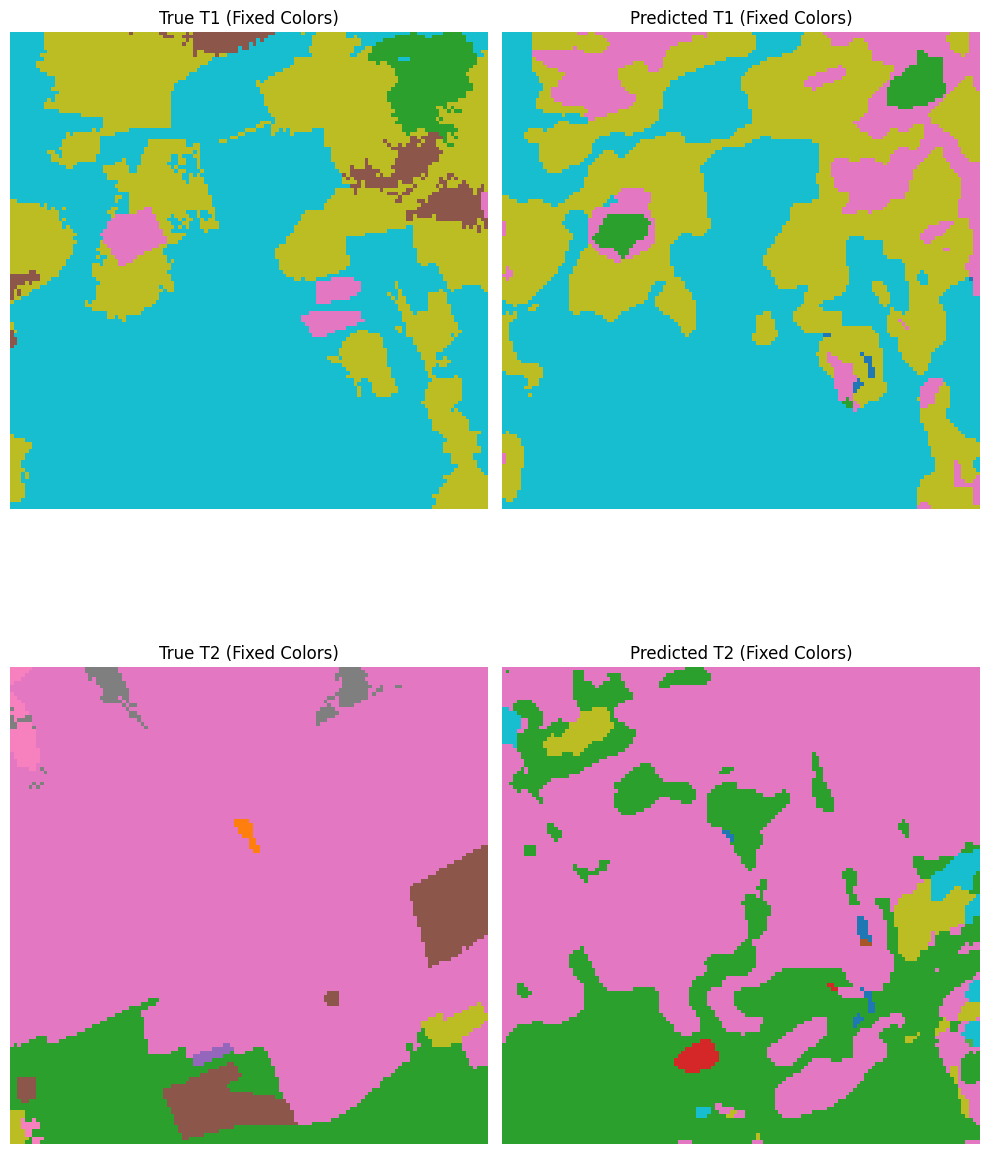

In [ ]:
# === Inference + Accuracy 可視化（Training）===
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter

# ✅ Colormap for 13 類
color_list = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#f781bf", "#a65628", "#4daf4a"
]
custom_cmap = mcolors.ListedColormap(color_list)

# ✅ 使用第一張 training sample
(T1_train_batch, T2_train_batch), label_train_batch = train_dataset[0]
T1 = T1_train_batch[0]
T2 = T2_train_batch[0]
true_label = label_train_batch[0]

# ✅ 預測
pred_logits = model.predict([np.expand_dims(T1, 0), np.expand_dims(T2, 0)])
pred_label = np.argmax(pred_logits[0], axis=-1)

# ✅ 拆成 T1 / T2
true_T1 = true_label // 13
true_T2 = true_label % 13
pred_T1 = pred_label // 13
pred_T2 = pred_label % 13

# ✅ Accuracy 計算
transition_acc = np.mean(pred_label == true_label)
t1_acc = np.mean(pred_T1 == true_T1)
t2_acc = np.mean(pred_T2 == true_T2)

print(f"🎯 Transition Accuracy: {transition_acc:.4f}  (T1 & T2 both correct)")
print(f"🔹 T1 Accuracy:         {t1_acc:.4f}")
print(f"🔸 T2 Accuracy:         {t2_acc:.4f}")
print("Predicted T1 distribution:", Counter(pred_T1.flatten()))
print("Predicted T2 distribution:", Counter(pred_T2.flatten()))

# ✅ 可視化 Transition, T1, T2
fig, axs = plt.subplots(2, 2, figsize=(10, 14))

# T1
axs[0, 0].imshow(true_T1, cmap=custom_cmap, vmin=0, vmax=12)
axs[0, 0].set_title("True T1 (Fixed Colors)")
axs[0, 1].imshow(pred_T1, cmap=custom_cmap, vmin=0, vmax=12)
axs[0, 1].set_title("Predicted T1 (Fixed Colors)")

# T2
axs[1, 0].imshow(true_T2, cmap=custom_cmap, vmin=0, vmax=12)
axs[1, 0].set_title("True T2 (Fixed Colors)")
axs[1, 1].imshow(pred_T2, cmap=custom_cmap, vmin=0, vmax=12)
axs[1, 1].set_title("Predicted T2 (Fixed Colors)")

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
🎯 Transition Accuracy: 0.4662  (T1 & T2 both correct)
🔹 T1 Accuracy:         0.5607
🔸 T2 Accuracy:         0.7692
Predicted T1 distribution: Counter({np.int64(9): 6450, np.int64(8): 4396, np.int64(6): 4338, np.int64(2): 711, np.int64(0): 489})
Predicted T2 distribution: Counter({np.int64(9): 13969, np.int64(8): 2005, np.int64(0): 210, np.int64(2): 153, np.int64(6): 47})


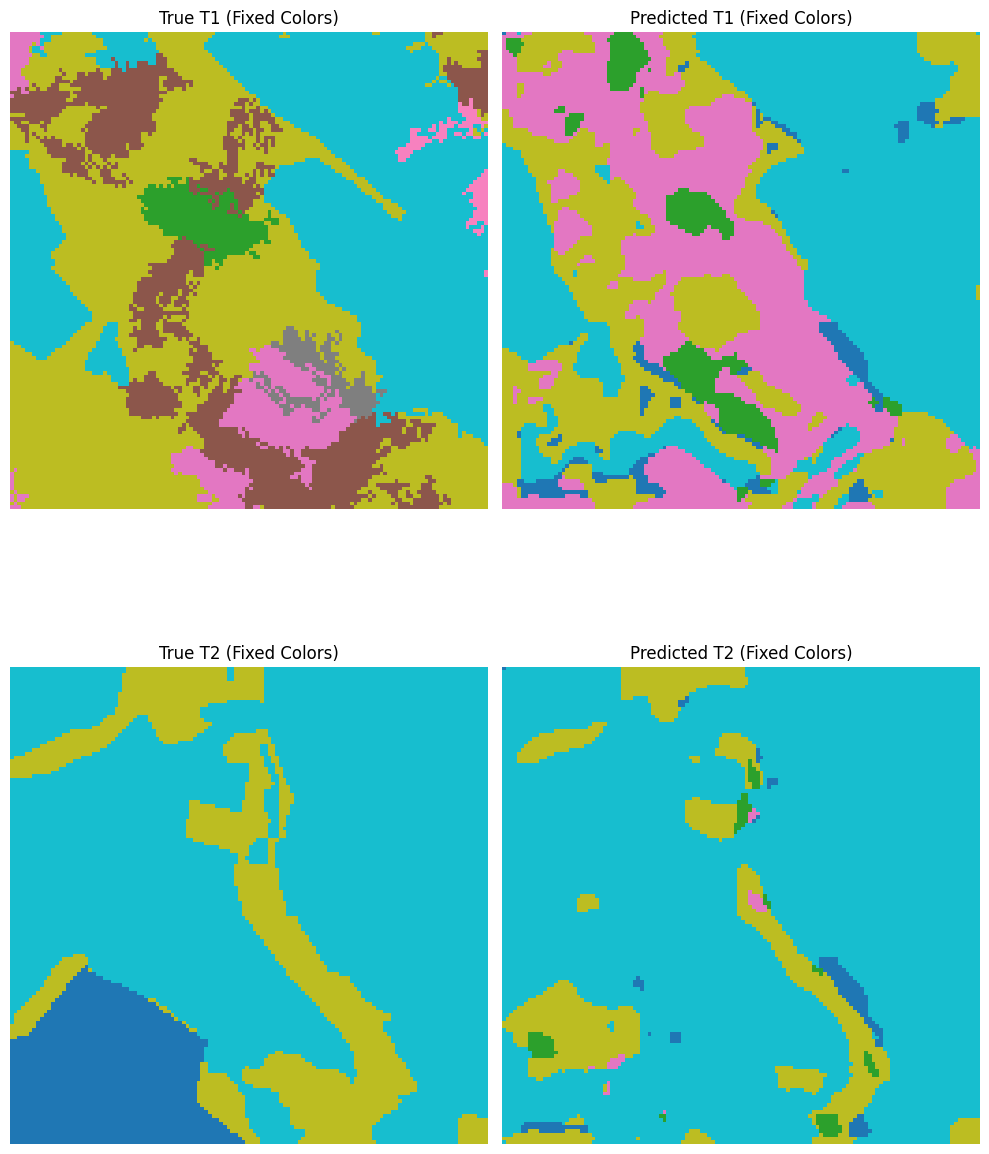

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from collections import Counter

# ✅ 自定 Layer for loading
class AbsLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.abs(inputs)

# ✅ Dataset
class PairedChangeDataset(tf.keras.utils.Sequence):
    def __init__(self, file_list, npz_dir, batch_size=8):
        self.files = file_list
        self.npz_dir = npz_dir
        self.batch_size = batch_size

    def __len__(self):
        return len(self.files) // self.batch_size

    def __getitem__(self, idx):
        batch_files = self.files[idx * self.batch_size:(idx + 1) * self.batch_size]
        T1_batch, T2_batch, label_batch = [], [], []
        for f in batch_files:
            data = np.load(os.path.join(self.npz_dir, f))
            T1, T2 = data['T1'], data['T2']
            label = data['transition_label']
            T1_batch.append(T1)
            T2_batch.append(T2)
            label_batch.append(label)

        T1 = np.array(T1_batch).astype(np.float32).transpose(0, 2, 3, 1)
        T2 = np.array(T2_batch).astype(np.float32).transpose(0, 2, 3, 1)
        label = np.array(label_batch).astype(np.int32)
        return ((T1, T2), label)

# ✅ 固定 colormap（13 類）
color_list = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#f781bf", "#a65628", "#4daf4a"
]
custom_cmap = mcolors.ListedColormap(color_list)

# === Block B: Visualize First Testing Sample ===
if __name__ == '__main__':
    npz_dir = '/content/paired_data/with_transition'
    all_files = sorted([f for f in os.listdir(npz_dir) if f.endswith('.npz')])
    _, test_files = train_test_split(all_files, test_size=0.1, random_state=42)

    test_dataset = PairedChangeDataset(test_files, npz_dir, batch_size=8)
    model = tf.keras.models.load_model('change_model_softmax.h5', custom_objects={'AbsLayer': AbsLayer})

    (T1_test_batch, T2_test_batch), label_test_batch = test_dataset[0]
    T1 = T1_test_batch[0]
    T2 = T2_test_batch[0]
    true_label = label_test_batch[0]

    pred_logits = model.predict([np.expand_dims(T1, 0), np.expand_dims(T2, 0)])
    pred_label = np.argmax(pred_logits[0], axis=-1)

    # 拆成 T1 和 T2
    true_T1 = true_label // 13
    true_T2 = true_label % 13
    pred_T1 = pred_label // 13
    pred_T2 = pred_label % 13

    # === Accuracy
    transition_acc = np.mean(pred_label == true_label)
    t1_acc = np.mean(pred_T1 == true_T1)
    t2_acc = np.mean(pred_T2 == true_T2)

    print(f"🎯 Transition Accuracy: {transition_acc:.4f}  (T1 & T2 both correct)")
    print(f"🔹 T1 Accuracy:         {t1_acc:.4f}")
    print(f"🔸 T2 Accuracy:         {t2_acc:.4f}")
    print("Predicted T1 distribution:", Counter(pred_T1.flatten()))
    print("Predicted T2 distribution:", Counter(pred_T2.flatten()))

    # === 可視化：Transition + T1 + T2
    fig, axs = plt.subplots(2, 2, figsize=(10, 14))

    # T1
    axs[0, 0].imshow(true_T1, cmap=custom_cmap, vmin=0, vmax=12)
    axs[0, 0].set_title("True T1 (Fixed Colors)")
    axs[0, 1].imshow(pred_T1, cmap=custom_cmap, vmin=0, vmax=12)
    axs[0, 1].set_title("Predicted T1 (Fixed Colors)")

    # T2
    axs[1, 0].imshow(true_T2, cmap=custom_cmap, vmin=0, vmax=12)
    axs[1, 0].set_title("True T2 (Fixed Colors)")
    axs[1, 1].imshow(pred_T2, cmap=custom_cmap, vmin=0, vmax=12)
    axs[1, 1].set_title("Predicted T2 (Fixed Colors)")

    for ax in axs.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.show()